# WGCNA
weighted gene co-expression network analysis

# Phase 2

following [Hovrath Lab Tutorial](https://www.dropbox.com/scl/fo/4vqfiysan6rlurfo2pbnk/h?dl=0&e=1&preview=Consensus-NetworkConstruction-man.pdf&rlkey=thqg8wlpdn4spu3ihjuc1kmlu)

## 0. load libraries

In [101]:
library(tidyverse)
library(DESeq2)
library(WGCNA)
library(janitor) # for row_to_names()
library(zoo)
library(ComplexHeatmap)
library(circlize)
library(reshape)
library(fastDummies) # create 0/1 factor columns
library(ape) # for read.gff
library(cowplot) # for plot_grid()

In [3]:
# important setting, cannot omit
options(stringsAsFactors = FALSE)

In [4]:
# allow multi-threading within WGCNA
enableWGCNAThreads()

Allowing parallel execution with up to 23 working processes.


## 1. structure WGCNA input

**Expected input**:
- Rows = samples
- Columns = genes (or probes/features)
- Values = numeric expression values

### A. format vst normalized counts matrix

In [5]:
# counts matrix
dataExpr <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_rawLFC/deseq_vstCounts.csv')

# set gene name as rowname
rownames(dataExpr) <- dataExpr$X

 
dataExpr <- dataExpr %>% 
select(-X) %>% # remove gene name as column
t() # transpose so samples = rows, genes = columns

head(dataExpr)
dim(dataExpr) # 94 samples x 35466 genes

LOC111116054 LOC111126949 LOC111110729 LOC111112434 LOC111120752
B1_B1_O01 7.692872     10.197580    8.354765     7.886383     9.363550    
B1_W5_O50 7.805746      9.653169    8.542687     7.697174     9.355360    
B2_B5_O51 7.871959      9.900281    8.351593     7.548551     9.509373    
B2_C4_O40 7.843091      9.718856    8.513945     7.687586     9.284512    
B3_B4_O41 7.548551      9.612738    8.518601     7.940109     9.198871    
B3_C3_O30 7.909124      9.545333    8.653091     7.989592     9.337765    
          LOC111128944 LOC111128953 LOC111105691 LOC111133554 LOC111125466 ⋯
B1_B1_O01 7.548551     7.548551     7.692872     7.548551     7.650623     ⋯
B1_W5_O50 7.548551     7.548551     7.845404     7.548551     7.548551     ⋯
B2_B5_O51 7.548551     7.548551     8.595408     7.548551     7.651014     ⋯
B2_C4_O40 7.548551     7.548551     8.101515     7.843091     7.548551     ⋯
B3_B4_O41 7.548551     7.548551     8.014009     7.548551     7.661902     ⋯
B3_C3_O30 7.548551     7.710140     8.149132     7.828140     7.926626     ⋯
          CYTB     COX2     ATP6     ND2      ND4      ND5      ND6     
B1_B1_O01 18.94773 17.35567 16.72734 16.55278 17.40296 17.50511 15.27334
B1_W5_O50 19.25087 17.60046 17.05547 16.54477 16.97662 17.30129 15.59674
B2_B5_O51 19.41971 17.94342 17.27196 17.23549 17.79404 18.11808 15.98559
B2_C4_O40 18.86611 17.79882 17.27281 16.61824 17.19524 17.19285 15.14694
B3_B4_O41 19.71514 18.17021 17.54836 17.11674 17.49138 17.97654 15.71235
B3_C3_O30 19.27273 17.87689 17.64807 17.08072 17.29751 17.13546 15.58747
          ND3      ND1      ND4L    
B1_B1_O01 14.40950 17.08613 13.21049
B1_W5_O50 14.95796 17.21506 13.41728
B2_B5_O51 15.64247 17.74181 13.77409
B2_C4_O40 14.83363 17.01083 13.11047
B3_B4_O41 15.28878 17.71717 13.87237
B3_C3_O30 15.14063 17.14174 13.28853

[1]    94 35466

### B. identify and remove genes with missing data 
genes with too many NAs or zero-counts

In [6]:
gsg <- goodSamplesGenes(dataExpr, verbose = 3)
gsg$allOK

dataExpr <- dataExpr[gsg$goodSamples, gsg$goodGenes]
dim(dataExpr) # 94 samples x 35396 genes

 Flagging genes and samples with too many missing values...
  ..step 1
  ..Excluding 70 genes from the calculation due to too many missing samples or zero variance.
  ..step 2


[1] FALSE

[1]    94 35396

### C. Sample size and gene filtering

removing low-variance genes first:

In [7]:
dataExpr <- dataExpr[, apply(dataExpr, 2, var) > quantile(apply(dataExpr, 2, var), 0.25)]
dim(dataExpr) # 94 samples x 26547 genes

[1]    94 26547

### D. Sample outlier detection

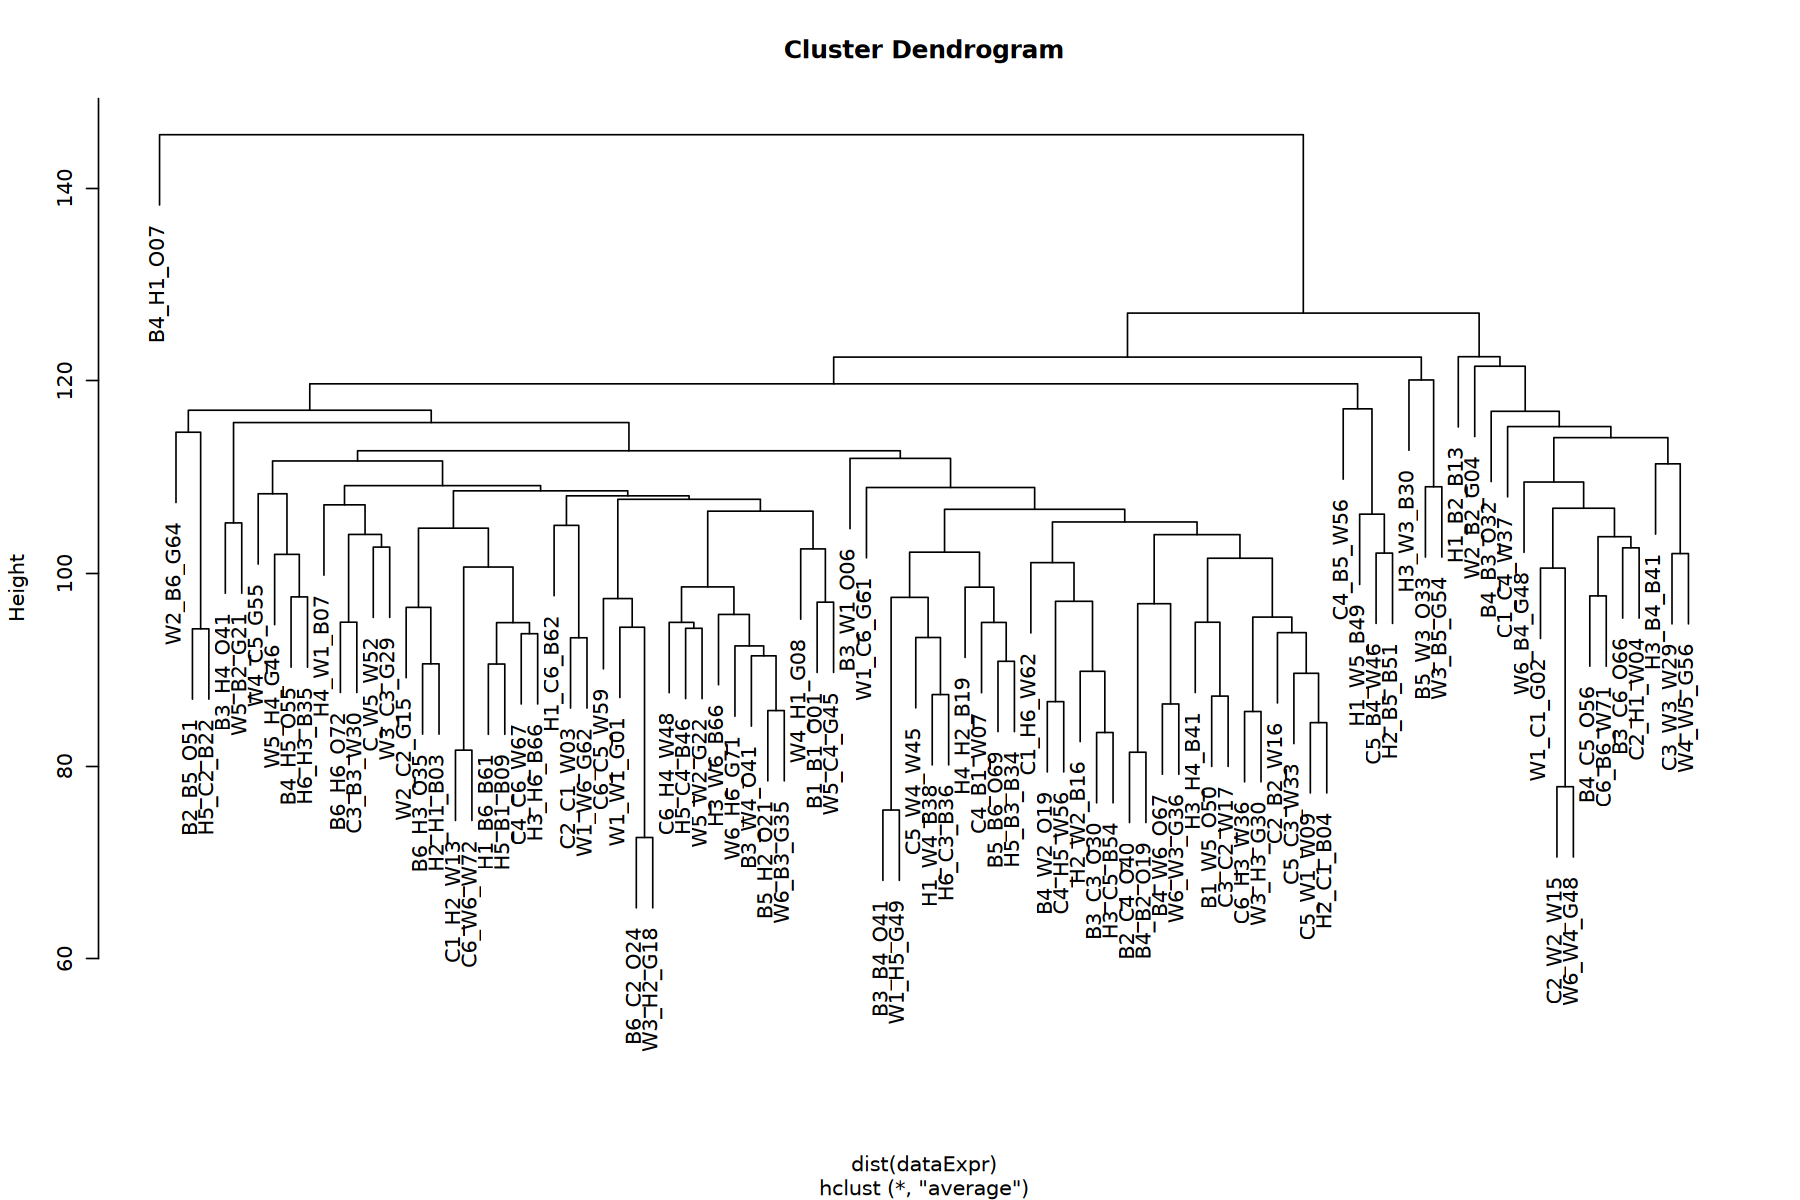

In [8]:
options(repr.plot.width = 15, repr.plot.height = 10)

sampleTree <- hclust(dist(dataExpr), method = "average")
plot(sampleTree)

only obvious outlier - B4_H1_O07 - becuase it clusters above the rest of the tree and is separated from the main cluster - going to remove it from analysis

In [9]:
dataExpr <- dataExpr[!rownames(dataExpr) %in% c("B4_H1_O07"), ]
dim(dataExpr) # 93 samples x 26547 genes

[1]    93 26547

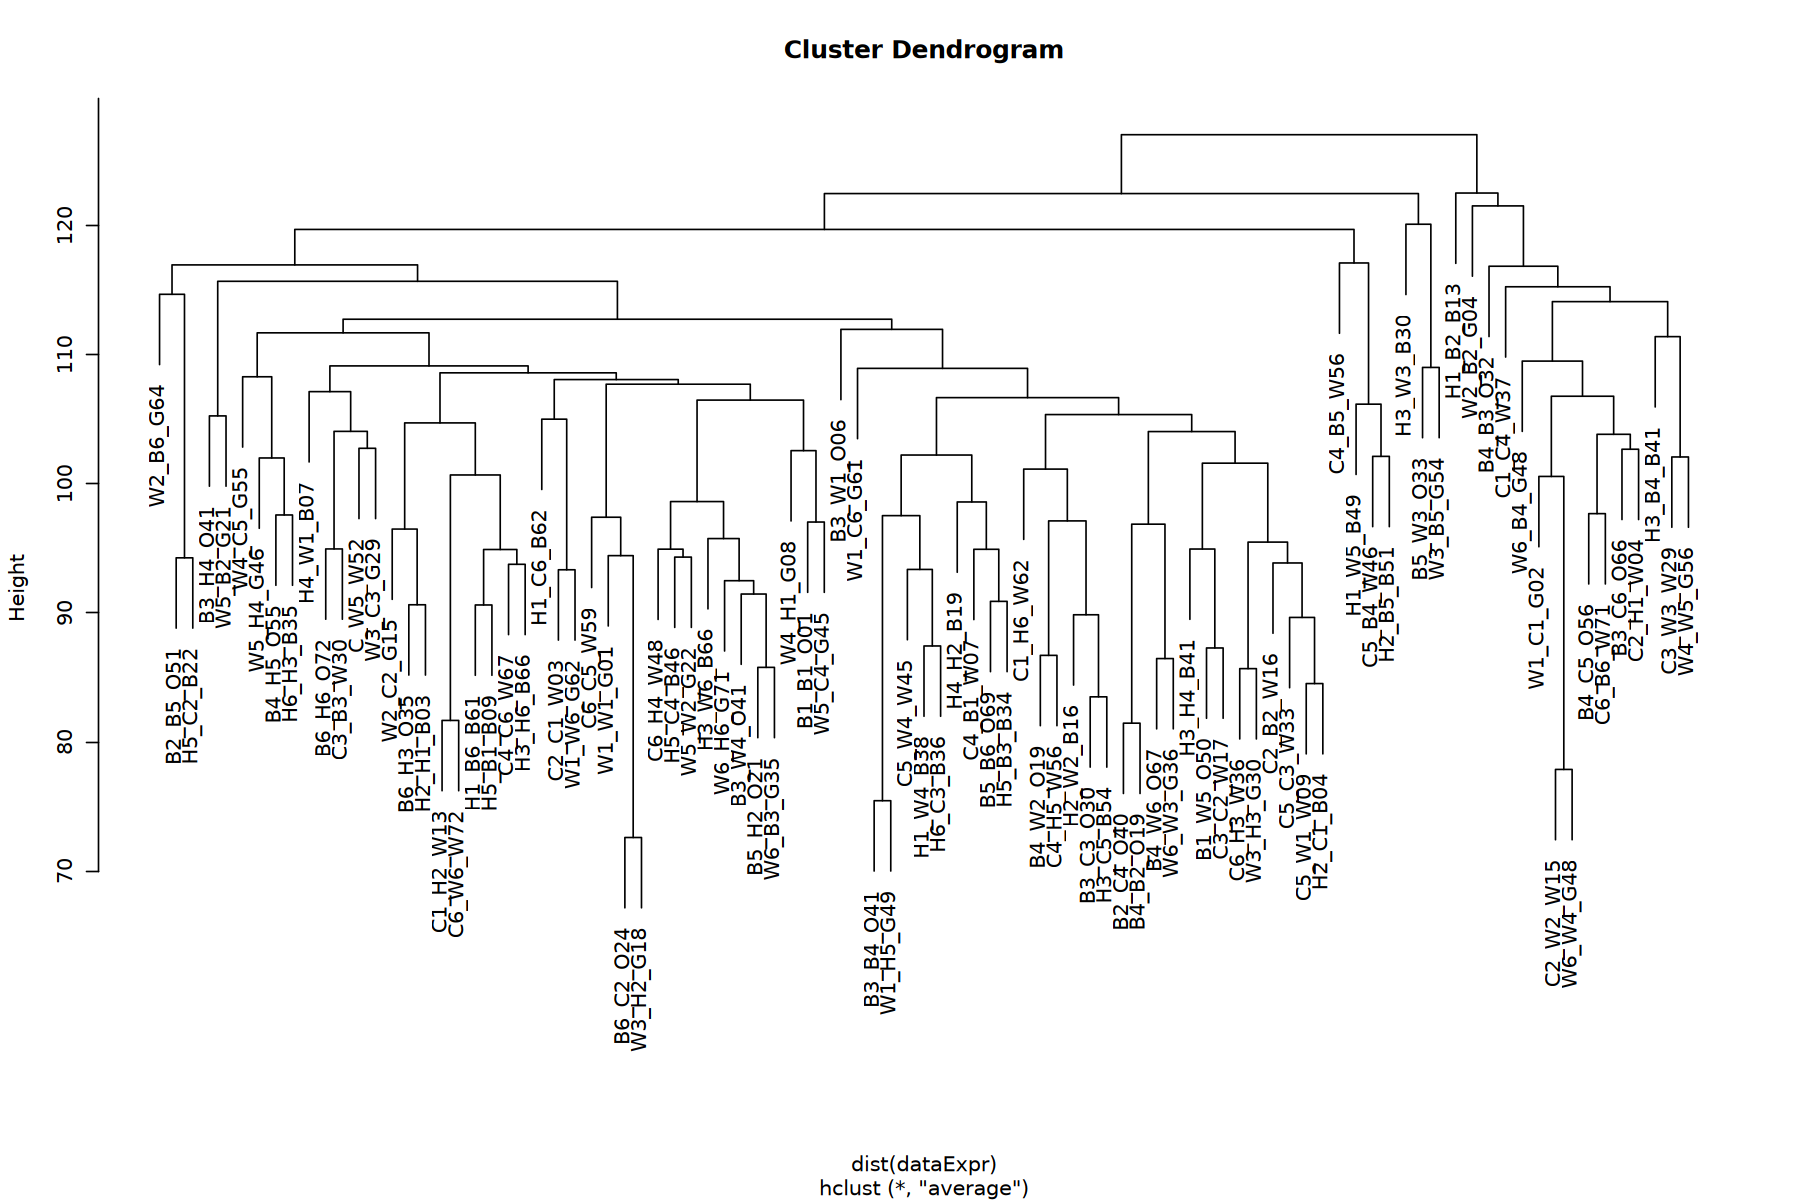

In [10]:
# replot without outliers
sampleTree <- hclust(dist(dataExpr), method = "average")
plot(sampleTree)

looks much better!

### meta data
could add phenotypic data to this ...

In [11]:
meta <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/metaData/sample_metaData.csv') %>%
filter(!grepl("Nu", Sample)) # filter out phase 1 samples - only want phase 2

# setting samples as rownames and deleting col from df
rownames(meta) <- meta$Sample
meta <- meta[, !colnames(meta) %in% "Sample"]

# removing same samples as dataExpr
meta <- meta[rownames(meta) %in% rownames(dataExpr), ]

head(meta)
dim(meta) # 92 samples

Phase1_treatment Phase1_temp Phase1_DO Phase1_TankRep
B1_B1_O01 both             warm        hypoxic   1             
B1_W5_O50 both             warm        hypoxic   1             
B2_B5_O51 both             warm        hypoxic   2             
B2_C4_O40 both             warm        hypoxic   2             
B3_B4_O41 both             warm        hypoxic   3             
B3_C3_O30 both             warm        hypoxic   3             
          Phase2_treatment Phase2_temp Phase2_DO Phase2_TankRep
B1_B1_O01 both             warm        hypoxic   1             
B1_W5_O50 warm             warm        normoxic  5             
B2_B5_O51 both             warm        hypoxic   5             
B2_C4_O40 control          ambient     normoxic  4             
B3_B4_O41 both             warm        hypoxic   4             
B3_C3_O30 control          ambient     normoxic  3

[1] 93  8

creating new column for 'complete' treatment - so I can easily compare phase 1 to phase 2

In [12]:
meta$complete_trtmt <- paste(meta$Phase1_treatment, meta$Phase2_treatment)

In [13]:
# double checking the samples in rownames are the same
all(rownames(meta) == rownames(dataExpr))

[1] TRUE

## 2. simple WGCNA network construction and module identification
start with simple, can progress to consensus if deemed necessary

In [14]:
# final QC check
gsg <- goodSamplesGenes(dataExpr, verbose = 3)
if (!gsg$allOK) {
  dataExpr <- dataExpr[gsg$goodSamples, gsg$goodGenes]
}

gsg$allOK

 Flagging genes and samples with too many missing values...
  ..step 1


[1] TRUE

### A. choose soft thresholding power (β)
analysis of network topology

In [15]:
powers <- c(1:20)
sft <- pickSoftThreshold(
  dataExpr,
  powerVector = powers,
  networkType = "signed",
  verbose = 5
)


pickSoftThreshold: will use block size 1685.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 1685 of 26547
   ..working on genes 1686 through 3370 of 26547
   ..working on genes 3371 through 5055 of 26547
   ..working on genes 5056 through 6740 of 26547
   ..working on genes 6741 through 8425 of 26547
   ..working on genes 8426 through 10110 of 26547
   ..working on genes 10111 through 11795 of 26547
   ..working on genes 11796 through 13480 of 26547
   ..working on genes 13481 through 15165 of 26547
   ..working on genes 15166 through 16850 of 26547
   ..working on genes 16851 through 18535 of 26547
   ..working on genes 18536 through 20220 of 26547
   ..working on genes 20221 through 21905 of 26547
   ..working on genes 21906 through 23590 of 26547
   ..working on genes 23591 through 25275 of 26547
   ..working on genes 25276 through 26547 of 26547
   Power SFT.R.sq  slope truncated.R.sq  mean.k. median.k. max.k.
1      1   0.0177 -12.

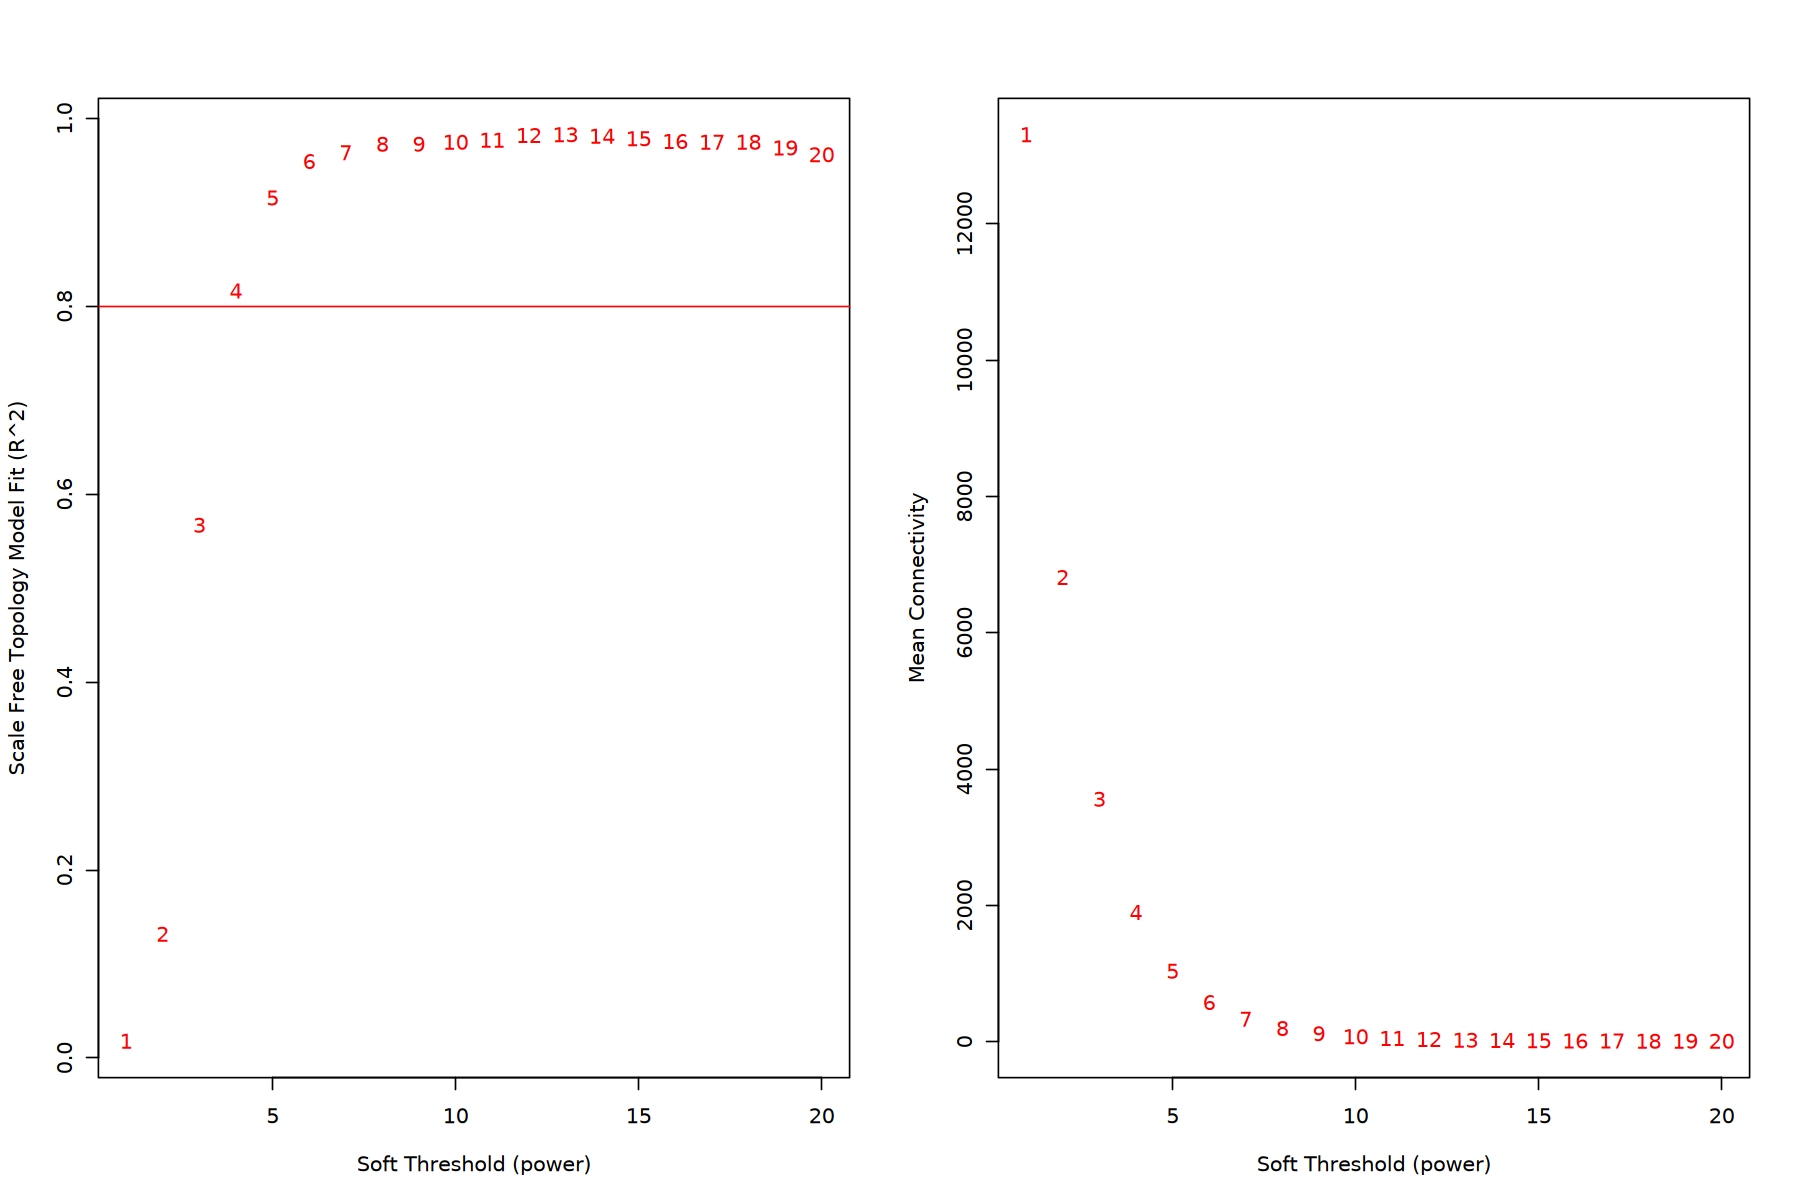

In [16]:
par(mfrow = c(1,2))
plot(
  sft$fitIndices[,1],
  -sign(sft$fitIndices[,3]) * sft$fitIndices[,2],
  xlab = "Soft Threshold (power)",
  ylab = "Scale Free Topology Model Fit (R^2)",
  type = "n"
)
text(
  sft$fitIndices[,1],
  -sign(sft$fitIndices[,3]) * sft$fitIndices[,2],
  labels = powers,
  col = "red"
)
abline(h = 0.8, col = "red")

plot(
  sft$fitIndices[,1],
  sft$fitIndices[,5],
  xlab = "Soft Threshold (power)",
  ylab = "Mean Connectivity",
  type = "n"
)
text(
  sft$fitIndices[,1],
  sft$fitIndices[,5],
  labels = powers,
  col = "red"
)


#### left plot - scale-free topology
the red line is where R^2 is 0.8 - you want the lowest power that reaches this - 4 is just above 0.8 and anything after 6 plateaus

#### right plot - mean connectivity
connectivity should not collapse to 0 - by power 8-10, the connectivity approaches 0

based on this, I think power of 5 should be appropriate

### B. co-expression similarity and adjacency

creating adjacency matrix

In [17]:
softPower <- 5

calculate co-expression adjacency using soft threshold power of 5

can do this signed or unsigned (default) - at this point, I'm not too sure what the difference is

In [18]:
# unsigned
adjacency_unsign <- adjacency(dataExpr, power = softPower, type = 'unsigned') 
head(adjacency_unsign)

# signed
adjacency_sign <- adjacency(dataExpr, power = softPower, type = 'signed') 
head(adjacency_sign)

LOC111126949 LOC111120752 LOC111105691 LOC111113860 LOC111109550
LOC111126949 1.000000e+00 1.782543e-03 2.752219e-08 4.600205e-07 9.155717e-05
LOC111120752 1.782543e-03 1.000000e+00 1.716104e-06 3.146263e-08 7.358584e-05
LOC111105691 2.752219e-08 1.716104e-06 1.000000e+00 1.084102e-06 1.915999e-05
LOC111113860 4.600205e-07 3.146263e-08 1.084102e-06 1.000000e+00 2.333026e-05
LOC111109550 9.155717e-05 7.358584e-05 1.915999e-05 2.333026e-05 1.000000e+00
LOC111109753 1.656267e-05 1.762023e-09 2.407908e-07 8.882854e-06 4.656518e-06
             LOC111109753 LOC111109452 LOC111124802 LOC111101273 LOC111101250 ⋯
LOC111126949 1.656267e-05 8.391595e-13 2.581975e-03 1.319233e-02 4.230721e-05 ⋯
LOC111120752 1.762023e-09 1.690230e-05 1.070843e-05 3.894397e-02 1.183032e-05 ⋯
LOC111105691 2.407908e-07 6.601852e-07 6.362332e-11 5.738142e-08 2.303477e-04 ⋯
LOC111113860 8.882854e-06 3.091483e-04 1.303715e-07 1.645528e-07 5.683632e-07 ⋯
LOC111109550 4.656518e-06 4.186890e-08 2.371397e-05 2.300438e-07 1.194374e-06 ⋯
LOC111109753 1.000000e+00 2.298499e-08 2.020960e-04 8.740811e-04 2.179421e-08 ⋯
             CYTB         COX2         ATP6         ND2          ND4         
LOC111126949 7.160573e-07 1.558930e-05 5.919973e-06 1.493077e-04 2.374682e-09
LOC111120752 8.026964e-03 6.595698e-03 1.598050e-02 4.779981e-03 3.795156e-02
LOC111105691 2.204940e-04 1.582523e-08 5.902503e-10 4.193395e-08 1.465177e-06
LOC111113860 6.034621e-06 4.048877e-04 1.244493e-03 1.803356e-04 7.549985e-06
LOC111109550 6.849831e-15 2.213905e-04 7.697647e-08 7.936029e-06 4.187663e-07
LOC111109753 3.920238e-05 1.177167e-06 4.570454e-16 3.930212e-07 8.284044e-07
             ND5          ND6          ND3          ND1          ND4L        
LOC111126949 5.391527e-09 5.879192e-05 1.105667e-08 2.965007e-06 6.959330e-07
LOC111120752 4.617818e-03 2.676368e-02 1.774048e-02 1.566690e-02 1.381881e-02
LOC111105691 4.447607e-05 2.631513e-11 1.409498e-07 1.039271e-05 2.704959e-09
LOC111113860 2.280600e-06 6.601983e-04 4.168502e-05 2.332036e-04 4.252386e-04
LOC111109550 8.517485e-10 7.454661e-10 5.411355e-08 1.497762e-07 1.762907e-14
LOC111109753 1.910615e-04 1.535774e-07 4.270411e-05 1.626405e-04 1.795192e-05

LOC111126949 LOC111120752 LOC111105691 LOC111113860 LOC111109550
LOC111126949 1.00000000   0.00596421   0.02673096   0.02367334   0.06443312  
LOC111120752 0.00596421   1.00000000   0.02170610   0.03650792   0.06259823  
LOC111105691 0.02673096   0.02170610   1.00000000   0.04263922   0.05358685  
LOC111113860 0.02367334   0.03650792   0.04263922   1.00000000   0.05469640  
LOC111109550 0.06443312   0.06259823   0.05358685   0.05469640   1.00000000  
LOC111109753 0.05280483   0.02857326   0.03940373   0.01869409   0.04716812  
             LOC111109753 LOC111109452 LOC111124802 LOC111101273 LOC111101250 ⋯
LOC111126949 0.05280483   0.03185524   0.11767250   0.002037204  0.01527023   ⋯
LOC111120752 0.02857326   0.05291190   0.05064454   0.255646300  0.01810499   ⋯
LOC111105691 0.03940373   0.02317122   0.02984845   0.037227386  0.01108081   ⋯
LOC111113860 0.01869409   0.01032832   0.02521879   0.038753608  0.02338274   ⋯
LOC111109550 0.04716812   0.03683787   0.05479113   0.024561187  0.02228596   ⋯
LOC111109753 1.00000000   0.02688139   0.07223356   0.007690798  0.02692491   ⋯
             CYTB       COX2        ATP6        ND2        ND4       
LOC111126949 0.04162633 0.017520275 0.019496087 0.01218261 0.02841485
LOC111120752 0.15696330 0.148799263 0.191643328 0.13676826 0.25339540
LOC111105691 0.01119240 0.035795722 0.029084096 0.03683972 0.02196268
LOC111113860 0.01945904 0.009637944 0.006821705 0.01170431 0.01901998
LOC111109550 0.03102108 0.011182048 0.037616489 0.01892067 0.04045961
LOC111109753 0.05793885 0.042853010 0.031116627 0.04033135 0.04197053
             ND5        ND6         ND3        ND1        ND4L       
LOC111126949 0.03487613 0.014487059 0.02744560 0.04558078 0.041560431
LOC111120752 0.13556982 0.225477159 0.19787840 0.19049290 0.183436092
LOC111105691 0.01515245 0.032464819 0.03850535 0.01837367 0.028342929
LOC111113860 0.02123009 0.008394532 0.01530505 0.01104935 0.009512618
LOC111109550 0.03372294 0.028983659 0.03715280 0.03860167 0.030973609
LOC111109753 0.07161344 0.038641818 0.05852193 0.06989560 0.053233270

In [19]:
# write.csv(data.frame(gene = rownames(adjacency_sign)), '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/wgcna/p2.wgcna_UniversalGeneList.csv', row.names = FALSE)

### C. Topological Overlap Matrix (TOM)
transform adjacency into TOM to minimize effects of noise and spurious associations - calculate corresponding dissimilarity

In [20]:
## UNSIGNED
# turn adjacency into topological overlap
TOM_unsign <- TOMsimilarity(adjacency_unsign)
head(TOM_unsign)

# calculate dissimilarity
dissTOM_unsign <- 1-TOM_unsign
head(dissTOM_unsign)


## SIGNED
# turn adjacency into topological overlap
TOM_sign <- TOMsimilarity(adjacency_sign)
head(TOM_sign)

# calculate dissimilarity
dissTOM_sign <- 1-TOM_sign
head(dissTOM_sign)

..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


[,1]         [,2]         [,3]         [,4]         [,5]        
[1,] 1.0000000000 0.0042933083 1.852709e-04 5.818304e-04 0.0005404566
[2,] 0.0042933083 1.0000000000 2.773913e-04 1.873669e-03 0.0004478330
[3,] 0.0001852709 0.0002773913 1.000000e+00 5.565506e-05 0.0001184485
[4,] 0.0005818304 0.0018736690 5.565506e-05 1.000000e+00 0.0001005873
[5,] 0.0005404566 0.0004478330 1.184485e-04 1.005873e-04 1.0000000000
[6,] 0.0003144408 0.0001914498 2.327076e-04 1.449656e-04 0.0003099846
     [,6]         [,7]         [,8]         [,9]         [,10]        [,11]
[1,] 0.0003144408 0.0005682741 0.0020470717 0.0071768146 0.0037048014 ⋯    
[2,] 0.0001914498 0.0012254369 0.0010705347 0.0226939637 0.0030848120 ⋯    
[3,] 0.0002327076 0.0001395993 0.0001562924 0.0001999636 0.0007183777 ⋯    
[4,] 0.0001449656 0.0014757616 0.0003609820 0.0011261494 0.0016916643 ⋯    
[5,] 0.0003099846 0.0001955092 0.0004039726 0.0003043675 0.0003599073 ⋯    
[6,] 1.0000000000 0.0001828311 0.0004006687 0.0004618206 0.0001673186 ⋯    
     [,12]        [,13]        [,14]        [,15]        [,16]       
[1,] 0.0004408250 0.0005759230 0.0005677051 0.0004982259 0.0008827370
[2,] 0.0164825038 0.0195005626 0.0236828804 0.0198913808 0.0231048502
[3,] 0.0003600078 0.0001663546 0.0001553802 0.0001165873 0.0002603584
[4,] 0.0005621569 0.0006108221 0.0007841932 0.0004435304 0.0007163779
[5,] 0.0002965254 0.0003927036 0.0002604835 0.0001557174 0.0003543204
[6,] 0.0008082062 0.0004760549 0.0001727626 0.0003480783 0.0003218440
     [,17]        [,18]        [,19]        [,20]        [,21]       
[1,] 0.0003837645 0.0007463244 0.0005814072 0.0006610943 0.0004647112
[2,] 0.0120065692 0.0230095491 0.0235759301 0.0164464391 0.0184666636
[3,] 0.0002545397 0.0002055112 0.0002058637 0.0003232873 0.0001910332
[4,] 0.0004381356 0.0010218126 0.0006395913 0.0008489379 0.0006412816
[5,] 0.0002128943 0.0003100519 0.0003067601 0.0003578739 0.0002432699
[6,] 0.0011239916 0.0002740738 0.0007224079 0.0027691623 0.0018399482

[,1]      [,2]      [,3]      [,4]      [,5]      [,6]      [,7]     
[1,] 0.0000000 0.9957067 0.9998147 0.9994182 0.9994595 0.9996856 0.9994317
[2,] 0.9957067 0.0000000 0.9997226 0.9981263 0.9995522 0.9998086 0.9987746
[3,] 0.9998147 0.9997226 0.0000000 0.9999443 0.9998816 0.9997673 0.9998604
[4,] 0.9994182 0.9981263 0.9999443 0.0000000 0.9998994 0.9998550 0.9985242
[5,] 0.9994595 0.9995522 0.9998816 0.9998994 0.0000000 0.9996900 0.9998045
[6,] 0.9996856 0.9998086 0.9997673 0.9998550 0.9996900 0.0000000 0.9998172
     [,8]      [,9]      [,10]     [,11] [,12]     [,13]     [,14]    
[1,] 0.9979529 0.9928232 0.9962952 ⋯     0.9995592 0.9994241 0.9994323
[2,] 0.9989295 0.9773060 0.9969152 ⋯     0.9835175 0.9804994 0.9763171
[3,] 0.9998437 0.9998000 0.9992816 ⋯     0.9996400 0.9998336 0.9998446
[4,] 0.9996390 0.9988739 0.9983083 ⋯     0.9994378 0.9993892 0.9992158
[5,] 0.9995960 0.9996956 0.9996401 ⋯     0.9997035 0.9996073 0.9997395
[6,] 0.9995993 0.9995382 0.9998327 ⋯     0.9991918 0.9995239 0.9998272
     [,15]     [,16]     [,17]     [,18]     [,19]     [,20]     [,21]    
[1,] 0.9995018 0.9991173 0.9996162 0.9992537 0.9994186 0.9993389 0.9995353
[2,] 0.9801086 0.9768951 0.9879934 0.9769905 0.9764241 0.9835536 0.9815333
[3,] 0.9998834 0.9997396 0.9997455 0.9997945 0.9997941 0.9996767 0.9998090
[4,] 0.9995565 0.9992836 0.9995619 0.9989782 0.9993604 0.9991511 0.9993587
[5,] 0.9998443 0.9996457 0.9997871 0.9996899 0.9996932 0.9996421 0.9997567
[6,] 0.9996519 0.9996782 0.9988760 0.9997259 0.9992776 0.9972308 0.9981601

..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


[,1]       [,2]       [,3]       [,4]       [,5]       [,6]      
[1,] 1.00000000 0.03203669 0.04325609 0.03859603 0.04767874 0.04841777
[2,] 0.03203669 1.00000000 0.04151904 0.04947939 0.04474896 0.04240832
[3,] 0.04325609 0.04151904 1.00000000 0.03602860 0.03812489 0.04259115
[4,] 0.03859603 0.04947939 0.03602860 1.00000000 0.03793008 0.04057033
[5,] 0.04767874 0.04474896 0.03812489 0.03793008 1.00000000 0.04515372
[6,] 0.04841777 0.04240832 0.04259115 0.04057033 0.04515372 1.00000000
     [,7]       [,8]       [,9]       [,10]      [,11] [,12]      [,13]     
[1,] 0.04451317 0.05394023 0.02788190 0.03691653 ⋯     0.04095883 0.03843461
[2,] 0.04069907 0.04546719 0.07603718 0.03576878 ⋯     0.06625035 0.06621622
[3,] 0.03941299 0.04030782 0.03924153 0.03933737 ⋯     0.04050891 0.04099153
[4,] 0.03429513 0.03711149 0.04525296 0.04092677 ⋯     0.04474596 0.04012829
[5,] 0.03986899 0.04416545 0.03677512 0.04383935 ⋯     0.04130757 0.03881138
[6,] 0.04496422 0.05007689 0.03452615 0.04054339 ⋯     0.05118587 0.04825489
     [,14]      [,15]      [,16]      [,17]      [,18]      [,19]     
[1,] 0.03899431 0.03807728 0.04075141 0.04319353 0.03923952 0.04058928
[2,] 0.06956860 0.06530790 0.07331335 0.06192108 0.06849582 0.06912506
[3,] 0.04117581 0.04055060 0.04217482 0.03939417 0.04255275 0.04350582
[4,] 0.03969172 0.04049417 0.04444097 0.04076944 0.03947218 0.04203759
[5,] 0.04178284 0.03773336 0.04446496 0.04154167 0.04249430 0.04248601
[6,] 0.04445493 0.04639658 0.04698003 0.05398672 0.04633184 0.05064223
     [,20]      [,21]     
[1,] 0.04422606 0.04232475
[2,] 0.07022219 0.06638767
[3,] 0.04239243 0.04209052
[4,] 0.04310102 0.04108138
[5,] 0.04382650 0.04165347
[6,] 0.05719088 0.05367676

[,1]      [,2]      [,3]      [,4]      [,5]      [,6]      [,7]     
[1,] 0.0000000 0.9679633 0.9567439 0.9614040 0.9523213 0.9515822 0.9554868
[2,] 0.9679633 0.0000000 0.9584810 0.9505206 0.9552510 0.9575917 0.9593009
[3,] 0.9567439 0.9584810 0.0000000 0.9639714 0.9618751 0.9574089 0.9605870
[4,] 0.9614040 0.9505206 0.9639714 0.0000000 0.9620699 0.9594297 0.9657049
[5,] 0.9523213 0.9552510 0.9618751 0.9620699 0.0000000 0.9548463 0.9601310
[6,] 0.9515822 0.9575917 0.9574089 0.9594297 0.9548463 0.0000000 0.9550358
     [,8]      [,9]      [,10]     [,11] [,12]     [,13]     [,14]    
[1,] 0.9460598 0.9721181 0.9630835 ⋯     0.9590412 0.9615654 0.9610057
[2,] 0.9545328 0.9239628 0.9642312 ⋯     0.9337496 0.9337838 0.9304314
[3,] 0.9596922 0.9607585 0.9606626 ⋯     0.9594911 0.9590085 0.9588242
[4,] 0.9628885 0.9547470 0.9590732 ⋯     0.9552540 0.9598717 0.9603083
[5,] 0.9558345 0.9632249 0.9561606 ⋯     0.9586924 0.9611886 0.9582172
[6,] 0.9499231 0.9654738 0.9594566 ⋯     0.9488141 0.9517451 0.9555451
     [,15]     [,16]     [,17]     [,18]     [,19]     [,20]     [,21]    
[1,] 0.9619227 0.9592486 0.9568065 0.9607605 0.9594107 0.9557739 0.9576752
[2,] 0.9346921 0.9266867 0.9380789 0.9315042 0.9308749 0.9297778 0.9336123
[3,] 0.9594494 0.9578252 0.9606058 0.9574472 0.9564942 0.9576076 0.9579095
[4,] 0.9595058 0.9555590 0.9592306 0.9605278 0.9579624 0.9568990 0.9589186
[5,] 0.9622666 0.9555350 0.9584583 0.9575057 0.9575140 0.9561735 0.9583465
[6,] 0.9536034 0.9530200 0.9460133 0.9536682 0.9493578 0.9428091 0.9463232

### D. Call the hierarchical clustering function - plot the tree
hierarchical clustering tree (dendrogram) of genes

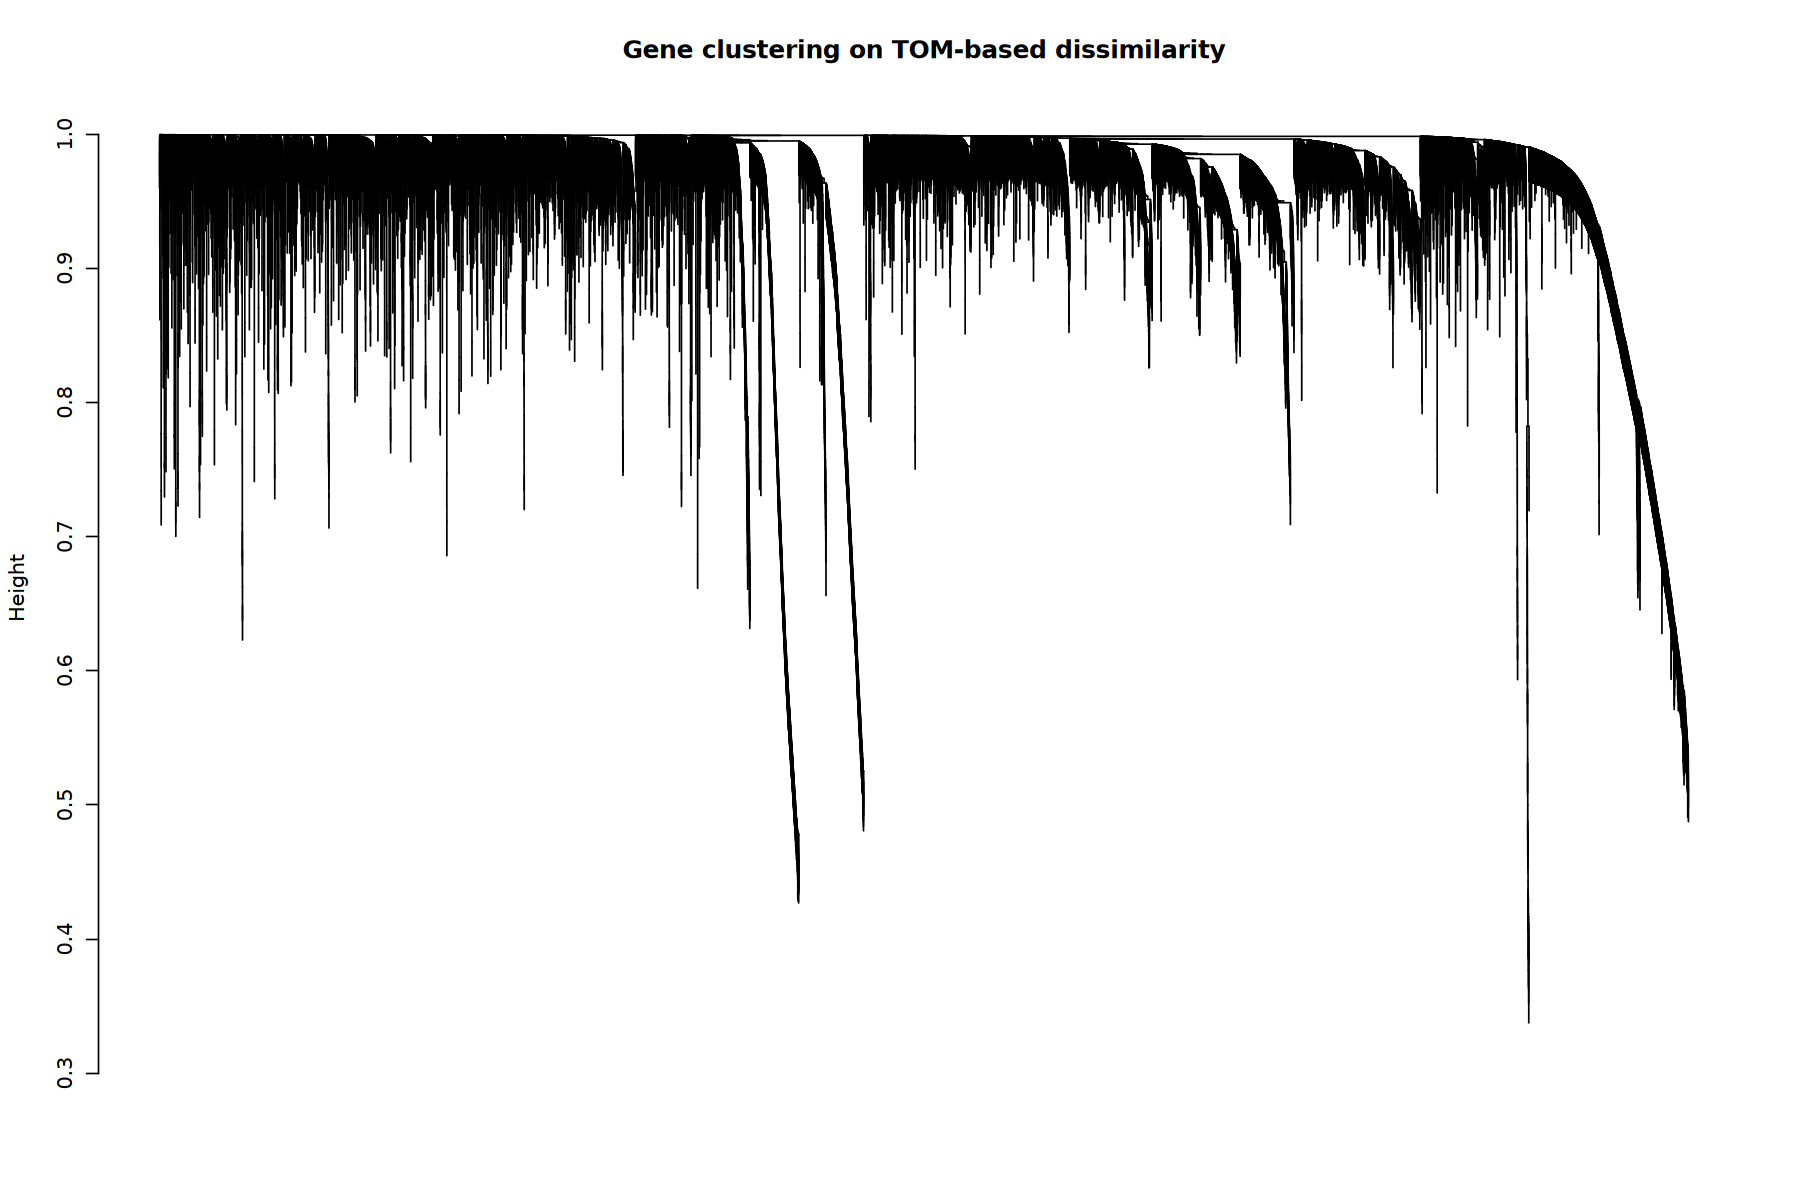

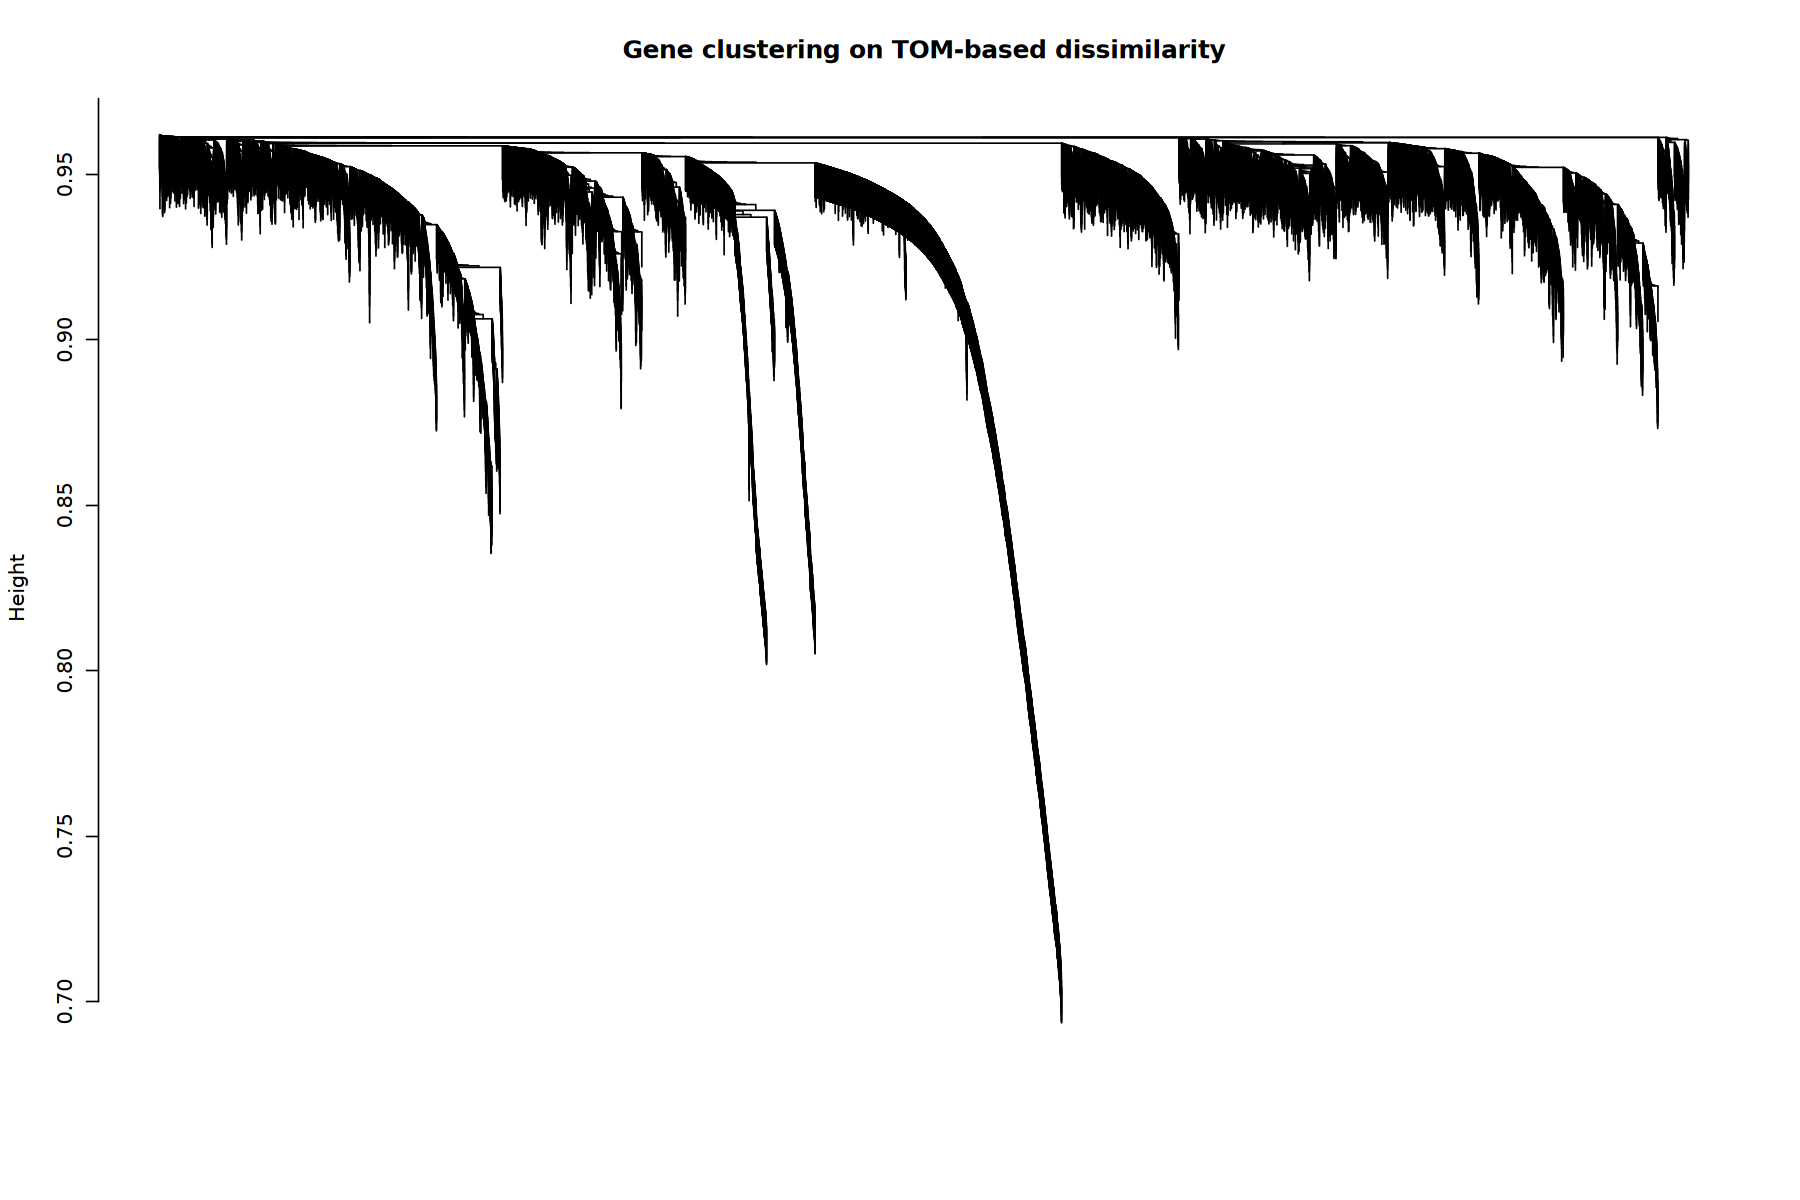

In [21]:
# call hierarchical clustering function
geneTree_unsign = hclust(as.dist(dissTOM_unsign), method = "average")
geneTree_sign = hclust(as.dist(dissTOM_sign), method = "average")

# plot the dendrogram
plot(geneTree_unsign, xlab="", sub="", main = "Gene clustering on TOM-based dissimilarity",labels = FALSE, hang = 0.04)
plot(geneTree_sign, xlab="", sub="", main = "Gene clustering on TOM-based dissimilarity",labels = FALSE, hang = 0.04)

looks like the signed adjacency matrix resulted in more distinct leafs than the unsigned matrix ...

from here on out, I'm going to use the ***signed*** correlation matrix

each leaf (short vertical line) corresponds to a gene - branches group together densely interconnected, highly co-expressed genes

module identification = cutting branches off the dendrogram

### E. module identification

set minimum module size - this is the smallest number of genes allowed to be put into a module 

then use Dynamic Tree Cut which is the default method for branch cutting and module detection

In [22]:
# would like large modules, so we set the minimum module size relatively high:
minModuleSize <- 100

## SIGNED
# Module identification using dynamic tree cut:
dynamicMods_sign <- cutreeDynamic(dendro = geneTree_sign, distM = dissTOM_sign, 
                             deepSplit = 2, pamRespectsDendro = FALSE,
                             minClusterSize = minModuleSize)
table(dynamicMods_sign) # number of genes per module

 ..cutHeight not given, setting it to 0.961  ===>  99% of the (truncated) height range in dendro.
 ..done.


dynamicMods_sign
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
4323 3879 3321 3210 2037 1975 1677 1629 1100  902  777  544  542  349  282 

15 modules generated

convert numeric network to colors and plots dendrogram:

dynamicColors_sign
       black         blue        brown         cyan        green  greenyellow 
        1677         3879         3321          349         2037          777 
     magenta midnightblue         pink       purple          red       salmon 
        1100          282         1629          902         1975          542 
         tan    turquoise       yellow 
         544         4323         3210 

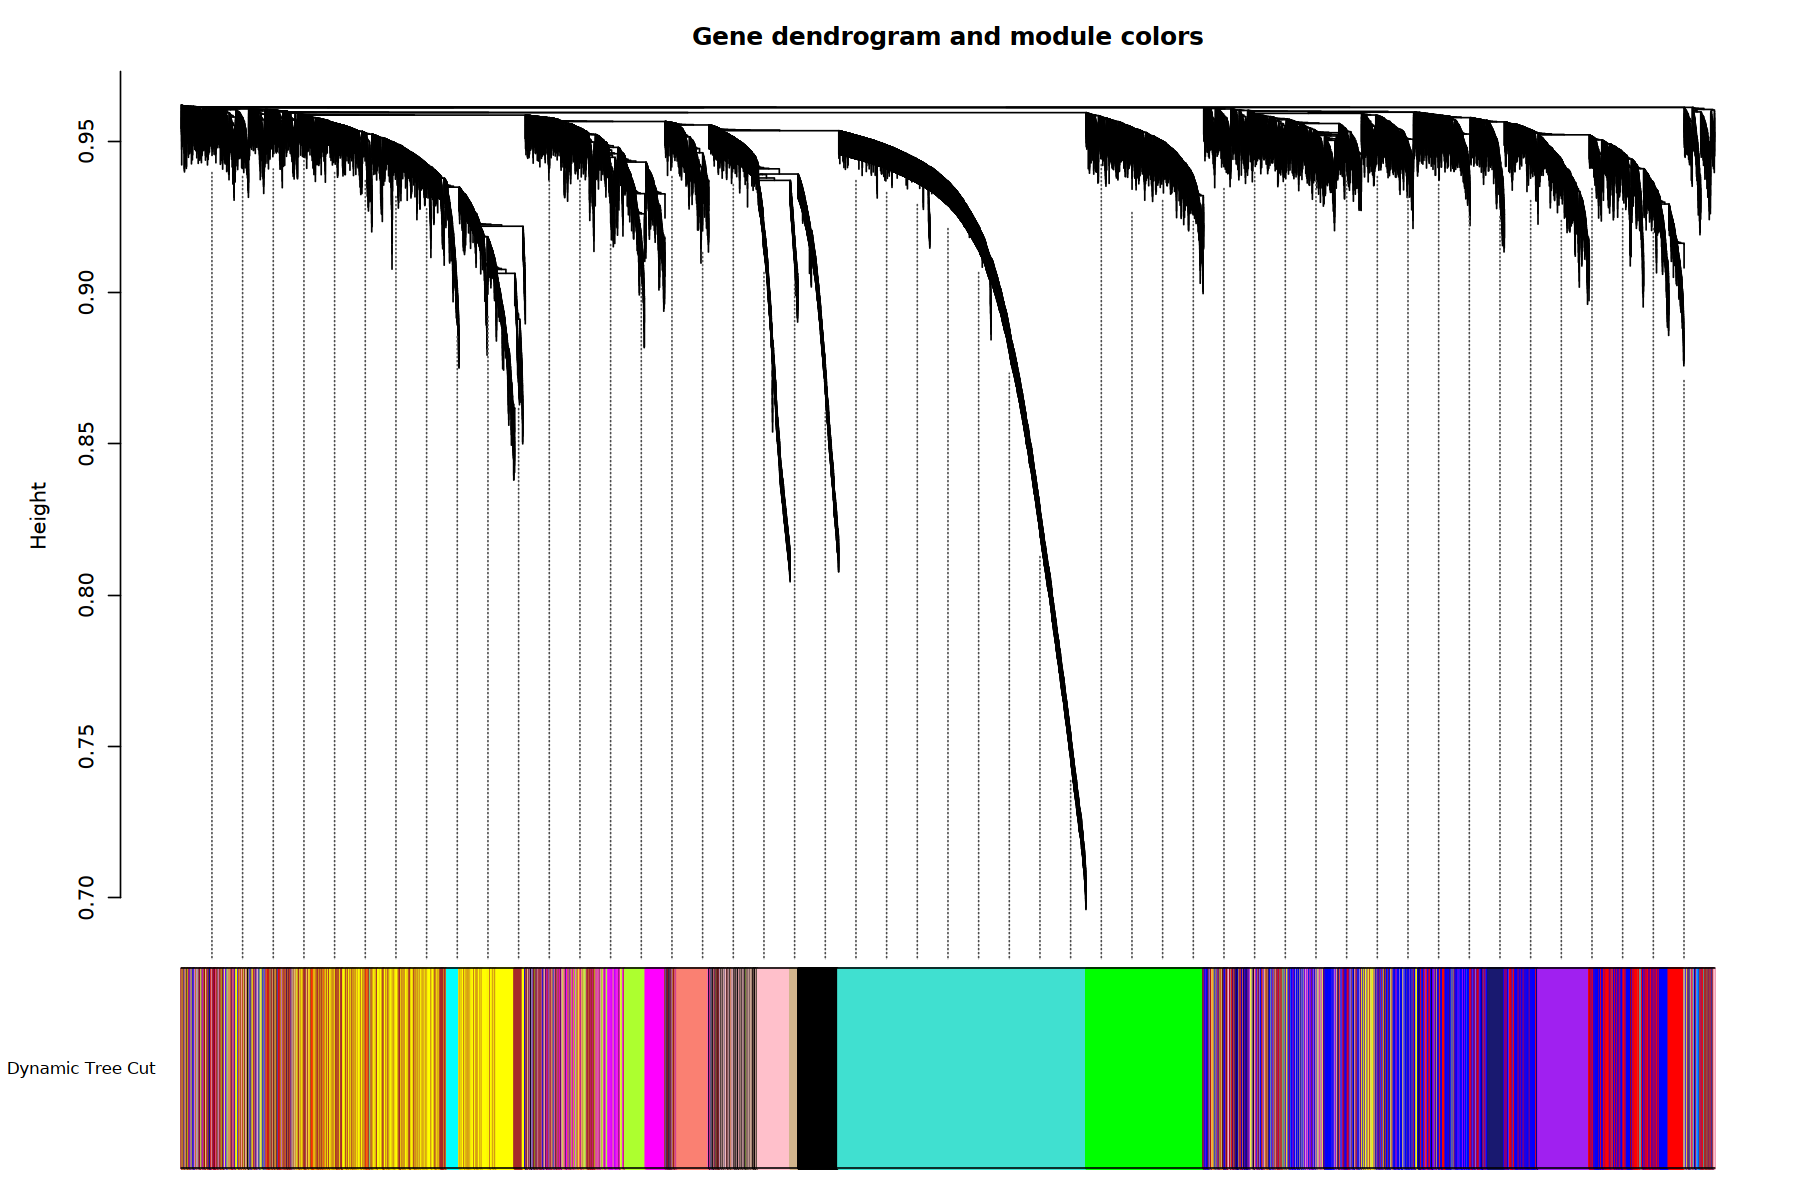

In [23]:
## SIGNED
# Convert numeric lables into colors
dynamicColors_sign <- labels2colors(dynamicMods_sign)
table(dynamicColors_sign)

# Plot the dendrogram and colors underneath
plotDendroAndColors(geneTree_sign, dynamicColors_sign, "Dynamic Tree Cut",
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05,
                    main = "Gene dendrogram and module colors")


### F. merging modules whose GE profiles are similar

this is based on eigengenes, which is the first principal component of a given a gene expression matrix/module that acts as a representative summary profile for a gene module or cluster

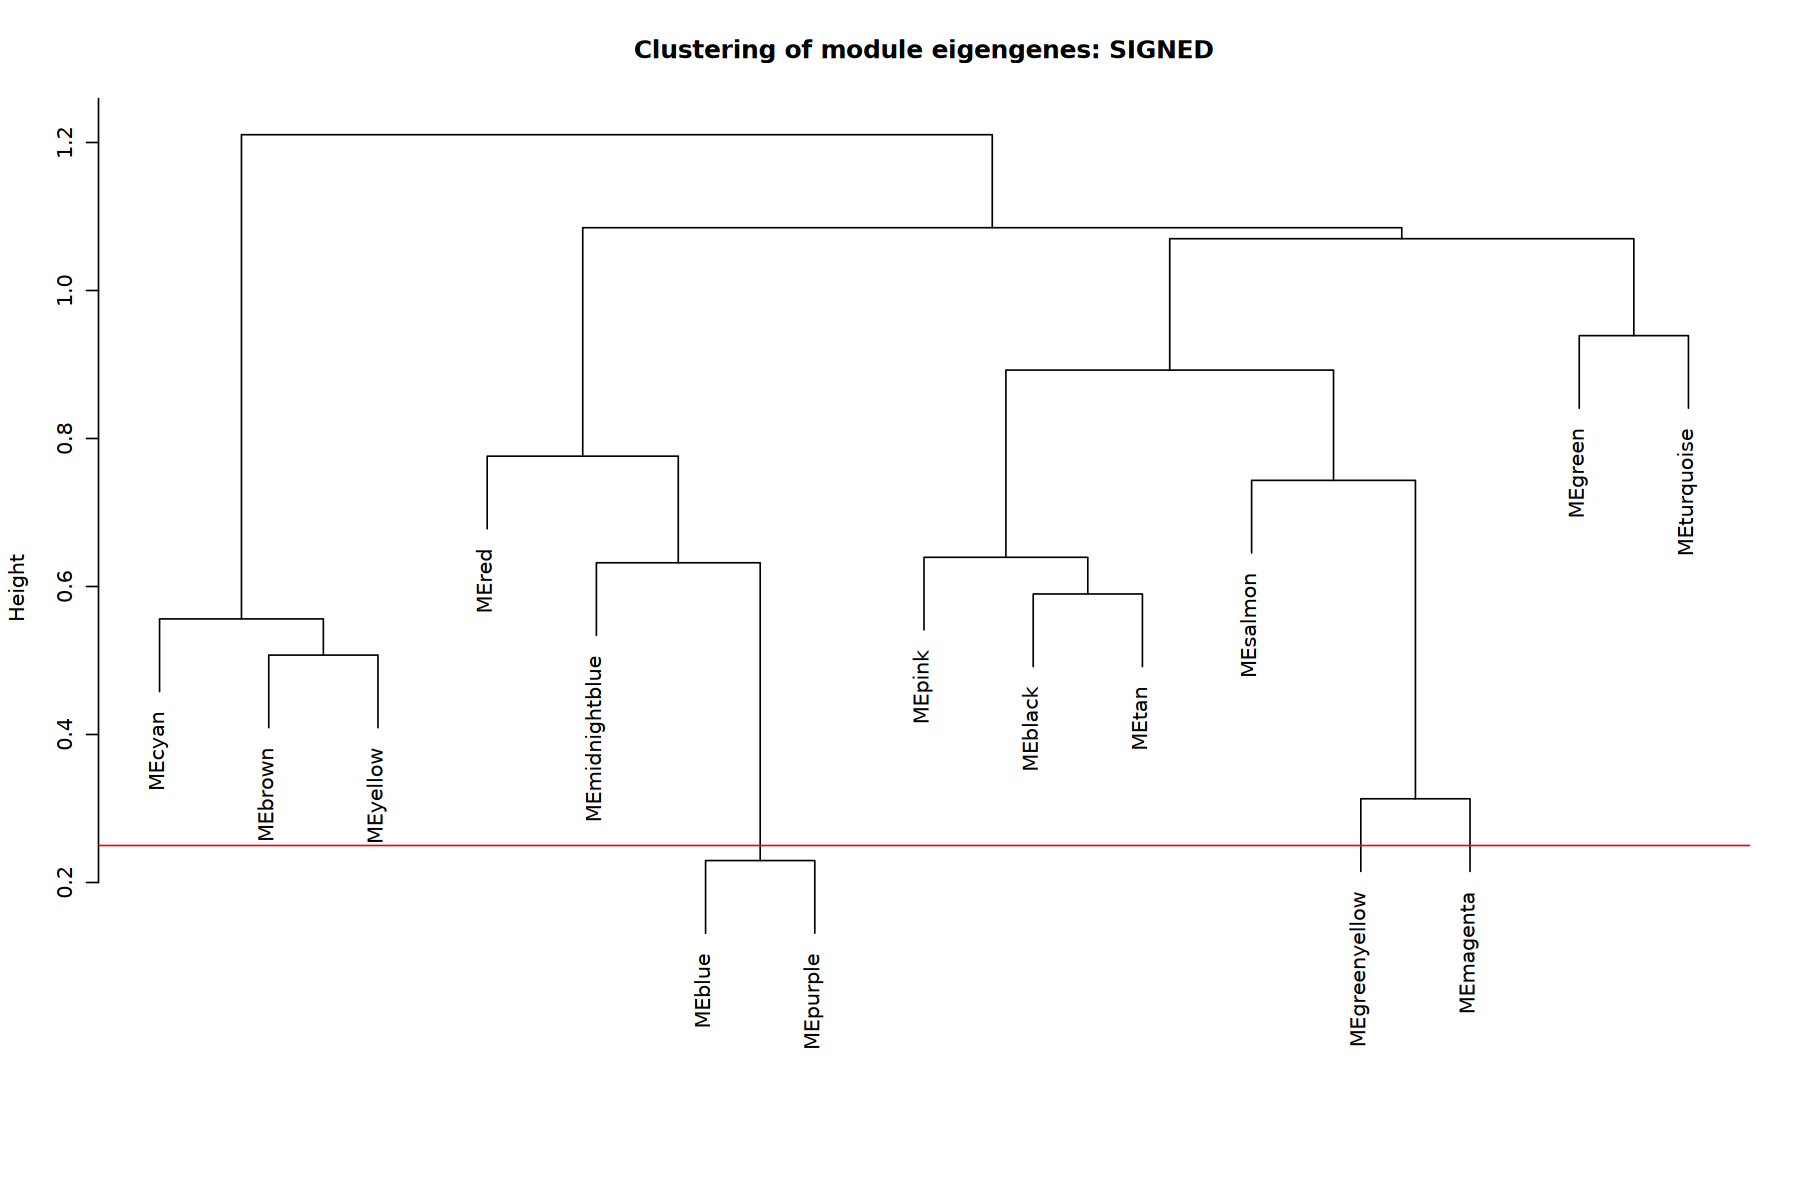

In [24]:
## SIGNED
# Calculate eigengenes
MEList_sign <- moduleEigengenes(dataExpr, colors = dynamicColors_sign)
MEs_sign <- MEList_sign$eigengenes

# Calculate dissimilarity of module eigengenes
MEDiss_sign <- 1-cor(MEs_sign)

# Cluster module eigengenes
METree_sign <- hclust(as.dist(MEDiss_sign), method = "average")

# Plot the result

# height cutoff of 0.25 - corresponds to a correlation of 0.75 to merge
MEDissThres <- 0.25

# Plot the cut line into the dendrogram
plot(METree_sign, main = "Clustering of module eigengenes: SIGNED", xlab = "", sub = "")
abline(h=MEDissThres, col = "red")

any branch with more than 75% correlation are related and will be merged - so blue and purple modules will be merged

 mergeCloseModules: Merging modules whose distance is less than 0.25
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 15 module eigengenes in given set.
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 14 module eigengenes in given set.
   Calculating new MEs...
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 14 module eigengenes in given set.


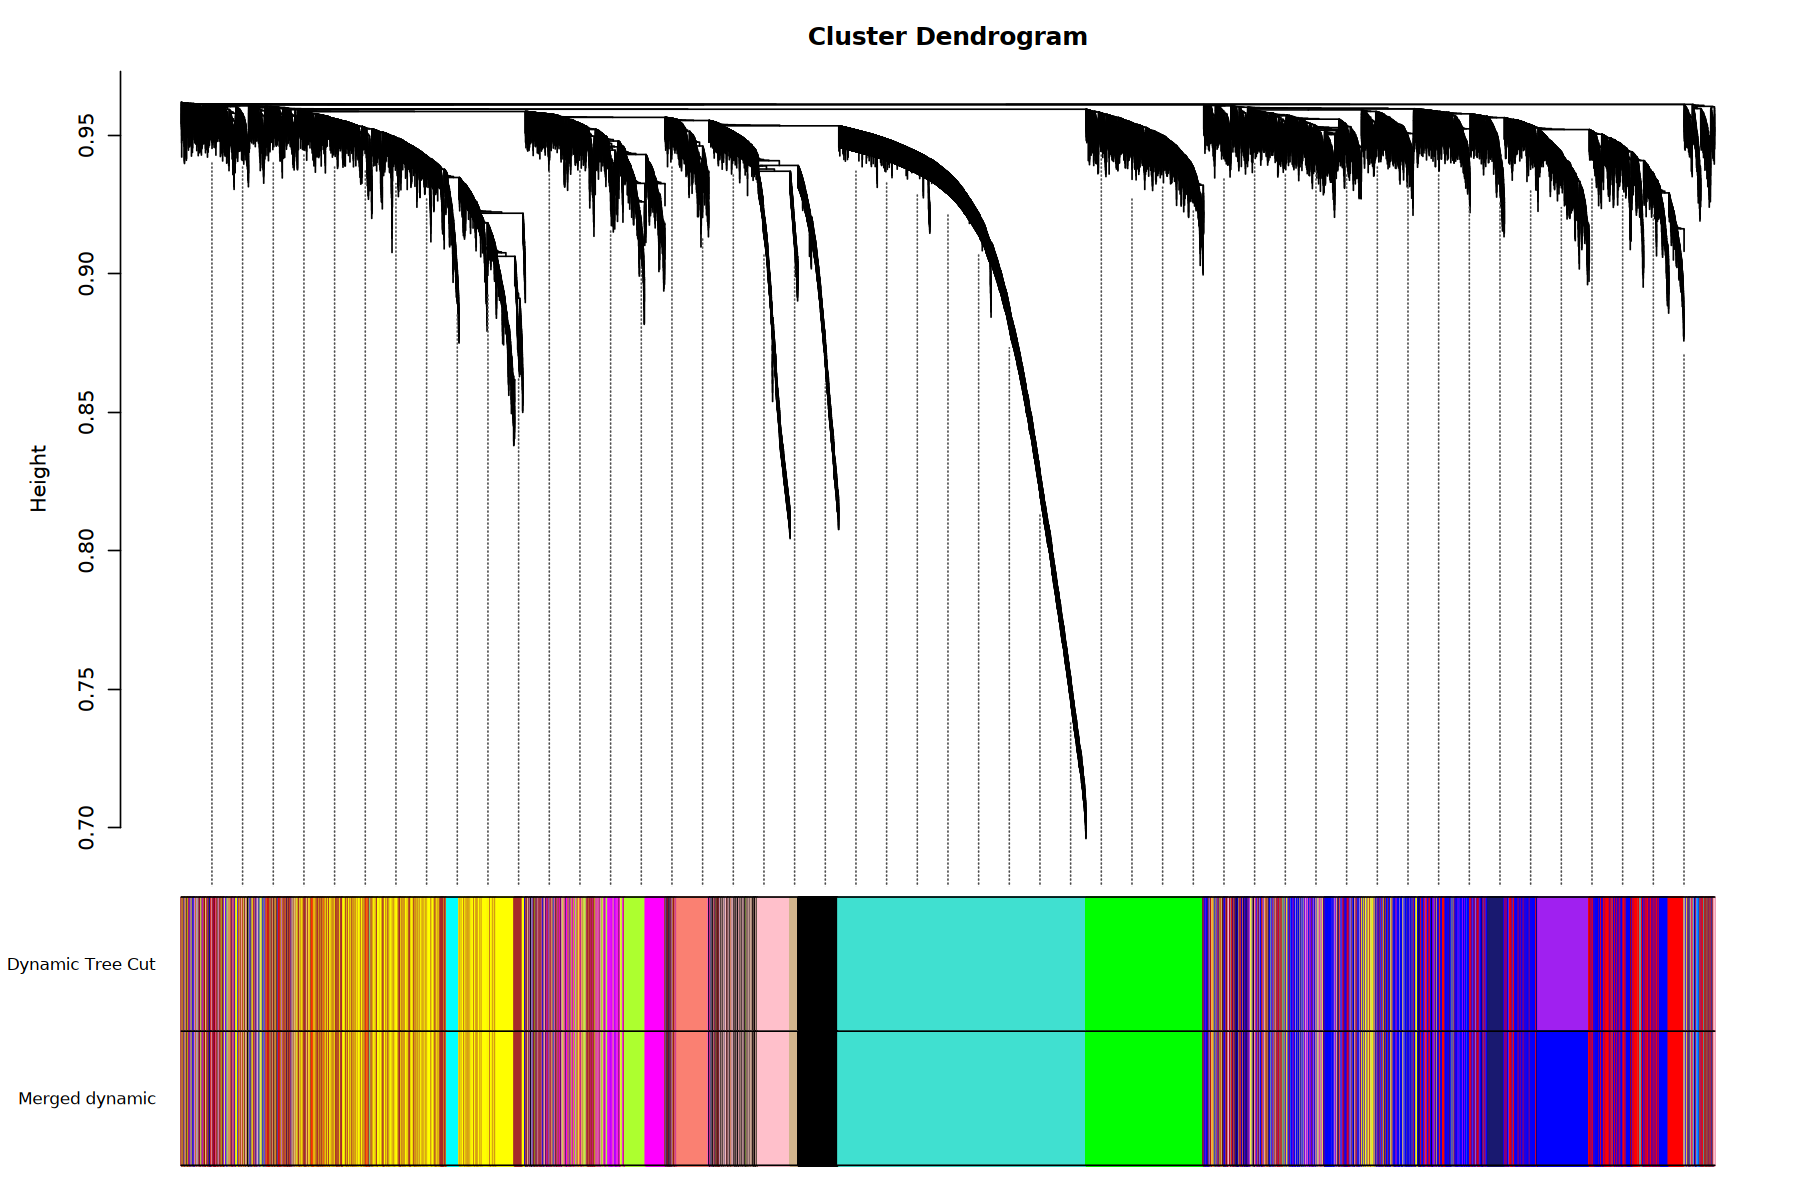

In [25]:
## SIGNED
# Call an automatic merging function
merge_sign <- mergeCloseModules(dataExpr, dynamicColors_sign, cutHeight = MEDissThres, verbose = 3)

# The merged module colors
mergedColors_sign <- merge_sign$colors

# Eigengenes of the new merged modules:
mergedMEs_sign <- merge_sign$newMEs

# plot merged module colors
plotDendroAndColors(geneTree_sign, cbind(dynamicColors_sign, mergedColors_sign), 
                    c("Dynamic Tree Cut", "Merged dynamic"),
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05)

In [26]:
table(mergedColors_sign)

mergedColors_sign
       black         blue        brown         cyan        green  greenyellow 
        1677         4781         3321          349         2037          777 
     magenta midnightblue         pink          red       salmon          tan 
        1100          282         1629         1975          542          544 
   turquoise       yellow 
        4323         3210 

14 co-expression modules with between 349 and 4781 genes

## 3. quantifying module-trait associations
identify modules that are significantly associated with treatment exposures or measured traits (like growth)

### A. read in and format metadata

both treatment metadata and growth data

In [27]:
# read in phase info
dataMeta <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/metaData/sample_metaData.csv')

# keep only samples seen in dataExpr
dataMeta <- dataMeta[dataMeta$Sample %in% rownames(dataExpr),]

# create combo trtmt column
dataMeta$combo_trtmt <- paste0(dataMeta$Phase1_treatment, '_', dataMeta$Phase2_treatment)

# check it out
dim(dataMeta)
head(dataMeta)


[1] 93 10

Sample    Phase1_treatment Phase1_temp Phase1_DO Phase1_TankRep
1 B1_B1_O01 both             warm        hypoxic   1             
3 B1_W5_O50 both             warm        hypoxic   1             
4 B2_B5_O51 both             warm        hypoxic   2             
5 B2_C4_O40 both             warm        hypoxic   2             
7 B3_B4_O41 both             warm        hypoxic   3             
8 B3_C3_O30 both             warm        hypoxic   3             
  Phase2_treatment Phase2_temp Phase2_DO Phase2_TankRep combo_trtmt 
1 both             warm        hypoxic   1              both_both   
3 warm             warm        normoxic  5              both_warm   
4 both             warm        hypoxic   5              both_both   
5 control          ambient     normoxic  4              both_control
7 both             warm        hypoxic   4              both_both   
8 control          ambient     normoxic  3              both_control

values have to be numerical, so going to create a code for my treatments:

#### phase 1 and 2 treatments
1. control
2. warm
3. hypoxic
4. both

#### temperature
1. ambient
2. warm

#### dissolved oxygen
1. normoxic
2. hypoxic

In [28]:
# set factors
dataMeta$Phase1_treatment <- factor(dataMeta$Phase1_treatment, c('control', 'warm', 'hypoxic', 'both'))
dataMeta$Phase1_temp <- factor(dataMeta$Phase1_temp, c('ambient', 'warm'))
dataMeta$Phase1_DO <- factor(dataMeta$Phase1_DO, c('normoxic', 'hypoxic'))

dataMeta$Phase2_treatment <- factor(dataMeta$Phase2_treatment, c('control', 'warm', 'hypoxic', 'both'))
dataMeta$Phase2_temp <- factor(dataMeta$Phase2_temp, c('ambient', 'warm'))
dataMeta$Phase2_DO <- factor(dataMeta$Phase2_DO, c('normoxic', 'hypoxic'))

# convert categorical to numerical code for treatment info
### PHASE 1
dataMeta$P1_trtmt_code <- as.numeric(factor(dataMeta$Phase1_treatment))
dataMeta$P1_temp_code <- as.numeric(factor(dataMeta$Phase1_temp))
dataMeta$P1_DO_code <- as.numeric(factor(dataMeta$Phase1_DO))
### PHASE 2
dataMeta$P2_trtmt_code <- as.numeric(factor(dataMeta$Phase2_treatment))
dataMeta$P2_temp_code <- as.numeric(factor(dataMeta$Phase2_temp))
dataMeta$P2_DO_code <- as.numeric(factor(dataMeta$Phase2_DO))

# select only columns needed
metaData <- dataMeta[,-c(2:10)]

# set sample names as rownames
rownames(metaData) <- metaData$Sample
metaData <- metaData %>% select(-Sample)

head(metaData)


P1_trtmt_code P1_temp_code P1_DO_code P2_trtmt_code P2_temp_code
B1_B1_O01 4             2            2          4             2           
B1_W5_O50 4             2            2          2             2           
B2_B5_O51 4             2            2          4             2           
B2_C4_O40 4             2            2          1             1           
B3_B4_O41 4             2            2          4             2           
B3_C3_O30 4             2            2          1             1           
          P2_DO_code
B1_B1_O01 2         
B1_W5_O50 1         
B2_B5_O51 2         
B2_C4_O40 1         
B3_B4_O41 2         
B3_C3_O30 1

could also add growth data to this:

In [29]:
p2_growth <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/metaData/growth_phase2.1_weights.csv')

# add leading zeros to single digit tag num
p2_growth$Tag_num <- sprintf("%02d", p2_growth$Tag_num)

# make sample names same as my convention
p1_str <- str_sub(p2_growth$Phase_1_treat, 1, 1)
p2_str <- str_sub(p2_growth$Phase_2_treat, 1, 1)
p2_growth$Sample <- paste0(p1_str, p2_growth$Phase_1_rep, '_', p2_str, p2_growth$Phase_2_rep, '_', p2_growth$Tag_color, p2_growth$Tag_num)
head(p2_growth$Sample)

# pull out growth data for matching samples
p2_growth.df <- p2_growth[p2_growth$Sample %in% rownames(metaData), ]

# check it out
dim(p2_growth.df) # 91 samples
dim(metaData) # 93 samples

[1] "B1_B1_O01" "B1_B1_O02" "B1_B2_O13" "B1_B2_O14" "B1_B3_O25" "B1_B3_O26"

[1] 91 33

[1] 93  6

In [30]:
metaData[!rownames(metaData) %in% p2_growth.df$Sample,]

P1_trtmt_code P1_temp_code P1_DO_code P2_trtmt_code P2_temp_code
C_W5_W52  1             1            1          2             2           
W2_B2_G04 2             2            1          4             2           
          P2_DO_code
C_W5_W52  1         
W2_B2_G04 2

In [31]:
head(dataMeta)

Sample    Phase1_treatment Phase1_temp Phase1_DO Phase1_TankRep
1 B1_B1_O01 both             warm        hypoxic   1             
3 B1_W5_O50 both             warm        hypoxic   1             
4 B2_B5_O51 both             warm        hypoxic   2             
5 B2_C4_O40 both             warm        hypoxic   2             
7 B3_B4_O41 both             warm        hypoxic   3             
8 B3_C3_O30 both             warm        hypoxic   3             
  Phase2_treatment Phase2_temp Phase2_DO Phase2_TankRep combo_trtmt 
1 both             warm        hypoxic   1              both_both   
3 warm             warm        normoxic  5              both_warm   
4 both             warm        hypoxic   5              both_both   
5 control          ambient     normoxic  4              both_control
7 both             warm        hypoxic   4              both_both   
8 control          ambient     normoxic  3              both_control
  P1_trtmt_code P1_temp_code P1_DO_code P2_trtmt_code P2_temp_code P2_DO_code
1 4             2            2          4             2            2         
3 4             2            2          2             2            1         
4 4             2            2          4             2            2         
5 4             2            2          1             1            1         
7 4             2            2          4             2            2         
8 4             2            2          1             1            1

i think C_W5_W52 should be **C2_W5_W52** actually and W2_B2_G04 should be **W2_B1_G04**

changing the names in both metaData and dataExpr 

In [32]:
rownames(dataMeta) <- dataMeta$Sample

# add missing rep number to sample name
rownames(dataExpr)[rownames(dataExpr) == 'C_W5_W52'] <- 'C2_W5_W52'
rownames(metaData)[rownames(metaData) == 'C_W5_W52'] <- 'C2_W5_W52'
rownames(dataMeta)[rownames(dataMeta) == 'C_W5_W52'] <- 'C2_W5_W52'

# fix wrong rep number to sample name
rownames(dataExpr)[rownames(dataExpr) == 'W2_B2_G04'] <- 'W2_B1_G04'
rownames(metaData)[rownames(metaData) == 'W2_B2_G04'] <- 'W2_B1_G04'
rownames(dataMeta)[rownames(dataMeta) == 'W2_B2_G04'] <- 'W2_B1_G04'

pulling out the growth data now - should be the same number of samples ...

In [33]:
# pull out growth data for matching samples
p2_growth.df2 <- p2_growth[p2_growth$Sample %in% rownames(metaData), ]

# check it out
dim(p2_growth.df2) # 93 samples
dim(metaData) # 93 samples

[1] 93 33

[1] 93  6

so all good now with matching sample names!

now pulling out only the growth columns and merging with the other meta data df 

In [34]:
# select growth columns
p2_growth.df2 <- p2_growth.df2 %>%
select(Sample, Actual_shell_growth_mg, Actual_tissue_growth_mg, Ratio_tissue_shell_mg)

# sample is the rowname
rownames(p2_growth.df2) <- p2_growth.df2$Sample
p2_growth.df2 <- p2_growth.df2 %>% select(-Sample)


head(p2_growth.df2)

Actual_shell_growth_mg Actual_tissue_growth_mg Ratio_tissue_shell_mg
B1_B1_O01 210.2755               120.72448               0.574125224          
B1_W5_O50 315.8883                85.61170               0.271018901          
B2_B5_O51 114.3215                44.47852               0.389065292          
B2_C4_O40 164.9903                55.10972               0.33401798           
B3_B4_O41 197.9250               116.17500               0.586964759          
B3_C3_O30 316.0466               241.35336               0.763663743

In [35]:
# merge dfs
metaData_merge <- merge(p2_growth.df2, metaData, by = 'row.names')

# set samples as rownames
metaData_merge <- metaData_merge %>% 
column_to_rownames(var = 'Row.names')

dim(metaData_merge)
head(metaData_merge)

[1] 93  9

Actual_shell_growth_mg Actual_tissue_growth_mg Ratio_tissue_shell_mg
B1_B1_O01 210.2755               120.72448               0.574125224          
B1_W5_O50 315.8883                85.61170               0.271018901          
B2_B5_O51 114.3215                44.47852               0.389065292          
B2_C4_O40 164.9903                55.10972               0.33401798           
B3_B4_O41 197.9250               116.17500               0.586964759          
B3_C3_O30 316.0466               241.35336               0.763663743          
          P1_trtmt_code P1_temp_code P1_DO_code P2_trtmt_code P2_temp_code
B1_B1_O01 4             2            2          4             2           
B1_W5_O50 4             2            2          2             2           
B2_B5_O51 4             2            2          4             2           
B2_C4_O40 4             2            2          1             1           
B3_B4_O41 4             2            2          4             2           
B3_C3_O30 4             2            2          1             1           
          P2_DO_code
B1_B1_O01 2         
B1_W5_O50 1         
B2_B5_O51 2         
B2_C4_O40 1         
B3_B4_O41 2         
B3_C3_O30 1

In [36]:
# define # of genes and samples
nSamples <- nrow(dataExpr) # 93 samples
nGenes <- ncol(dataExpr) # 26,547 genes

eigengene ~ summary profile of the module

now can correlate eigengenes with external traits and look for most significant associations

In [37]:
# reorder columns
metaData_merge <- metaData_merge %>%
select(Actual_shell_growth_mg, Actual_tissue_growth_mg, Ratio_tissue_shell_mg, P1_trtmt_code, P2_trtmt_code, P1_temp_code, P2_temp_code, P1_DO_code, P2_DO_code)

dim(metaData_merge)
head(metaData_merge)

[1] 93  9

Actual_shell_growth_mg Actual_tissue_growth_mg Ratio_tissue_shell_mg
B1_B1_O01 210.2755               120.72448               0.574125224          
B1_W5_O50 315.8883                85.61170               0.271018901          
B2_B5_O51 114.3215                44.47852               0.389065292          
B2_C4_O40 164.9903                55.10972               0.33401798           
B3_B4_O41 197.9250               116.17500               0.586964759          
B3_C3_O30 316.0466               241.35336               0.763663743          
          P1_trtmt_code P2_trtmt_code P1_temp_code P2_temp_code P1_DO_code
B1_B1_O01 4             4             2            2            2         
B1_W5_O50 4             2             2            2            2         
B2_B5_O51 4             4             2            2            2         
B2_C4_O40 4             1             2            1            2         
B3_B4_O41 4             4             2            2            2         
B3_C3_O30 4             1             2            1            2         
          P2_DO_code
B1_B1_O01 2         
B1_W5_O50 1         
B2_B5_O51 2         
B2_C4_O40 1         
B3_B4_O41 2         
B3_C3_O30 1

growth meaning the growth from the beginning of phase 2 to the end of phase 2 - we do not have data on these oysters' growth before and after phase 1. The ratio of tissue to shell growth is a proxy for fitness (more tissue = investing in reproduction, more shell = investing in defense)

In [38]:
# Recalculate MEs (module eigengenes) with color labels

MEs0 <- moduleEigengenes(dataExpr, mergedColors_sign)$eigengenes # create module eigengenes

MEs <- orderMEs(MEs0) # order so more similar modules are closer together

moduleTraitCor <- cor(MEs, metaData_merge, use = "p") # correlate with traits - using Pearson correlations

moduleTraitPvalue <- corPvalueStudent(moduleTraitCor, nSamples) # compute p-values - uses student's t-distribution

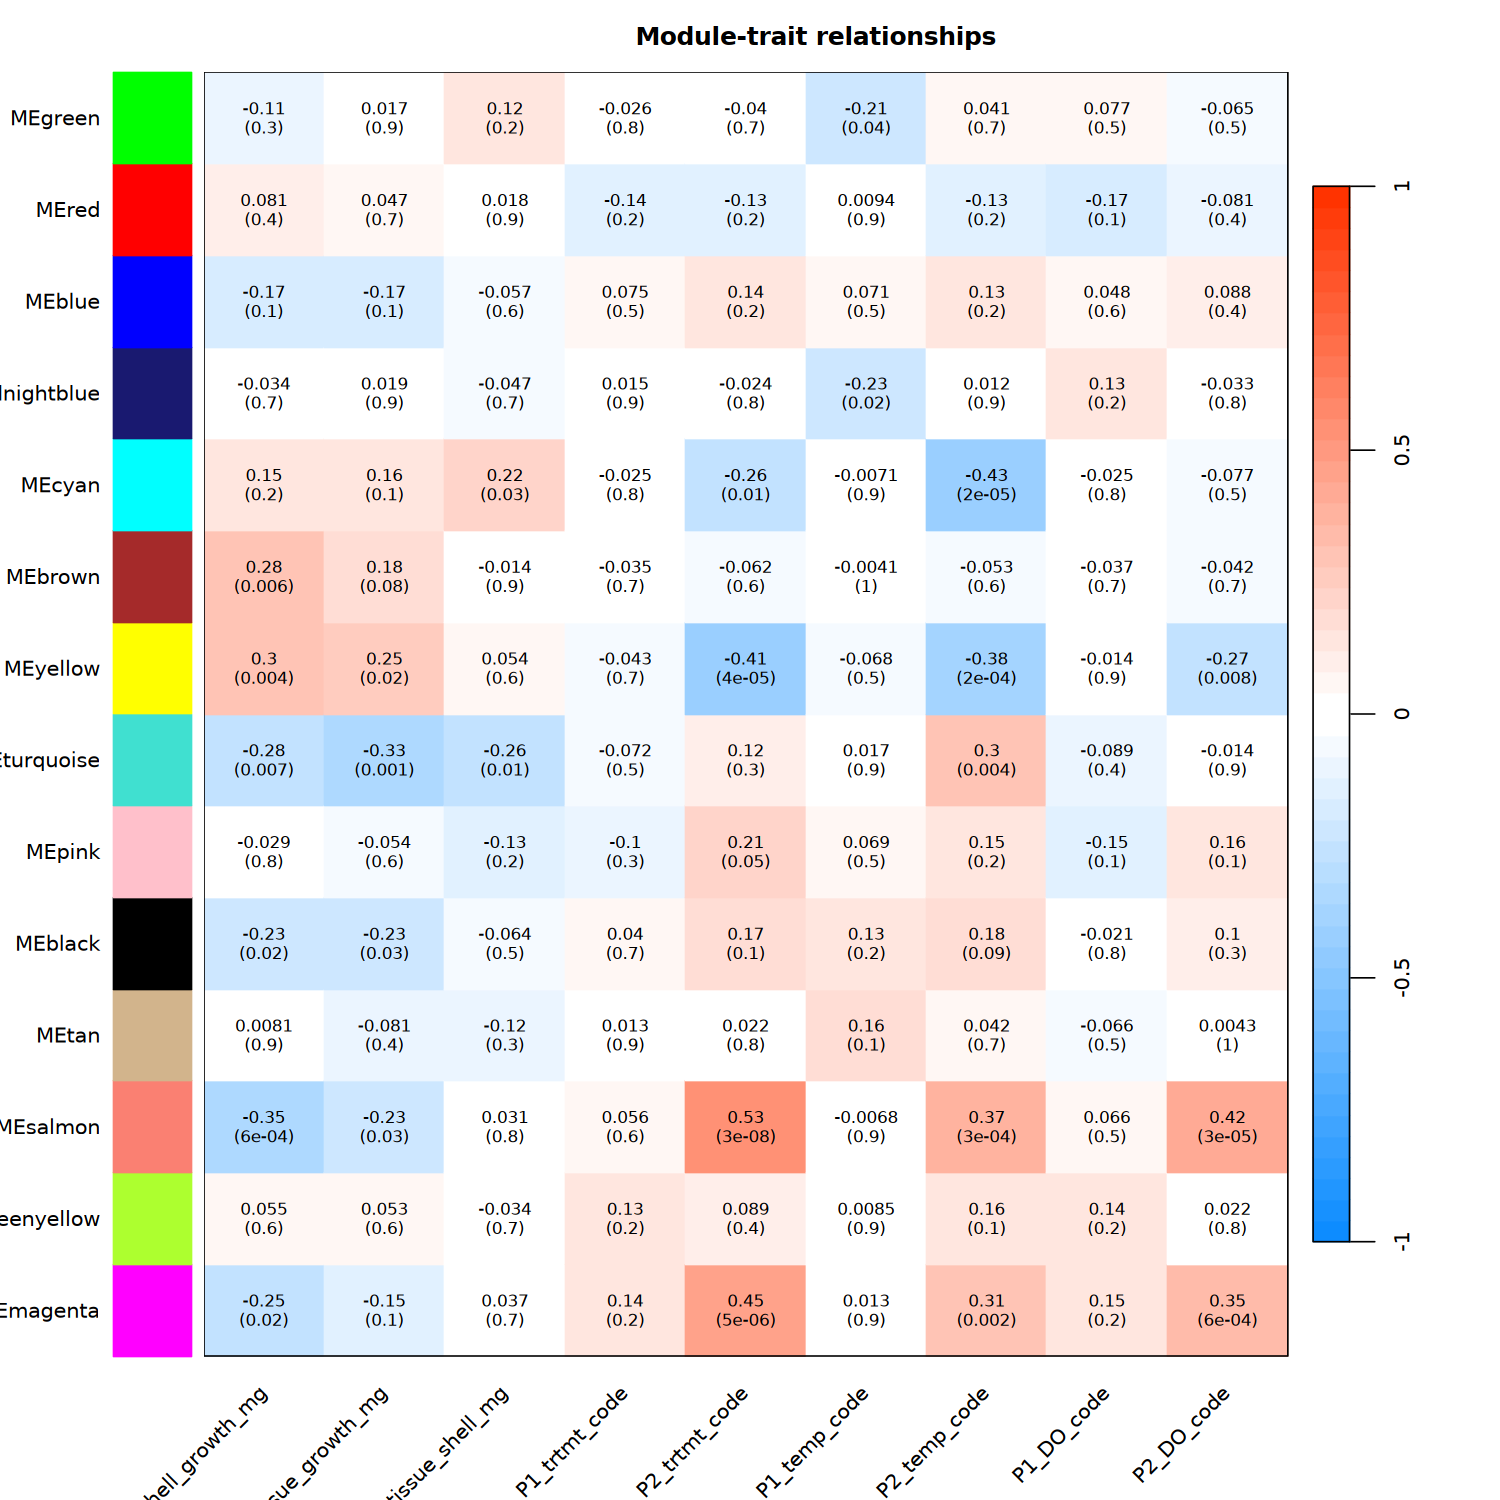

In [39]:
options(repr.plot.width = 12.5, repr.plot.height = 12.5)

# Will display correlations and their p-values
textMatrix = paste(signif(moduleTraitCor, 2), "\n(",
signif(moduleTraitPvalue, 1), ")", sep = "");
dim(textMatrix) = dim(moduleTraitCor)
par(mar = c(6, 8.5, 3, 3))

# Display the correlation values within a heatmap plot
labeledHeatmap(Matrix = moduleTraitCor, 
               xLabels = names(metaData_merge), 
               yLabels = names(MEs),
               ySymbols = names(MEs),
               colorLabels = FALSE,
               colors = blueWhiteRed(50),
               textMatrix = textMatrix,
               setStdMargins = FALSE,
               cex.text = 0.8,
               zlim = c(-1,1),
               main = paste("Module-trait relationships"))

each row corresponds to a module eigengene, column to a treatment

each cell contains the corresponding correlation and p-value and the table is colored by correlation (in my case, I've assigned numerical codes to categorical treatments, with the control/normoxic/ambient treatment always being 1)

red cells indicate positive correlation, blue cells a negative correlation - looking for dark cells with significant pvalues to identify module of interest

**specifically looking for...**:
- modules with opposing relationships between phase 1 and phase 2 (whether that's DO, temp, or treatment altogether; can also be growth as in red for tissue but blue for shell)
- modules with significant relationships (number within the paratheses)

**observations**:
- none of the modules have a significant relationship with p1_treatment or p1_DO, which makes sense since these samples were taken after p2 and we expect most GE to be short-term
    - there are 5 modules with a sig. relationship with p2_treatment (three red and two blue)
- there are 3 modules with a sig. relationship with a DO treatment (cols 8 and 9) and 7 modules with a significant relationship with a temp treatment (cols 6 and 7)
- there are a few modules with sig. relationships with tissue/shell growth, and they're in the same direction for tissue and shell
    - only 2 modules with a sig. relationship with the ratio of tissue to shell growth, one pos. and one neg.

based on this, **potentially interesting modules include**:
- for **P2_trtmt_code**: MEsalmon, MEmagent, MEyellow
- for **Actual_shell_growth_mg**: MEbrown, MEsalmon, MEturquoise
- for **Actual_tissue_growth_mg**: MEturquoise
- for **P1_Temp_code**: MEmidnightblue
- for **P2_Temp_code**: MEyellow, MEsalmon, MEcyan
- for **P2_DO_code**: MEyellow, MEsalmon, MEmagenta



In [40]:
# write csv to save the module eigengenes
# write.csv(MEs, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/wgcna/p2.wgcna_ModuleEigengenes.csv')

#### module-trait relationship splitting phase 1 and 2 treatments

In [41]:
MEs <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/wgcna/p2.wgcna_ModuleEigengenes.csv')
rownames(MEs) <- MEs$X

MEs <- MEs %>% select(-X)

head(MEs)

MEgreen     MEred        MEblue      MEmidnightblue MEcyan     
B1_B1_O01 -0.07267705  0.009714088  0.07436860  0.09833391    -0.02897813
B1_W5_O50  0.11259458 -0.111083731 -0.01475526  0.06474712     0.02224133
B2_B5_O51 -0.08984971 -0.182351212 -0.06468166  0.02734566     0.05313499
B2_C4_O40  0.10140997  0.079992546  0.04727654  0.09989979     0.05347520
B3_B4_O41  0.09981873 -0.152270648 -0.04321488  0.05547935     0.01493320
B3_C3_O30  0.13421227 -0.054919285 -0.22153019 -0.02394812     0.10739413
          MEbrown     MEyellow     MEturquoise  MEpink      MEblack    
B1_B1_O01 -0.08966684 -0.045985040 -0.057655106 -0.01372923  0.12300519
B1_W5_O50 -0.04285216  0.069049606  0.024580716 -0.06167656 -0.08471081
B2_B5_O51  0.01917650  0.071772224  0.053675425  0.01991438  0.18247916
B2_C4_O40 -0.07355731  0.008702442 -0.005810909 -0.04119296 -0.06401295
B3_B4_O41 -0.02548241  0.075045647  0.035097388 -0.02785136 -0.07482059
B3_C3_O30  0.13503628  0.107547430 -0.016895555 -0.03253327 -0.07544965
          MEtan        MEsalmon    MEgreenyellow MEmagenta    
B1_B1_O01 -0.008507769  0.03748471 -0.003100380   0.0569358089
B1_W5_O50 -0.060693622 -0.07017904  0.085117905   0.0008981644
B2_B5_O51  0.615392900 -0.03895601  0.135324346   0.1043639581
B2_C4_O40 -0.054877888 -0.10511121 -0.083771035  -0.1177197358
B3_B4_O41 -0.066988659 -0.04015863  0.090254076   0.0899543403
B3_C3_O30 -0.077105937 -0.04242012 -0.004583379  -0.0529921250

In [42]:
meta <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/wgcna/p2.wgcna_metadata.csv') %>%
select(-c(X, Phase1_TankRep, Phase2_TankRep, Actual_shell_growth_mg, Actual_tissue_growth_mg, Ratio_tissue_shell_mg)) %>% # remove cols we don't need like tank reps - not focusing on growth here either rn
distinct(Sample, .keep_all = TRUE) # at some point, rows got duplicated, so just keeping the distinct rows

# set rownames as sample names
rownames(meta) <- meta$Sample

# check out df
dim(meta)
head(meta)

[1] 93  8

Sample    Phase1_treatment Phase1_temp Phase1_DO Phase2_treatment
B1_B1_O01 B1_B1_O01 both             warm        hypoxic   both            
B1_W5_O50 B1_W5_O50 both             warm        hypoxic   warm            
B2_B5_O51 B2_B5_O51 both             warm        hypoxic   both            
B2_C4_O40 B2_C4_O40 both             warm        hypoxic   control         
B3_B4_O41 B3_B4_O41 both             warm        hypoxic   both            
B3_C3_O30 B3_C3_O30 both             warm        hypoxic   control         
          Phase2_temp Phase2_DO combo_trtmt 
B1_B1_O01 warm        hypoxic   both_both   
B1_W5_O50 warm        normoxic  both_warm   
B2_B5_O51 warm        hypoxic   both_both   
B2_C4_O40 ambient     normoxic  both_control
B3_B4_O41 warm        hypoxic   both_both   
B3_C3_O30 ambient     normoxic  both_control

In [108]:
# add factors
meta$Phase1_DO <- factor(meta$Phase1_DO, c('normoxic', 'hypoxic'))
meta$Phase2_DO <- factor(meta$Phase2_DO, c('normoxic', 'hypoxic'))
meta$Phase1_temp <- factor(meta$Phase1_temp, c('ambient', 'warm'))
meta$Phase2_temp <- factor(meta$Phase2_temp, c('ambient', 'warm'))

will want to create dummy variables for WGCNA - basically 0/1 to denate yes or no to a treatment

In [109]:
# creating dummy variables

#### PHASE 1 ####
# phase 1 treatments
phase1.treatments <- meta %>%
  select(Sample, Phase1_treatment) %>%
  mutate(value = 1) %>%
  pivot_wider(
    id_cols = Sample,
    names_from = Phase1_treatment,
    values_from = value,
    values_fill = list(value = 0)
  )

head(phase1.treatments)

# phase 1 DO
phase1.DO <- meta %>%
  select(Sample, Phase1_DO) %>%
  mutate(value = 1) %>%
  pivot_wider(
    id_cols = Sample,
    names_from = Phase1_DO,
    values_from = value,
    values_fill = list(value = 0)
  )

# phase 1 temperature
phase1.temp <- meta %>%
  select(Sample, Phase1_temp) %>%
  mutate(value = 1) %>%
  pivot_wider(
    id_cols = Sample,
    names_from = Phase1_temp,
    values_from = value,
    values_fill = list(value = 0)
  )


#### PHASE 2 ####
# phase 2 treatments
phase2.treatments <- meta %>%
  select(Sample, Phase2_treatment) %>%
  mutate(value = 1) %>%
  pivot_wider(
    id_cols = Sample,
    names_from = Phase2_treatment,
    values_from = value,
    values_fill = list(value = 0)
  )

# phase 2 DO
phase2.DO <- meta %>%
  select(Sample, Phase2_DO) %>%
  mutate(value = 1) %>%
  pivot_wider(
    id_cols = Sample,
    names_from = Phase2_DO,
    values_from = value,
    values_fill = list(value = 0)
  )

# phase 2 temperature
phase2.temp <- meta %>%
  select(Sample, Phase2_temp) %>%
  mutate(value = 1) %>%
  pivot_wider(
    id_cols = Sample,
    names_from = Phase2_temp,
    values_from = value,
    values_fill = list(value = 0)
  )

head(phase2.DO)

#### P1/P2 COMBO ####
combo.treatments <- meta %>%
  select(Sample, combo_trtmt) %>%
  mutate(value = 1) %>%
  pivot_wider(
    id_cols = Sample,
    names_from = combo_trtmt,
    values_from = value,
    values_fill = list(value = 0)
  )

head(combo.treatments)

Sample    both control hypoxic warm
1 B1_B1_O01 1    0       0       0   
2 B1_W5_O50 1    0       0       0   
3 B2_B5_O51 1    0       0       0   
4 B2_C4_O40 1    0       0       0   
5 B3_B4_O41 1    0       0       0   
6 B3_C3_O30 1    0       0       0

Sample    hypoxic normoxic
1 B1_B1_O01 1       0       
2 B1_W5_O50 0       1       
3 B2_B5_O51 1       0       
4 B2_C4_O40 0       1       
5 B3_B4_O41 1       0       
6 B3_C3_O30 0       1

Sample    both_both both_warm both_control both_hypoxic control_control
1 B1_B1_O01 1         0         0            0            0              
2 B1_W5_O50 0         1         0            0            0              
3 B2_B5_O51 1         0         0            0            0              
4 B2_C4_O40 0         0         1            0            0              
5 B3_B4_O41 1         0         0            0            0              
6 B3_C3_O30 0         0         1            0            0              
  control_hypoxic control_both control_warm hypoxic_both hypoxic_control
1 0               0            0            0            0              
2 0               0            0            0            0              
3 0               0            0            0            0              
4 0               0            0            0            0              
5 0               0            0            0            0              
6 0               0            0            0            0              
  hypoxic_warm hypoxic_hypoxic warm_control warm_hypoxic warm_warm warm_both
1 0            0               0            0            0         0        
2 0            0               0            0            0         0        
3 0            0               0            0            0         0        
4 0            0               0            0            0         0        
5 0            0               0            0            0         0        
6 0            0               0            0            0         0

In [110]:
nSamples <- nrow(dataExpr) # 93 samples
nGenes <- ncol(dataExpr) # 26547 genes

In [111]:
# module trait correlation

## PHASE 1 ##
# phase 1 treatment
moduleTraitCor_p1 = cor(MEs, phase1.treatments[-1], use = "p")
moduleTraitPvalue_p1 = corPvalueStudent(moduleTraitCor_p1, nSamples)

# phase 1 DO
moduleTraitCor_p1.DO = cor(MEs, phase1.DO[-1], use = "p")
moduleTraitPvalue_p1.DO = corPvalueStudent(moduleTraitCor_p1.DO, nSamples)

# phase 1 temp
moduleTraitCor_p1.temp = cor(MEs, phase1.temp[-1], use = "p")
moduleTraitPvalue_p1.temp = corPvalueStudent(moduleTraitCor_p1.temp, nSamples)

## PHASE 2 ##
# phase 2 treatment
moduleTraitCor_p2 = cor(MEs, phase2.treatments[-1], use = "p")
moduleTraitPvalue_p2 = corPvalueStudent(moduleTraitCor_p2, nSamples)

# phase 2 DO
moduleTraitCor_p2.DO = cor(MEs, phase2.DO[-1], use = "p")
moduleTraitPvalue_p2.DO = corPvalueStudent(moduleTraitCor_p2.DO, nSamples)

# phase 2 temp
moduleTraitCor_p2.temp = cor(MEs, phase2.temp[-1], use = "p")
moduleTraitPvalue_p2.temp = corPvalueStudent(moduleTraitCor_p2.temp, nSamples)

## P1/P2 COMBO ##
moduleTraitCor_combo = cor(MEs, combo.treatments[-1], use = "p")
moduleTraitPvalue_combo = corPvalueStudent(moduleTraitCor_combo, nSamples)

#### phase 1 treatments

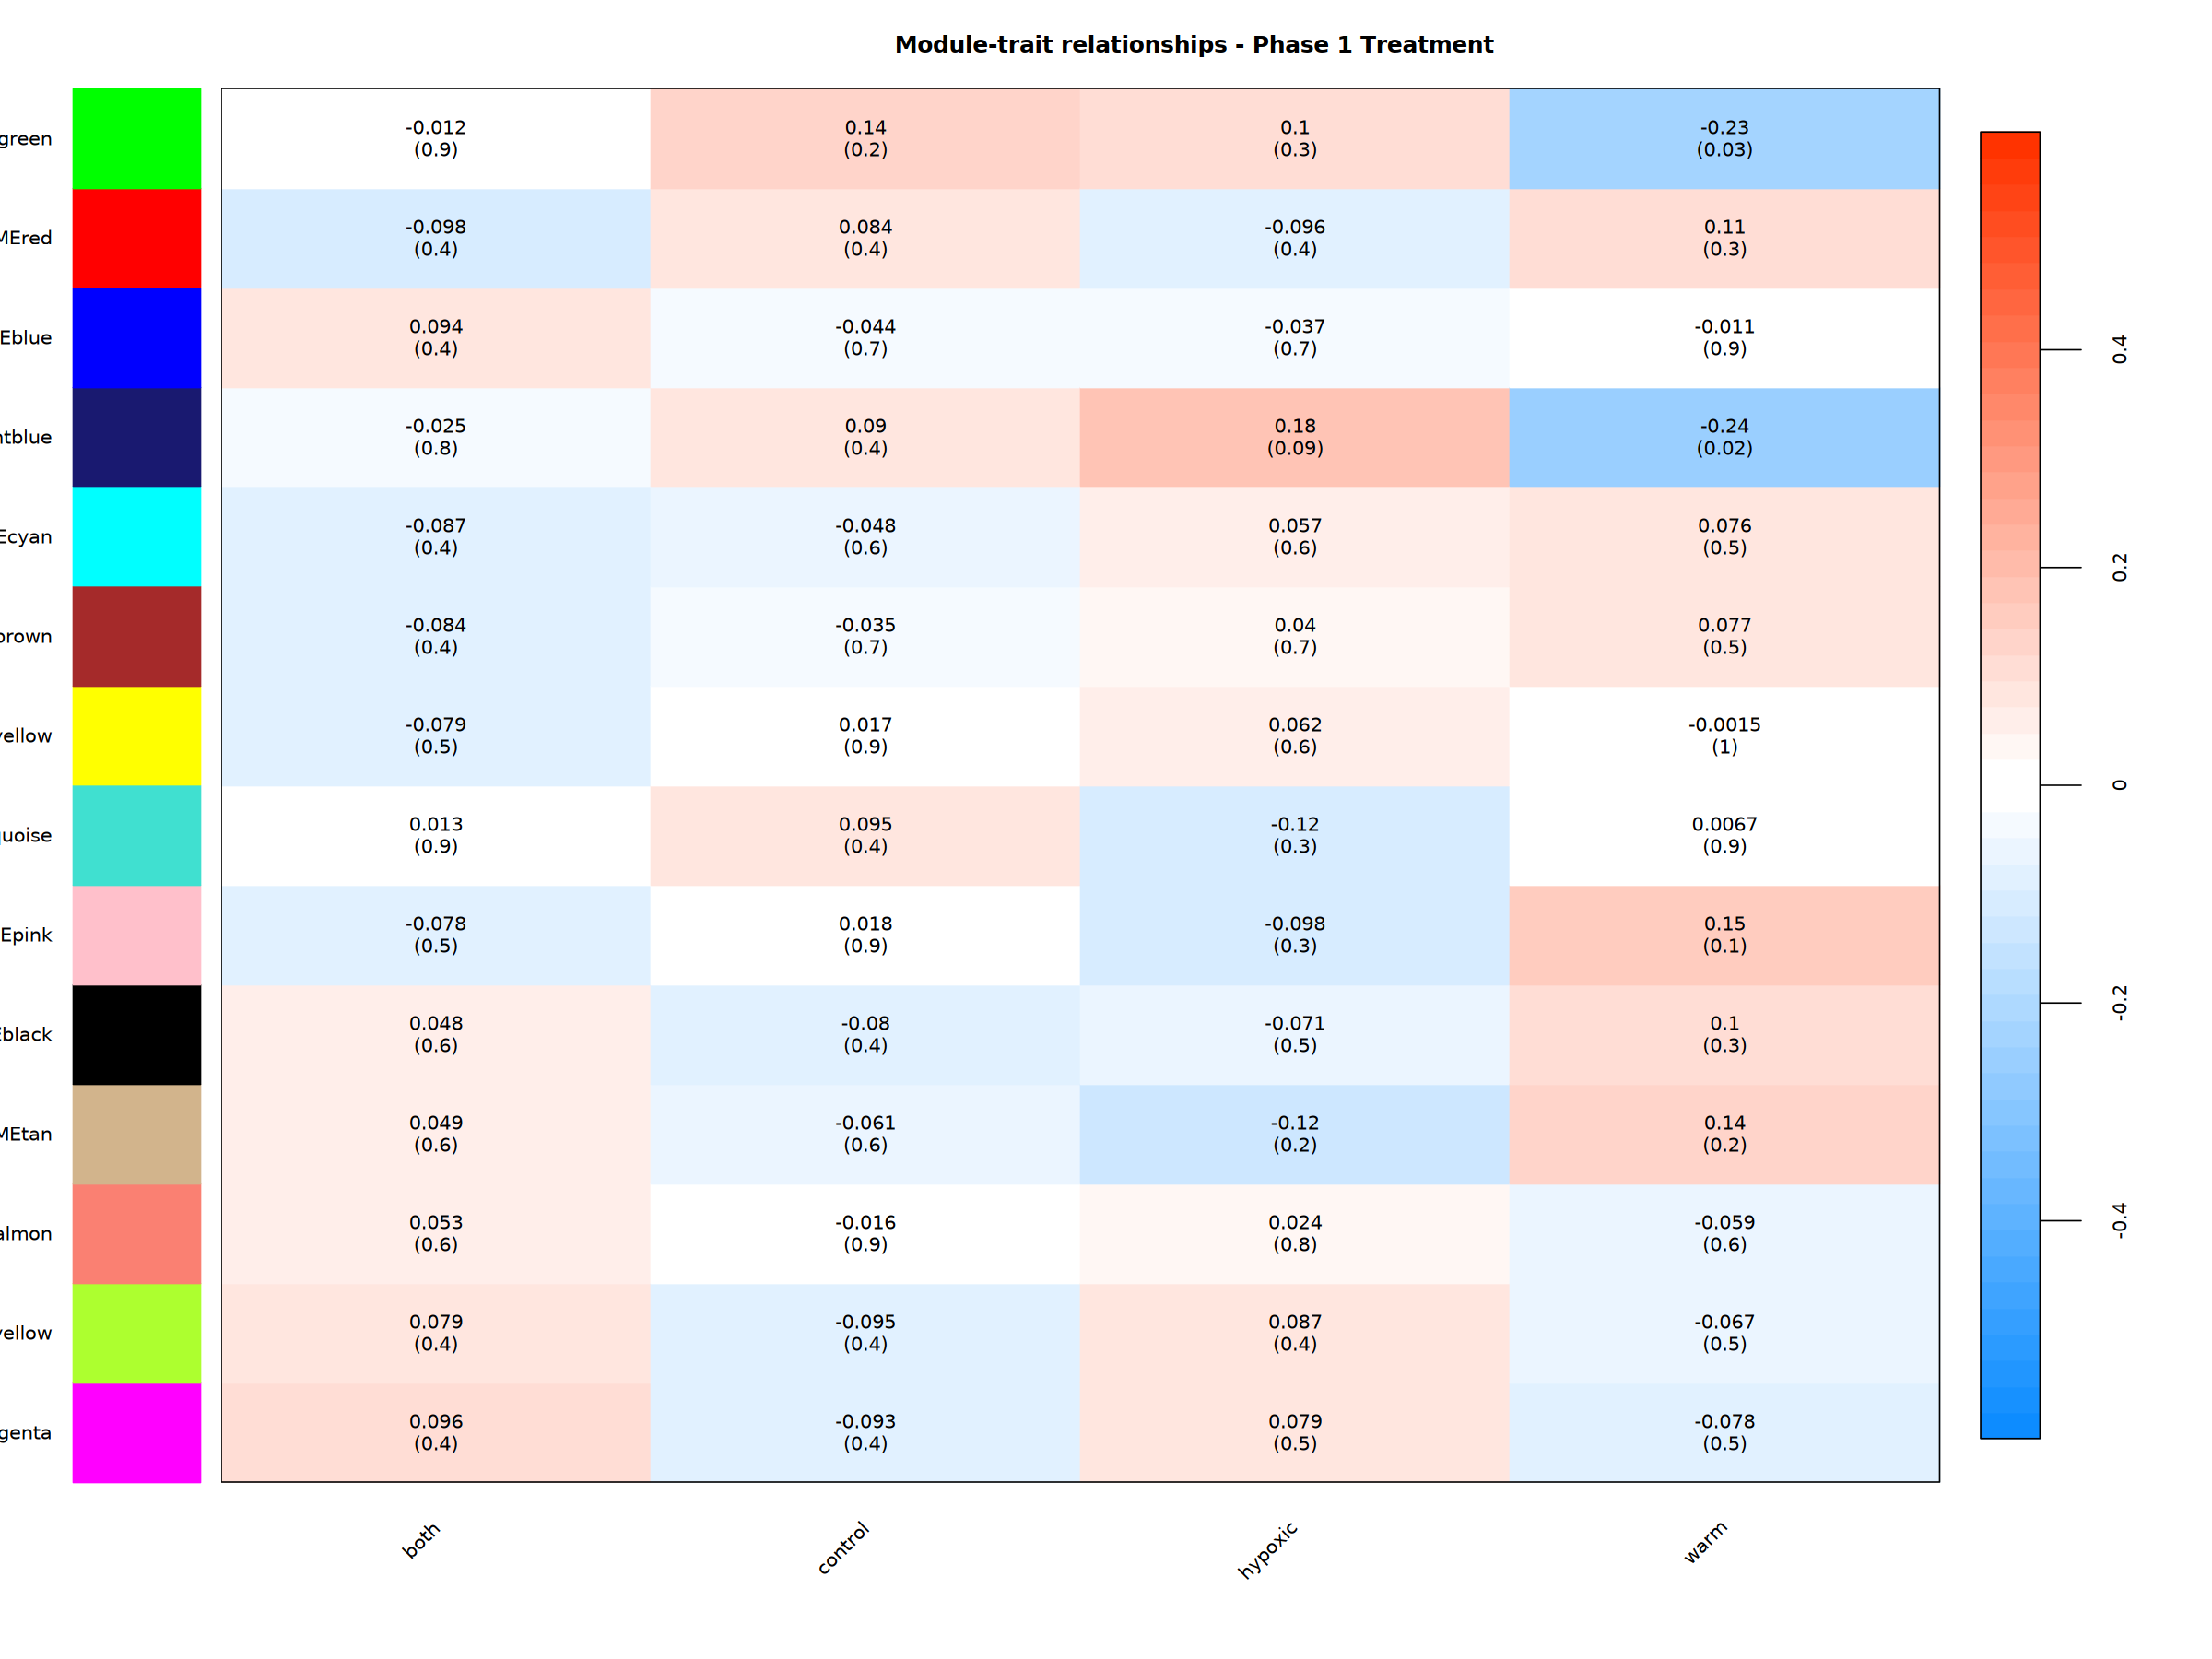

In [112]:
phase1.treatments.matrix <-  paste(signif(moduleTraitCor_p1, 2), "\n(",
                                      signif(moduleTraitPvalue_p1, 1), ")", sep = "")

par(mar = c(8, 10, 4, 2))  # increase bottom & left margins

labeledHeatmap(Matrix = moduleTraitCor_p1,
               xLabels = names(phase1.treatments[-1]),
               yLabels = names(MEs),
               ySymbols = names(MEs),
               colorLabels = TRUE,
               colors = blueWhiteRed(50),
               textMatrix = phase1.treatments.matrix,
               setStdMargins = FALSE,
               cex.text = 1,
               zlim = c(-0.6,0.6),
               main = paste("Module-trait relationships - Phase 1 Treatment"))

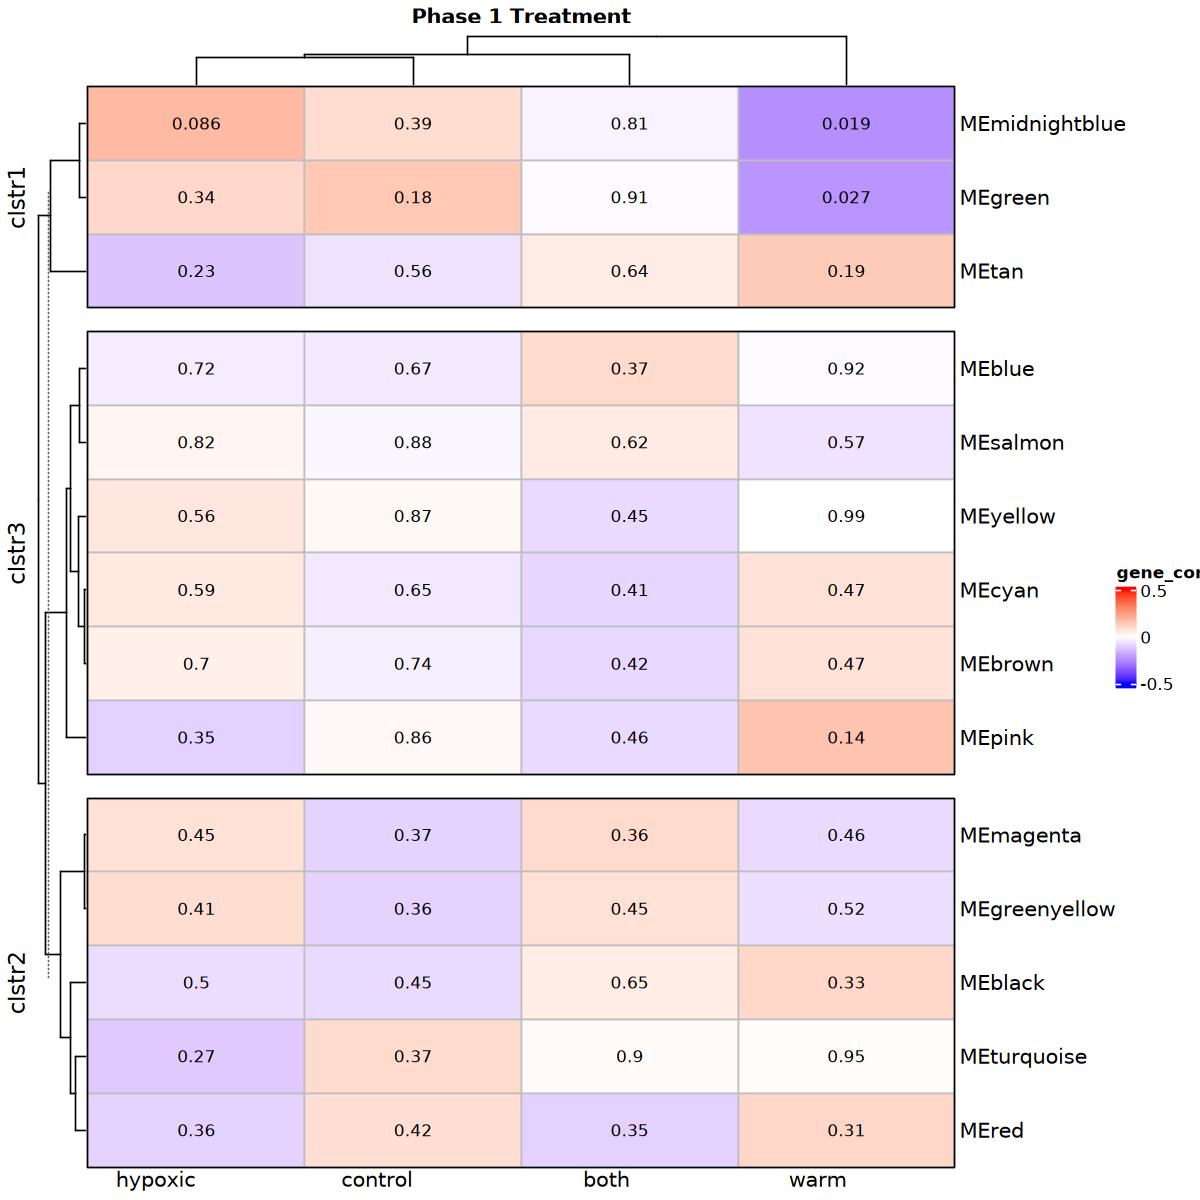

In [113]:
options(repr.plot.width = 10, repr.plot.height = 10)

p1.treatment.text <-  as.matrix(signif(moduleTraitPvalue_p1, 4))
# cluster modules based on p-value similarity
pa = cluster::pam(p1.treatment.text, k = 3)
col_fun = colorRamp2(c(-0.5, 0, 0.5), c("blue", "white", "red"))

p1_treatment.heatmap <- Heatmap(moduleTraitCor_p1, 
        name = "gene_cor", 
        rect_gp = gpar(col = "grey", lwd = 1),
        column_title = "Phase 1 Treatment", 
        column_title_gp = gpar(fontsize = 12, fontface = "bold"),
        # row_title = "WGCNA modules",
        #row_km = 4, 
        column_names_rot = 0,
        column_km = 1,
        row_split = paste0("clstr", pa$clustering),
        row_gap = unit(5, "mm"),
        column_gap = unit(5, "mm"),
        # grid.text(matrix(textMatrix)),
        # border = TRUE,
        border = TRUE,
        col = col_fun,
        cell_fun = function(j, i, x, y, width, height, fill) {
          grid.text(sprintf("%.2g", p1.treatment.text[i, j]), x, y,
          gp = gpar(fontsize = 10))
        })

p1_treatment.heatmap

so the color denotes the correlation, the text within the heatmap denotes the p-value

**higher module eigengene-treatment correlation = higher expression of the module with the given trait/treatment**
- red = lower expression in the given treatment
- blue = higher expression in the given treatment

#### conclusions here:
- only two significantly correlated modules: midnight blue and green
- midnight blue and green are neg. correlated with phase 1 warm (these genes have lower expression in phase 1 warm vs. everything else aka H,C,B)

#### phase 1 temp

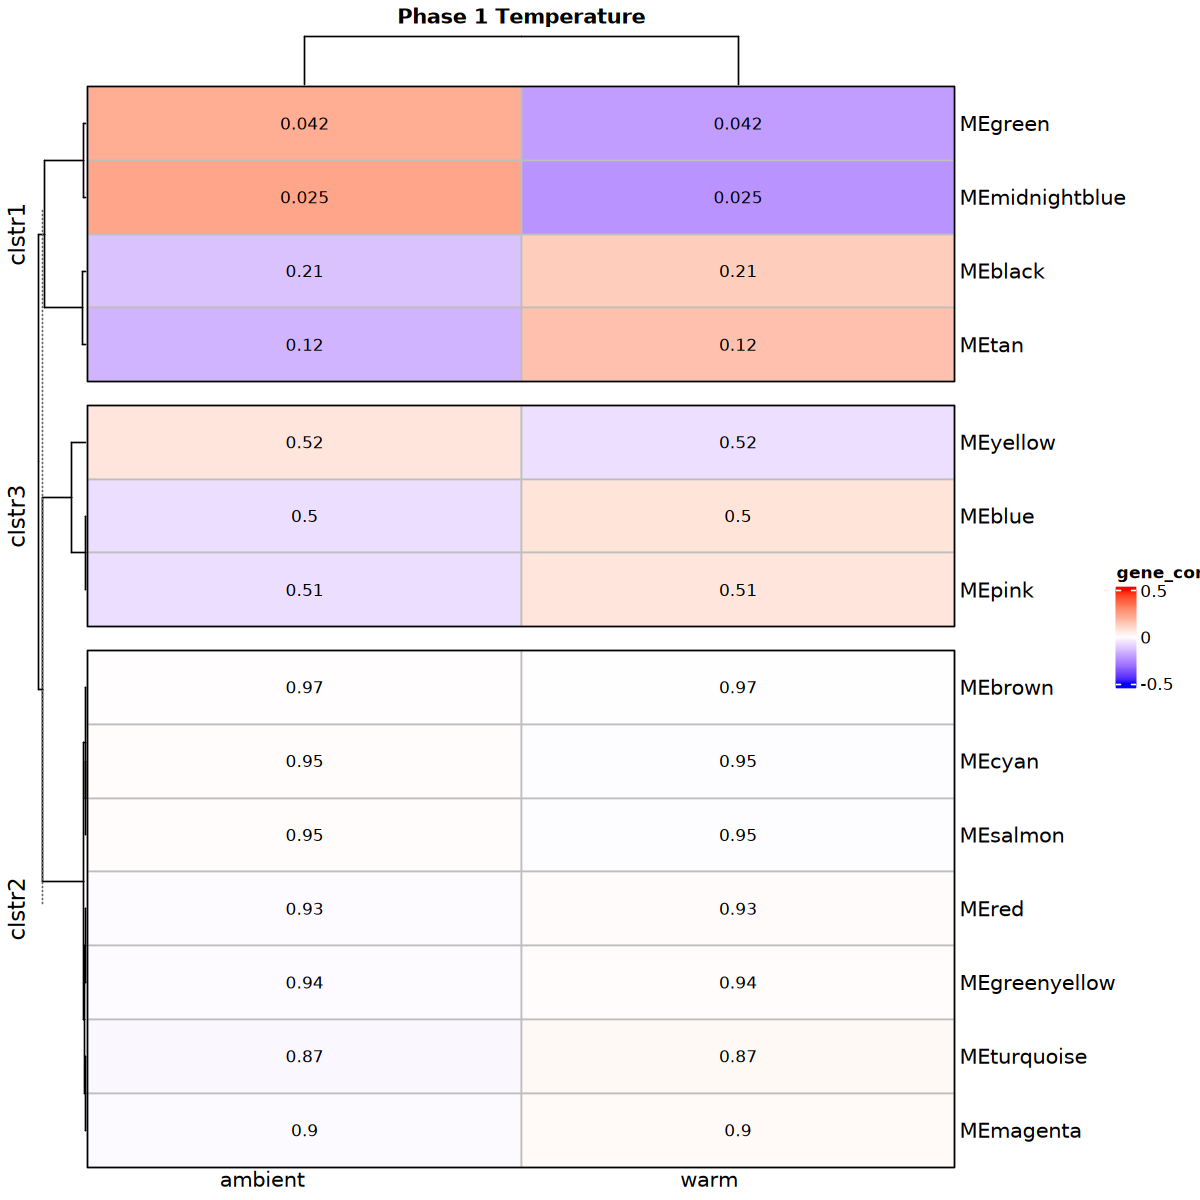

In [114]:
options(repr.plot.width = 10, repr.plot.height = 10)

p1.temp.text <-  as.matrix(signif(moduleTraitPvalue_p1.temp, 4))
# cluster modules based on p-value similarity
pa = cluster::pam(p1.temp.text, k = 3)
col_fun = colorRamp2(c(-0.5, 0, 0.5), c("blue", "white", "red"))

p1_temp.heatmap <- Heatmap(moduleTraitCor_p1.temp, 
        name = "gene_cor", 
        rect_gp = gpar(col = "grey", lwd = 1),
        column_title = "Phase 1 Temperature", 
        column_title_gp = gpar(fontsize = 12, fontface = "bold"),
        # row_title = "WGCNA modules",
        #row_km = 4, 
        column_names_rot = 0,
        column_km = 1,
        row_split = paste0("clstr", pa$clustering),
        row_gap = unit(5, "mm"),
        column_gap = unit(5, "mm"),
        # grid.text(matrix(textMatrix)),
        # border = TRUE,
        border = TRUE,
        col = col_fun,
        cell_fun = function(j, i, x, y, width, height, fill) {
          grid.text(sprintf("%.2g", p1.temp.text[i, j]), x, y,
          gp = gpar(fontsize = 10))
        })

p1_temp.heatmap

#### conclusions here:
- only two significantly correlated modules: midnight blue and green (and they're the same two signif. modules as phase 1 treatments)
- midnight blue and green are neg. correlated with warm and pos. correlated with ambient - so, these genes have lower expression in phase 1 warming and higher expression in phase 1 control conditions, despite experiencing a second exposure
    - this makes sense/follows from the previous heatmap of phase 1 treatments

#### phase 1 DO

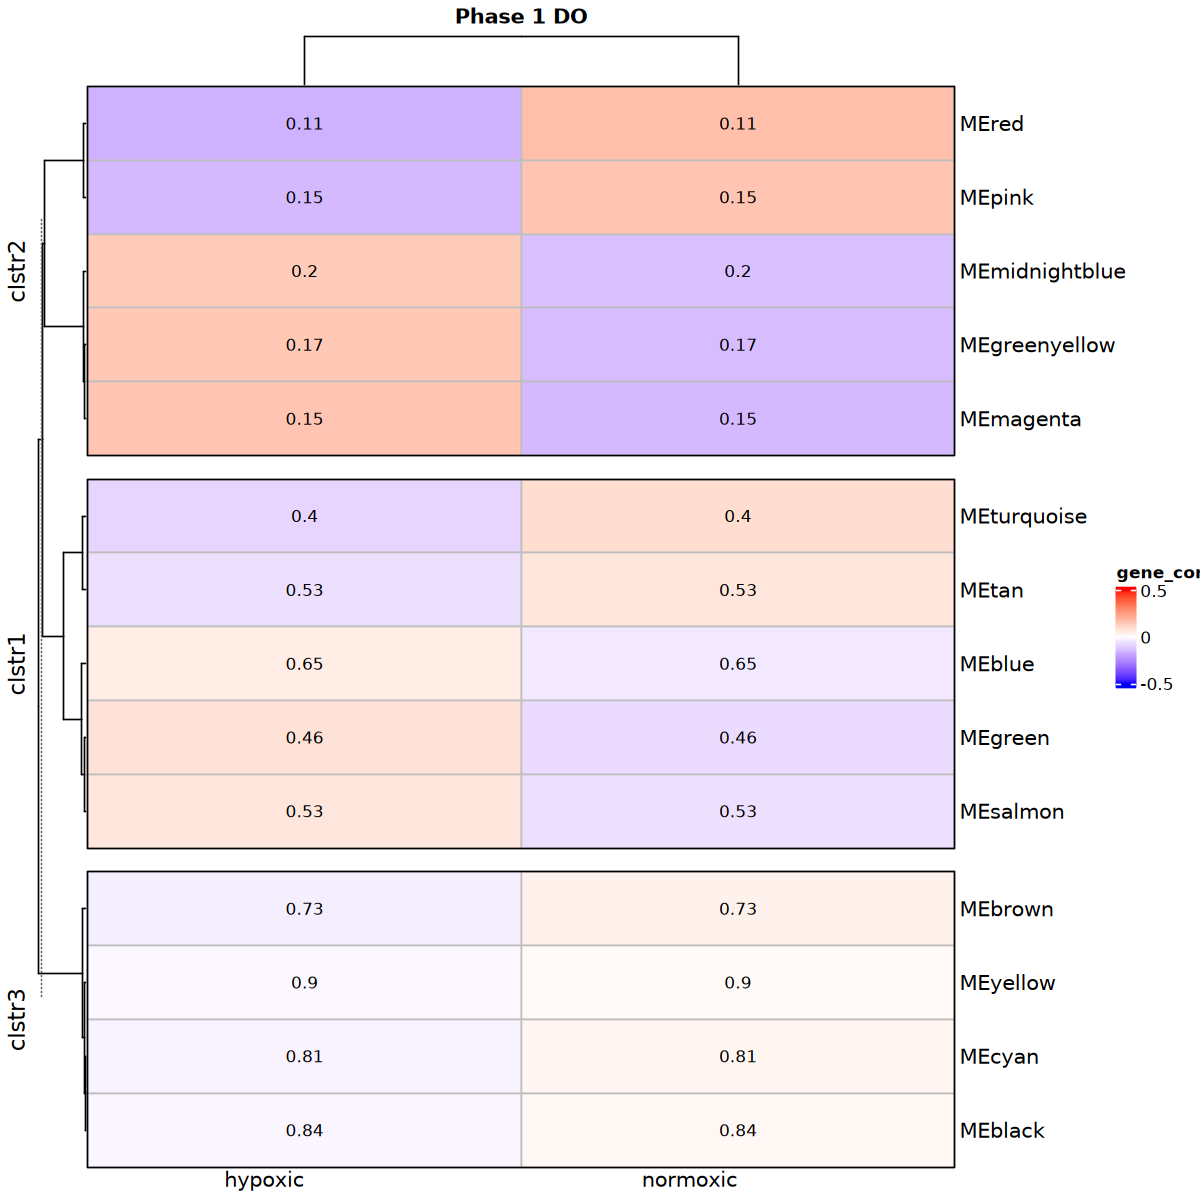

In [115]:
options(repr.plot.width = 10, repr.plot.height = 10)

p1.DO.text <-  as.matrix(signif(moduleTraitPvalue_p1.DO, 4))
# cluster modules based on p-value similarity
pa = cluster::pam(p1.DO.text, k = 3)
col_fun = colorRamp2(c(-0.5, 0, 0.5), c("blue", "white", "red"))

p1_DO.heatmap <- Heatmap(moduleTraitCor_p1.DO, 
        name = "gene_cor", 
        rect_gp = gpar(col = "grey", lwd = 1),
        column_title = "Phase 1 DO", 
        column_title_gp = gpar(fontsize = 12, fontface = "bold"),
        # row_title = "WGCNA modules",
        #row_km = 4, 
        column_names_rot = 0,
        column_km = 1,
        row_split = paste0("clstr", pa$clustering),
        row_gap = unit(5, "mm"),
        column_gap = unit(5, "mm"),
        # grid.text(matrix(textMatrix)),
        # border = TRUE,
        border = TRUE,
        col = col_fun,
        cell_fun = function(j, i, x, y, width, height, fill) {
          grid.text(sprintf("%.2g", p1.DO.text[i, j]), x, y,
          gp = gpar(fontsize = 10))
        })

p1_DO.heatmap

#### conclusions here:
- no significant modules for phase 1 DO

#### phase 2 treatment

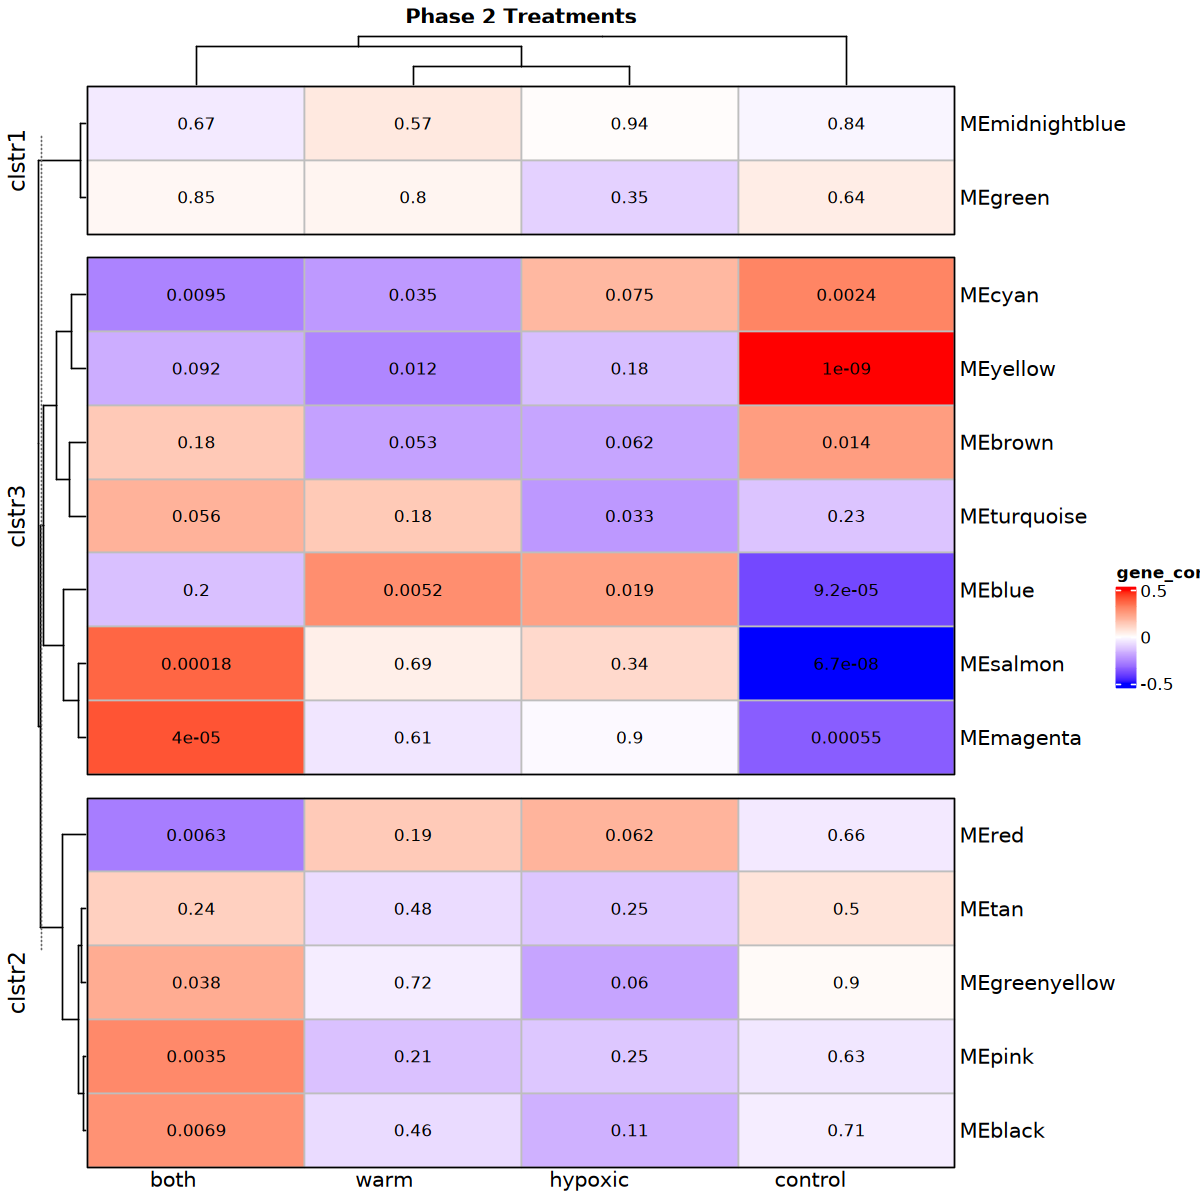

In [96]:
options(repr.plot.width = 10, repr.plot.height = 10)

p2.treatment.text <-  as.matrix(signif(moduleTraitPvalue_p2, 4))
# cluster modules based on p-value similarity
pa = cluster::pam(p2.treatment.text, k = 3)
col_fun = colorRamp2(c(-0.5, 0, 0.5), c("blue", "white", "red"))

p2_treatment.heatmap <- Heatmap(moduleTraitCor_p2, 
        name = "gene_cor", 
        rect_gp = gpar(col = "grey", lwd = 1),
        column_title = "Phase 2 Treatments", 
        column_title_gp = gpar(fontsize = 12, fontface = "bold"),
        # row_title = "WGCNA modules",
        #row_km = 4, 
        column_names_rot = 0,
        column_km = 1,
        row_split = paste0("clstr", pa$clustering),
        row_gap = unit(5, "mm"),
        column_gap = unit(5, "mm"),
        # grid.text(matrix(textMatrix)),
        # border = TRUE,
        border = TRUE,
        col = col_fun,
        cell_fun = function(j, i, x, y, width, height, fill) {
          grid.text(sprintf("%.2g", p2.treatment.text[i, j]), x, y,
          gp = gpar(fontsize = 10))
        })

p2_treatment.heatmap

#### conclusions here:
- lots of significantly correlated modules here!
    - red ~ phase 2 stressors (neg. cor with both, pos. cor with warm and hypoxic)
    - greenyellow ~ pos. both
    - pink ~ pos. both
    - black ~ pos. both
    - magenta and salmon ~ neg. control, pos. both
    - blue ~ neg. control, pos. warm
    - yellow ~ pos. control, neg. warm

#### phase 2 DO

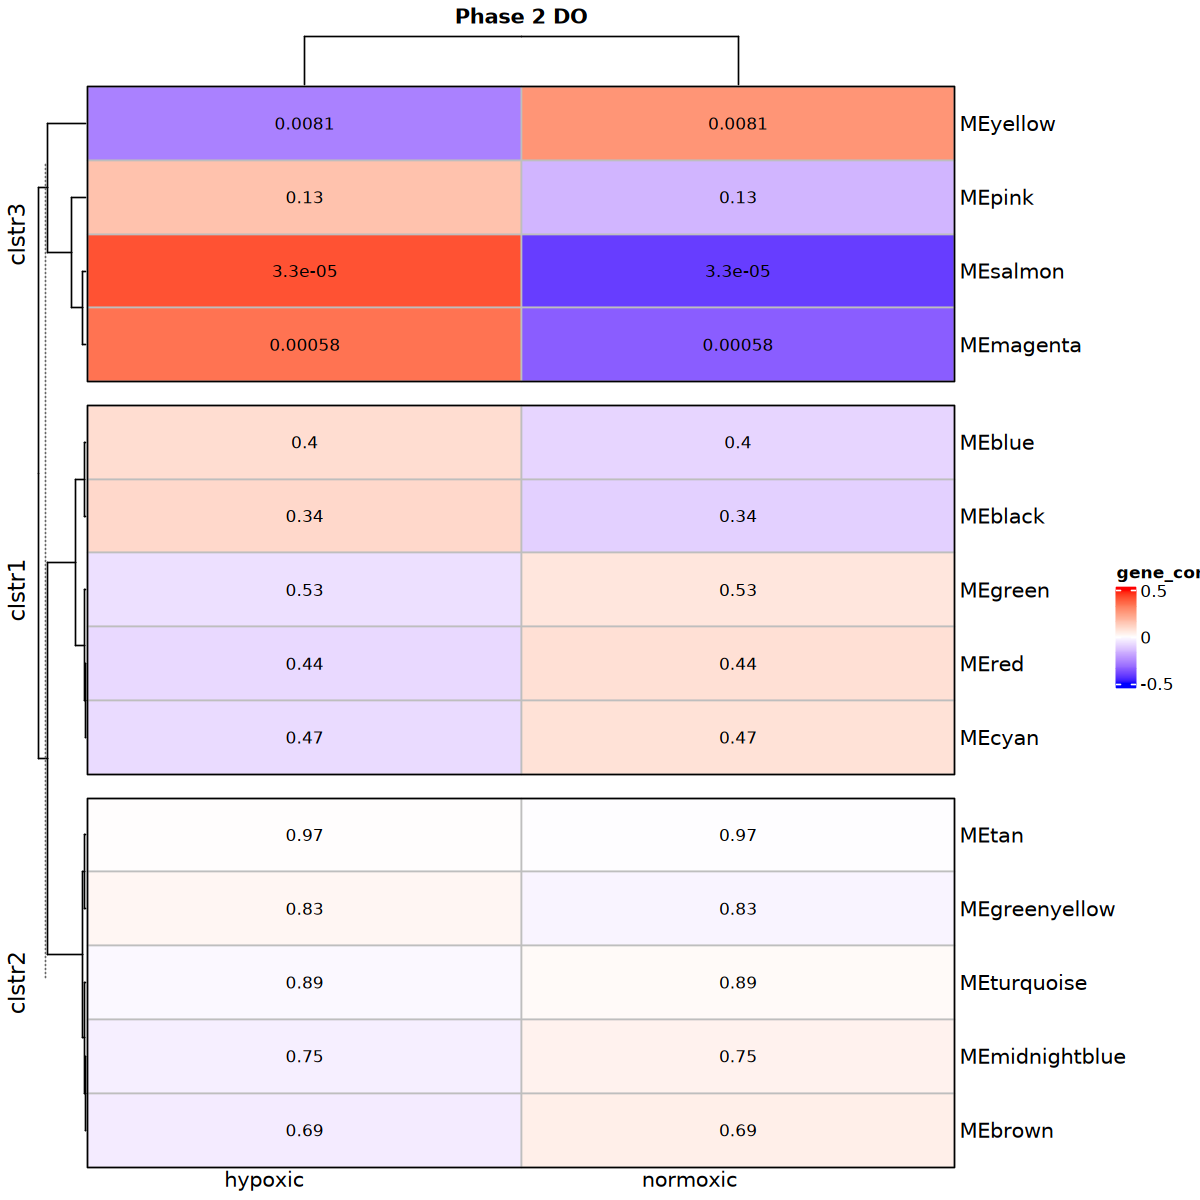

In [97]:
options(repr.plot.width = 10, repr.plot.height = 10)

p2.DO.text <-  as.matrix(signif(moduleTraitPvalue_p2.DO, 4))
# cluster modules based on p-value similarity
pa = cluster::pam(p2.DO.text, k = 3)
col_fun = colorRamp2(c(-0.5, 0, 0.5), c("blue", "white", "red"))

p2_DO.heatmap <- Heatmap(moduleTraitCor_p2.DO, 
        name = "gene_cor", 
        rect_gp = gpar(col = "grey", lwd = 1),
        column_title = "Phase 2 DO", 
        column_title_gp = gpar(fontsize = 12, fontface = "bold"),
        # row_title = "WGCNA modules",
        #row_km = 4, 
        column_names_rot = 0,
        column_km = 1,
        row_split = paste0("clstr", pa$clustering),
        row_gap = unit(5, "mm"),
        column_gap = unit(5, "mm"),
        # grid.text(matrix(textMatrix)),
        # border = TRUE,
        border = TRUE,
        col = col_fun,
        cell_fun = function(j, i, x, y, width, height, fill) {
          grid.text(sprintf("%.2g", p2.DO.text[i, j]), x, y,
          gp = gpar(fontsize = 10))
        })

p2_DO.heatmap

#### conclusions here:
- four significantly correlated modules: yellow, pink, salmon, magenta
- salmon and magenta are correlated in the same direction (neg. for normoxic, pos. for hypoxic) - meaning that the genes in those modules have higher expression in phase 2 hypoxia than normoxia (regardless of temperature treatment)

####  phase 2 temperature

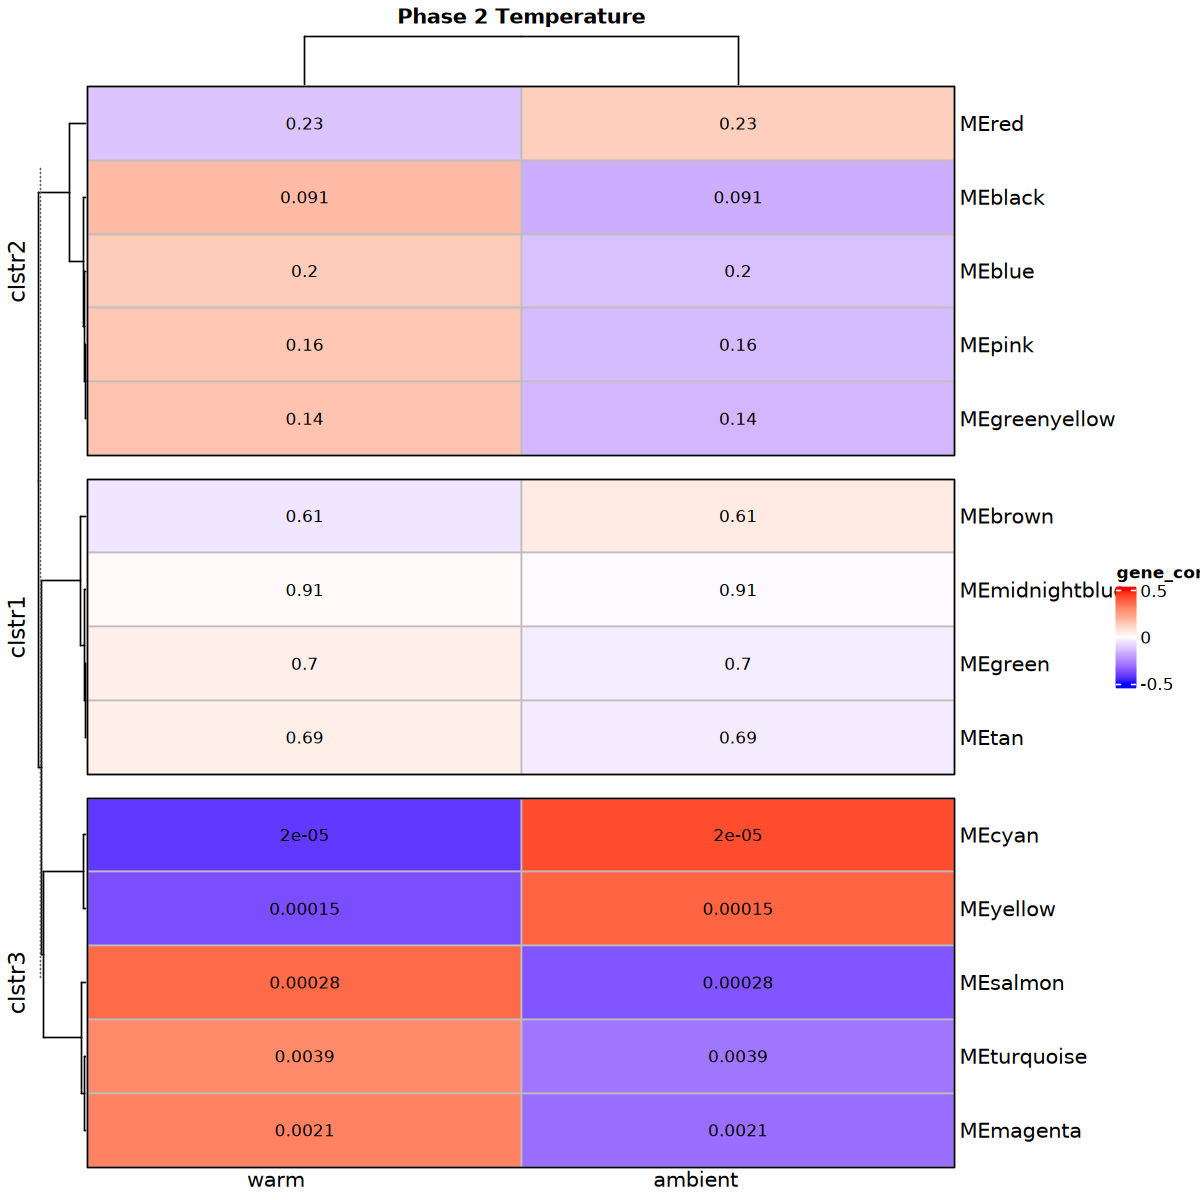

In [98]:
options(repr.plot.width = 10, repr.plot.height = 10)

p2.temp.text <-  as.matrix(signif(moduleTraitPvalue_p2.temp, 4))
# cluster modules based on p-value similarity
pa = cluster::pam(p2.temp.text, k = 3)
col_fun = colorRamp2(c(-0.5, 0, 0.5), c("blue", "white", "red"))

p2_temp.heatmap <- Heatmap(moduleTraitCor_p2.temp, 
        name = "gene_cor", 
        rect_gp = gpar(col = "grey", lwd = 1),
        column_title = "Phase 2 Temperature", 
        column_title_gp = gpar(fontsize = 12, fontface = "bold"),
        # row_title = "WGCNA modules",
        #row_km = 4, 
        column_names_rot = 0,
        column_km = 1,
        row_split = paste0("clstr", pa$clustering),
        row_gap = unit(5, "mm"),
        column_gap = unit(5, "mm"),
        # grid.text(matrix(textMatrix)),
        # border = TRUE,
        border = TRUE,
        col = col_fun,
        cell_fun = function(j, i, x, y, width, height, fill) {
          grid.text(sprintf("%.2g", p2.temp.text[i, j]), x, y,
          gp = gpar(fontsize = 10))
        })

p2_temp.heatmap

#### conclusions here:
- six significantly correlated modules - black, cyan, yellow, salmon, turquoise, and magenta
- salmon, turquoise, and magenta (and black but to a lesser degree) are all neg. correlated with ambient temperatures, meaning that they have lower expression in phase 2 ambient conditions (or higher expression in phase 2 warm conditions), regardless of DO treatment
- cyan and yellow are all neg. correlated with warm temps, meaning they have lower expression in phase 2 warm conditions

In [103]:
library(cowplot)
library(grid)

In [105]:
# 1. Create a helper function to convert ComplexHeatmap to a grob
as_grob_hm <- function(hm) {
  grid.grabExpr(draw(hm))
}

# 2. Convert all your heatmaps
p1_temp_g <- as_grob_hm(p1_temp.heatmap)
p1_DO_g <- as_grob_hm(p1_DO.heatmap)
p1_treatment_g <- as_grob_hm(p1_treatment.heatmap)
p2_temp_g <- as_grob_hm(p2_temp.heatmap)
p2_DO_g <- as_grob_hm(p2_DO.heatmap)
p2_treatment_g <- as_grob_hm(p2_treatment.heatmap)

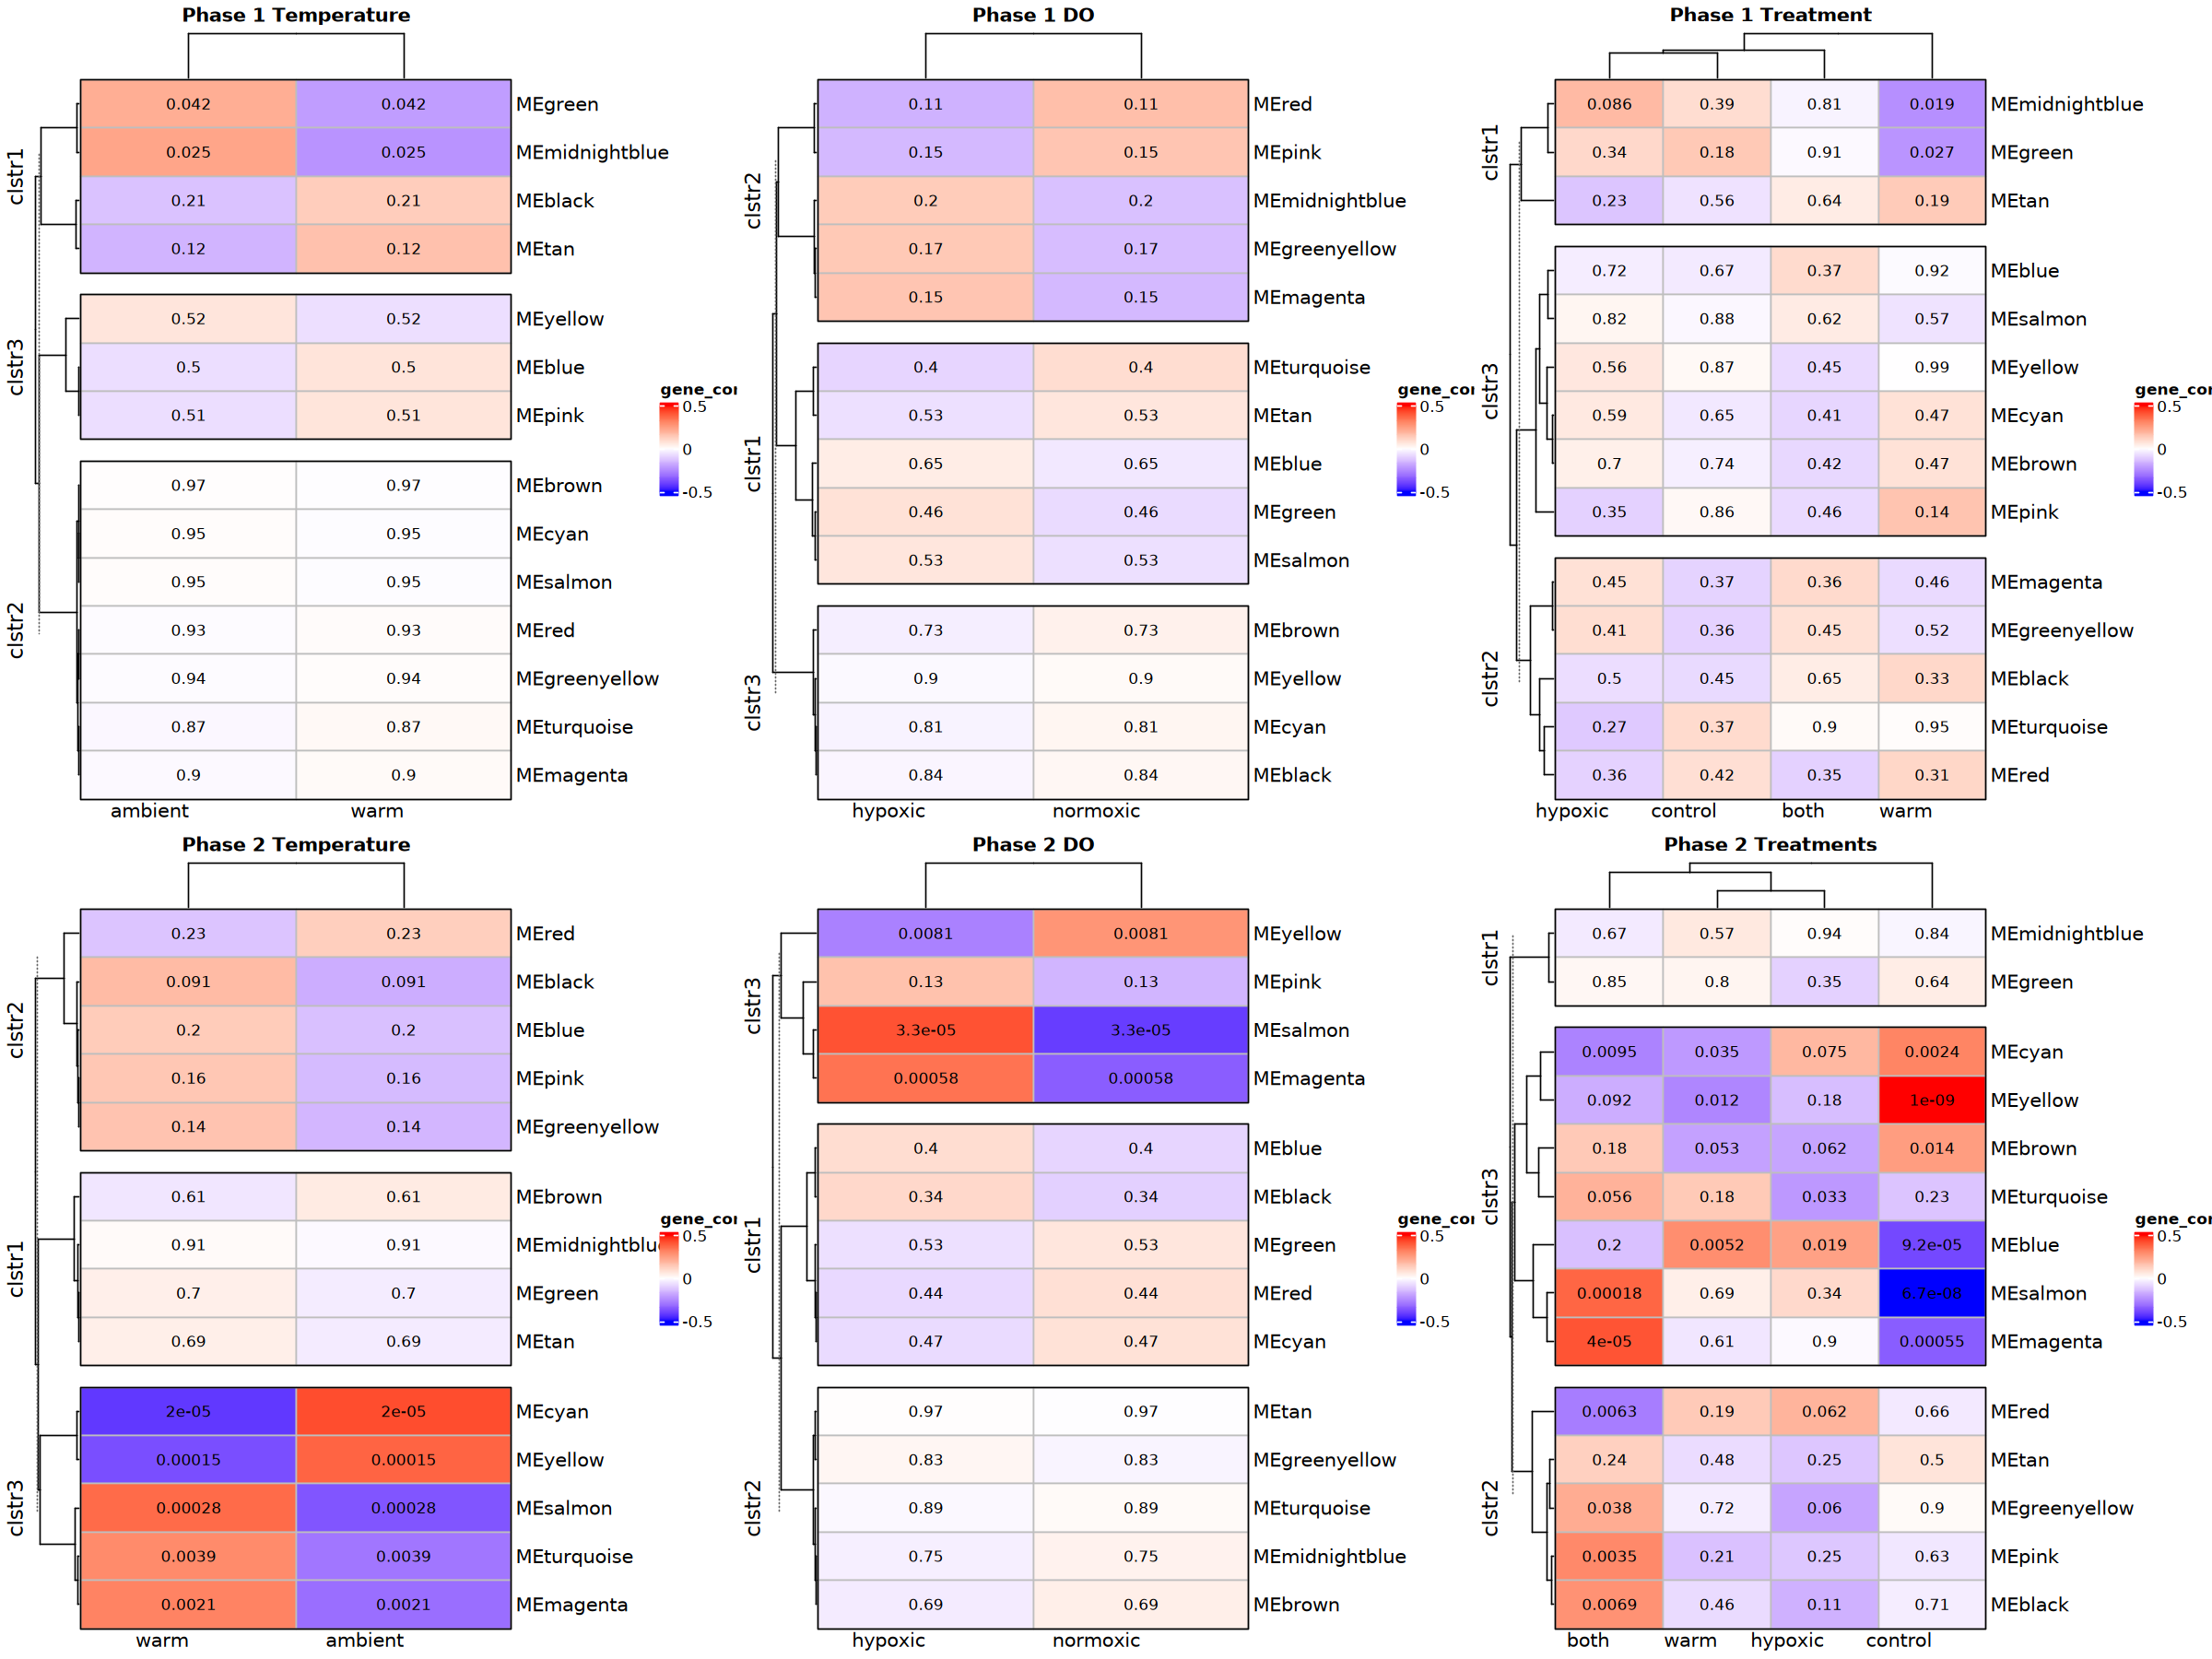

In [116]:
options(repr.plot.width = 20, repr.plot.height = 15)

# 3. Use plot_grid with the new grob objects
all_heatmaps <- plot_grid(p1_temp_g, p1_DO_g, p1_treatment_g, 
          p2_temp_g, p2_DO_g, p2_treatment_g,
          nrow = 2, ncol = 3)

all_heatmaps

some of the axes are not in the same order bc of clustering - I think I'm okay with that since it's informative for the treatments

In [123]:
ggsave('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/wgcna/plots/module_heatmaps_p2.pdf', all_heatmaps, width= 20, height = 15)

In [129]:
ggsave(
  filename = '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/wgcna/plots/module_heatmaps_p2.png', 
  plot = all_heatmaps, 
  width = 20,       # Half the width
  height = 15,     # Roughly half the height
  units = "in", 
  dpi = 300         # High resolution for clarity
)

####  Combo of P1 & P2

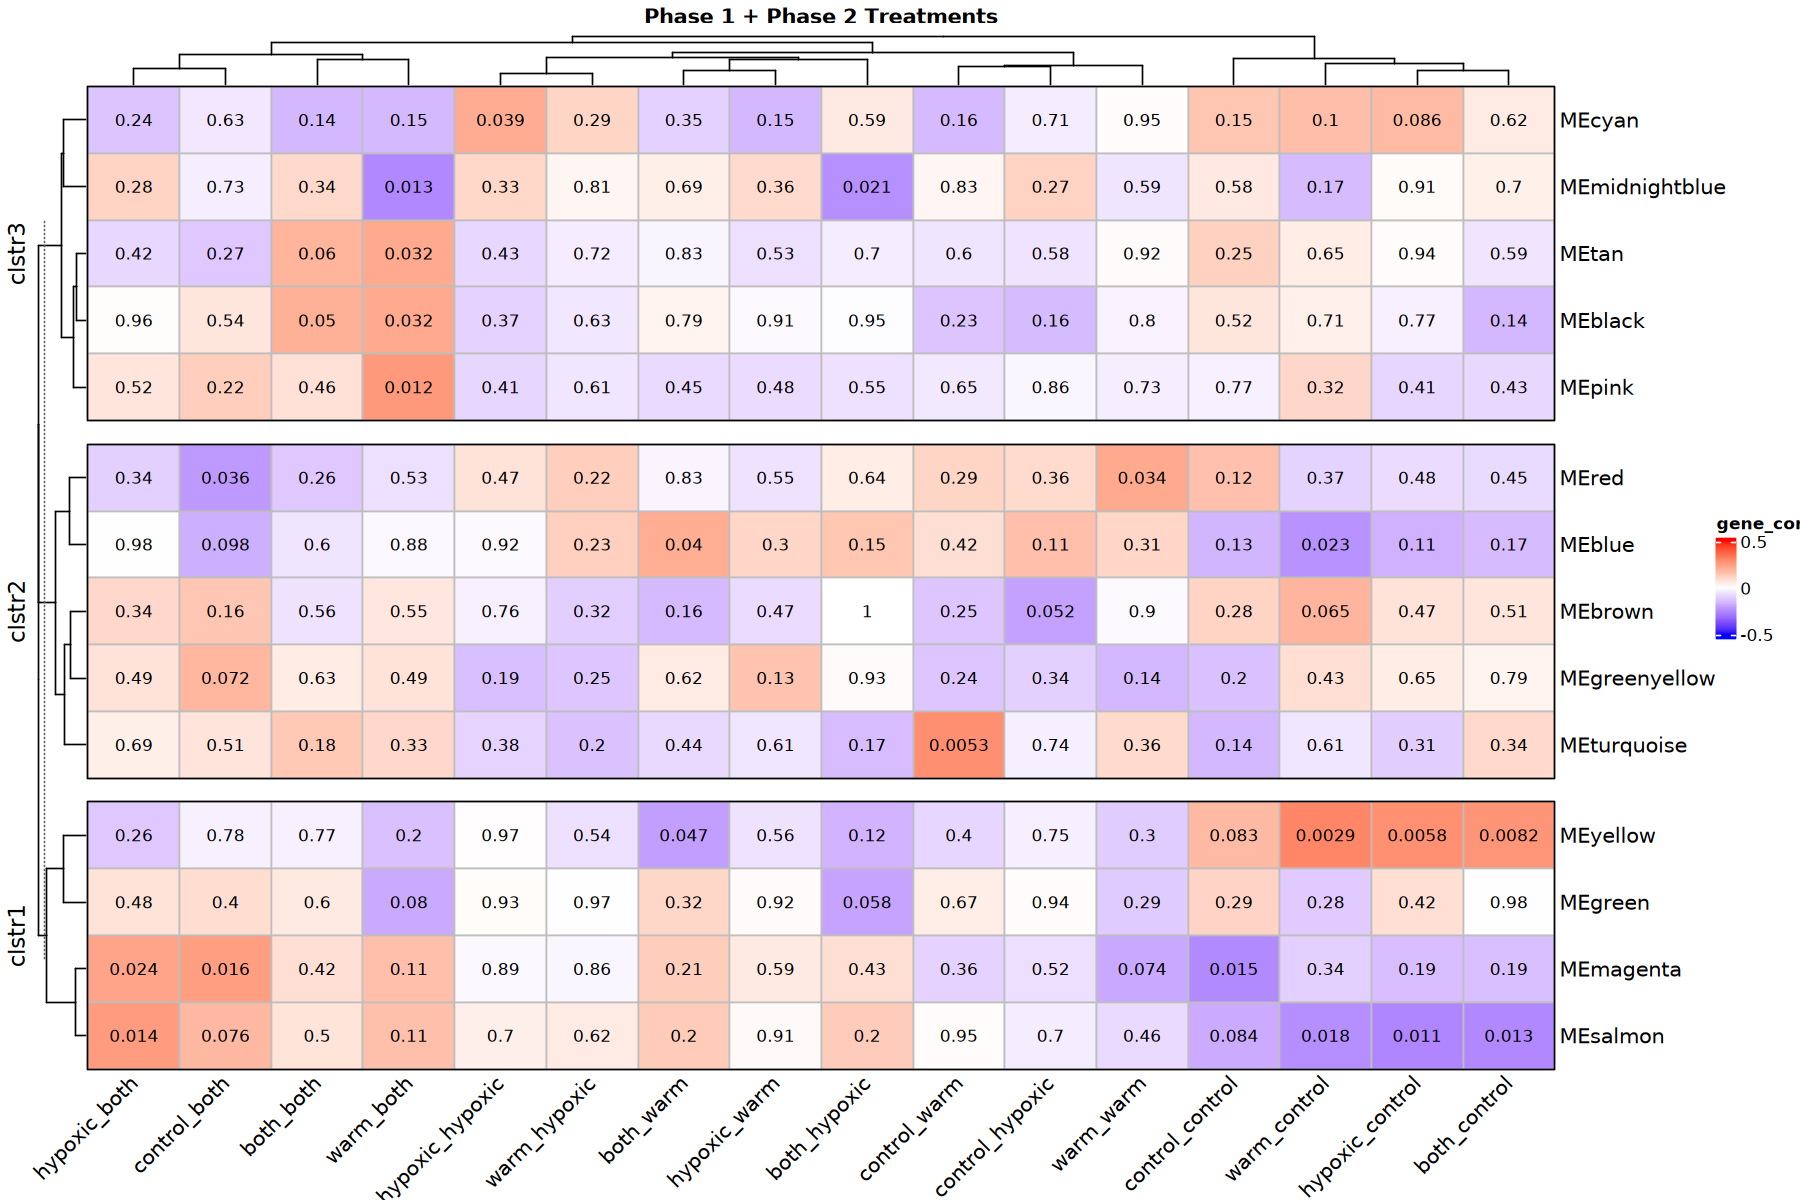

In [53]:
options(repr.plot.width = 15, repr.plot.height = 10)

combo.text <-  as.matrix(signif(moduleTraitPvalue_combo, 4))
# cluster modules based on p-value similarity
pa = cluster::pam(combo.text, k = 3)
col_fun = colorRamp2(c(-0.5, 0, 0.5), c("blue", "white", "red"))

Heatmap(moduleTraitCor_combo, 
        name = "gene_cor", 
        rect_gp = gpar(col = "grey", lwd = 1),
        column_title = "Phase 1 + Phase 2 Treatments", 
        column_title_gp = gpar(fontsize = 12, fontface = "bold"),
        # row_title = "WGCNA modules",
        #row_km = 4, 
        column_names_rot = 45,
        column_km = 1,
        row_split = paste0("clstr", pa$clustering),
        row_gap = unit(5, "mm"),
        column_gap = unit(5, "mm"),
        # grid.text(matrix(textMatrix)),
        # border = TRUE,
        border = TRUE,
        col = col_fun,
        cell_fun = function(j, i, x, y, width, height, fill) {
          grid.text(sprintf("%.2g", combo.text[i, j]), x, y,
          gp = gpar(fontsize = 10))
        })

column clustering = shows similarity of the treatments with similar correlation patterns across modules

## MEs boxplots by treatment group

inspo for this comes from [Gurr's code](https://github.com/SamGurr/Pgenerosa_OA_TagSeq/blob/main/TagSeq/Analysis/Scripts/Day21_WGCNA_all.R) - plotting every module's ME (module eigengene) for each treatment combination - this will allow me to take a closer look at the relationship between modules and phase 1 and 2 treatments

first - need to make sure the sample name mixup from above carries down here

In [54]:
# add missing rep number to sample name
rownames(metaData_merge)[rownames(metaData_merge) == 'C_W5_W52'] <- 'C2_W5_W52'
rownames(dataMeta)[rownames(dataMeta) == 'C_W5_W52'] <- 'C2_W5_W52'

# fix wrong rep number to sample name
rownames(metaData_merge)[rownames(metaData_merge) == 'W2_B2_G04'] <- 'W2_B1_G04'
rownames(dataMeta)[rownames(dataMeta) == 'W2_B2_G04'] <- 'W2_B1_G04'

# update sample column info
metaData_merge$Sample <- rownames(metaData_merge)
dataMeta$Sample <- rownames(dataMeta)

then create df to plot boxplots - want the metadata and module eigengene info in long format

In [55]:
# Create ME table
MEs_df <- as.data.frame(MEs)
MEs_df$Sample <- rownames(MEs_df)

# format metadata and merge with MEs
dataMeta2 <- dataMeta[,1:10]
meta_merge <- merge(dataMeta2, metaData_merge, by = 'Sample')
dim(meta_merge)

# merge MEs and metadata
MEsPlotting <- merge(MEs_df, meta_merge, by = 'Sample')

# Melt to long format
MEsPlotting_melt <- reshape2::melt(
  MEsPlotting,
  id.vars = c("Sample",
              "Phase1_treatment",
              "Phase1_temp",
              "Phase1_DO",
              "Phase1_TankRep",
              "Phase2_treatment",
              "Phase2_temp",
              "Phase2_DO",
              "Phase2_TankRep",
              "combo_trtmt",
              'Actual_shell_growth_mg',
              'Actual_tissue_growth_mg', 
              'Ratio_tissue_shell_mg'
             ),
  variable.name = "Module",
  value.name = "Eigengene"
)

MEsPlotting_melt <- MEsPlotting_melt %>%
filter(!grepl('code', Module)) # remove treatment code rows

head(MEsPlotting_melt)

[1] 93 19

Sample    Phase1_treatment Phase1_temp Phase1_DO Phase1_TankRep
1 B1_B1_O01 both             warm        hypoxic   1             
2 B1_W5_O50 both             warm        hypoxic   1             
3 B2_B5_O51 both             warm        hypoxic   2             
4 B2_C4_O40 both             warm        hypoxic   2             
5 B3_B4_O41 both             warm        hypoxic   3             
6 B3_C3_O30 both             warm        hypoxic   3             
  Phase2_treatment Phase2_temp Phase2_DO Phase2_TankRep combo_trtmt 
1 both             warm        hypoxic   1              both_both   
2 warm             warm        normoxic  5              both_warm   
3 both             warm        hypoxic   5              both_both   
4 control          ambient     normoxic  4              both_control
5 both             warm        hypoxic   4              both_both   
6 control          ambient     normoxic  3              both_control
  Actual_shell_growth_mg Actual_tissue_growth_mg Ratio_tissue_shell_mg Module 
1 210.2755               120.72448               0.574125224           MEgreen
2 315.8883                85.61170               0.271018901           MEgreen
3 114.3215                44.47852               0.389065292           MEgreen
4 164.9903                55.10972               0.33401798            MEgreen
5 197.9250               116.17500               0.586964759           MEgreen
6 316.0466               241.35336               0.763663743           MEgreen
  Eigengene  
1 -0.07267705
2  0.11259458
3 -0.08984971
4  0.10140997
5  0.09981873
6  0.13421227

In [56]:
# save metadata in case I skip code above
# write.csv(MEsPlotting_melt[,1:13], '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/wgcna/p2.wgcna_metadata.csv')

make boxplot!

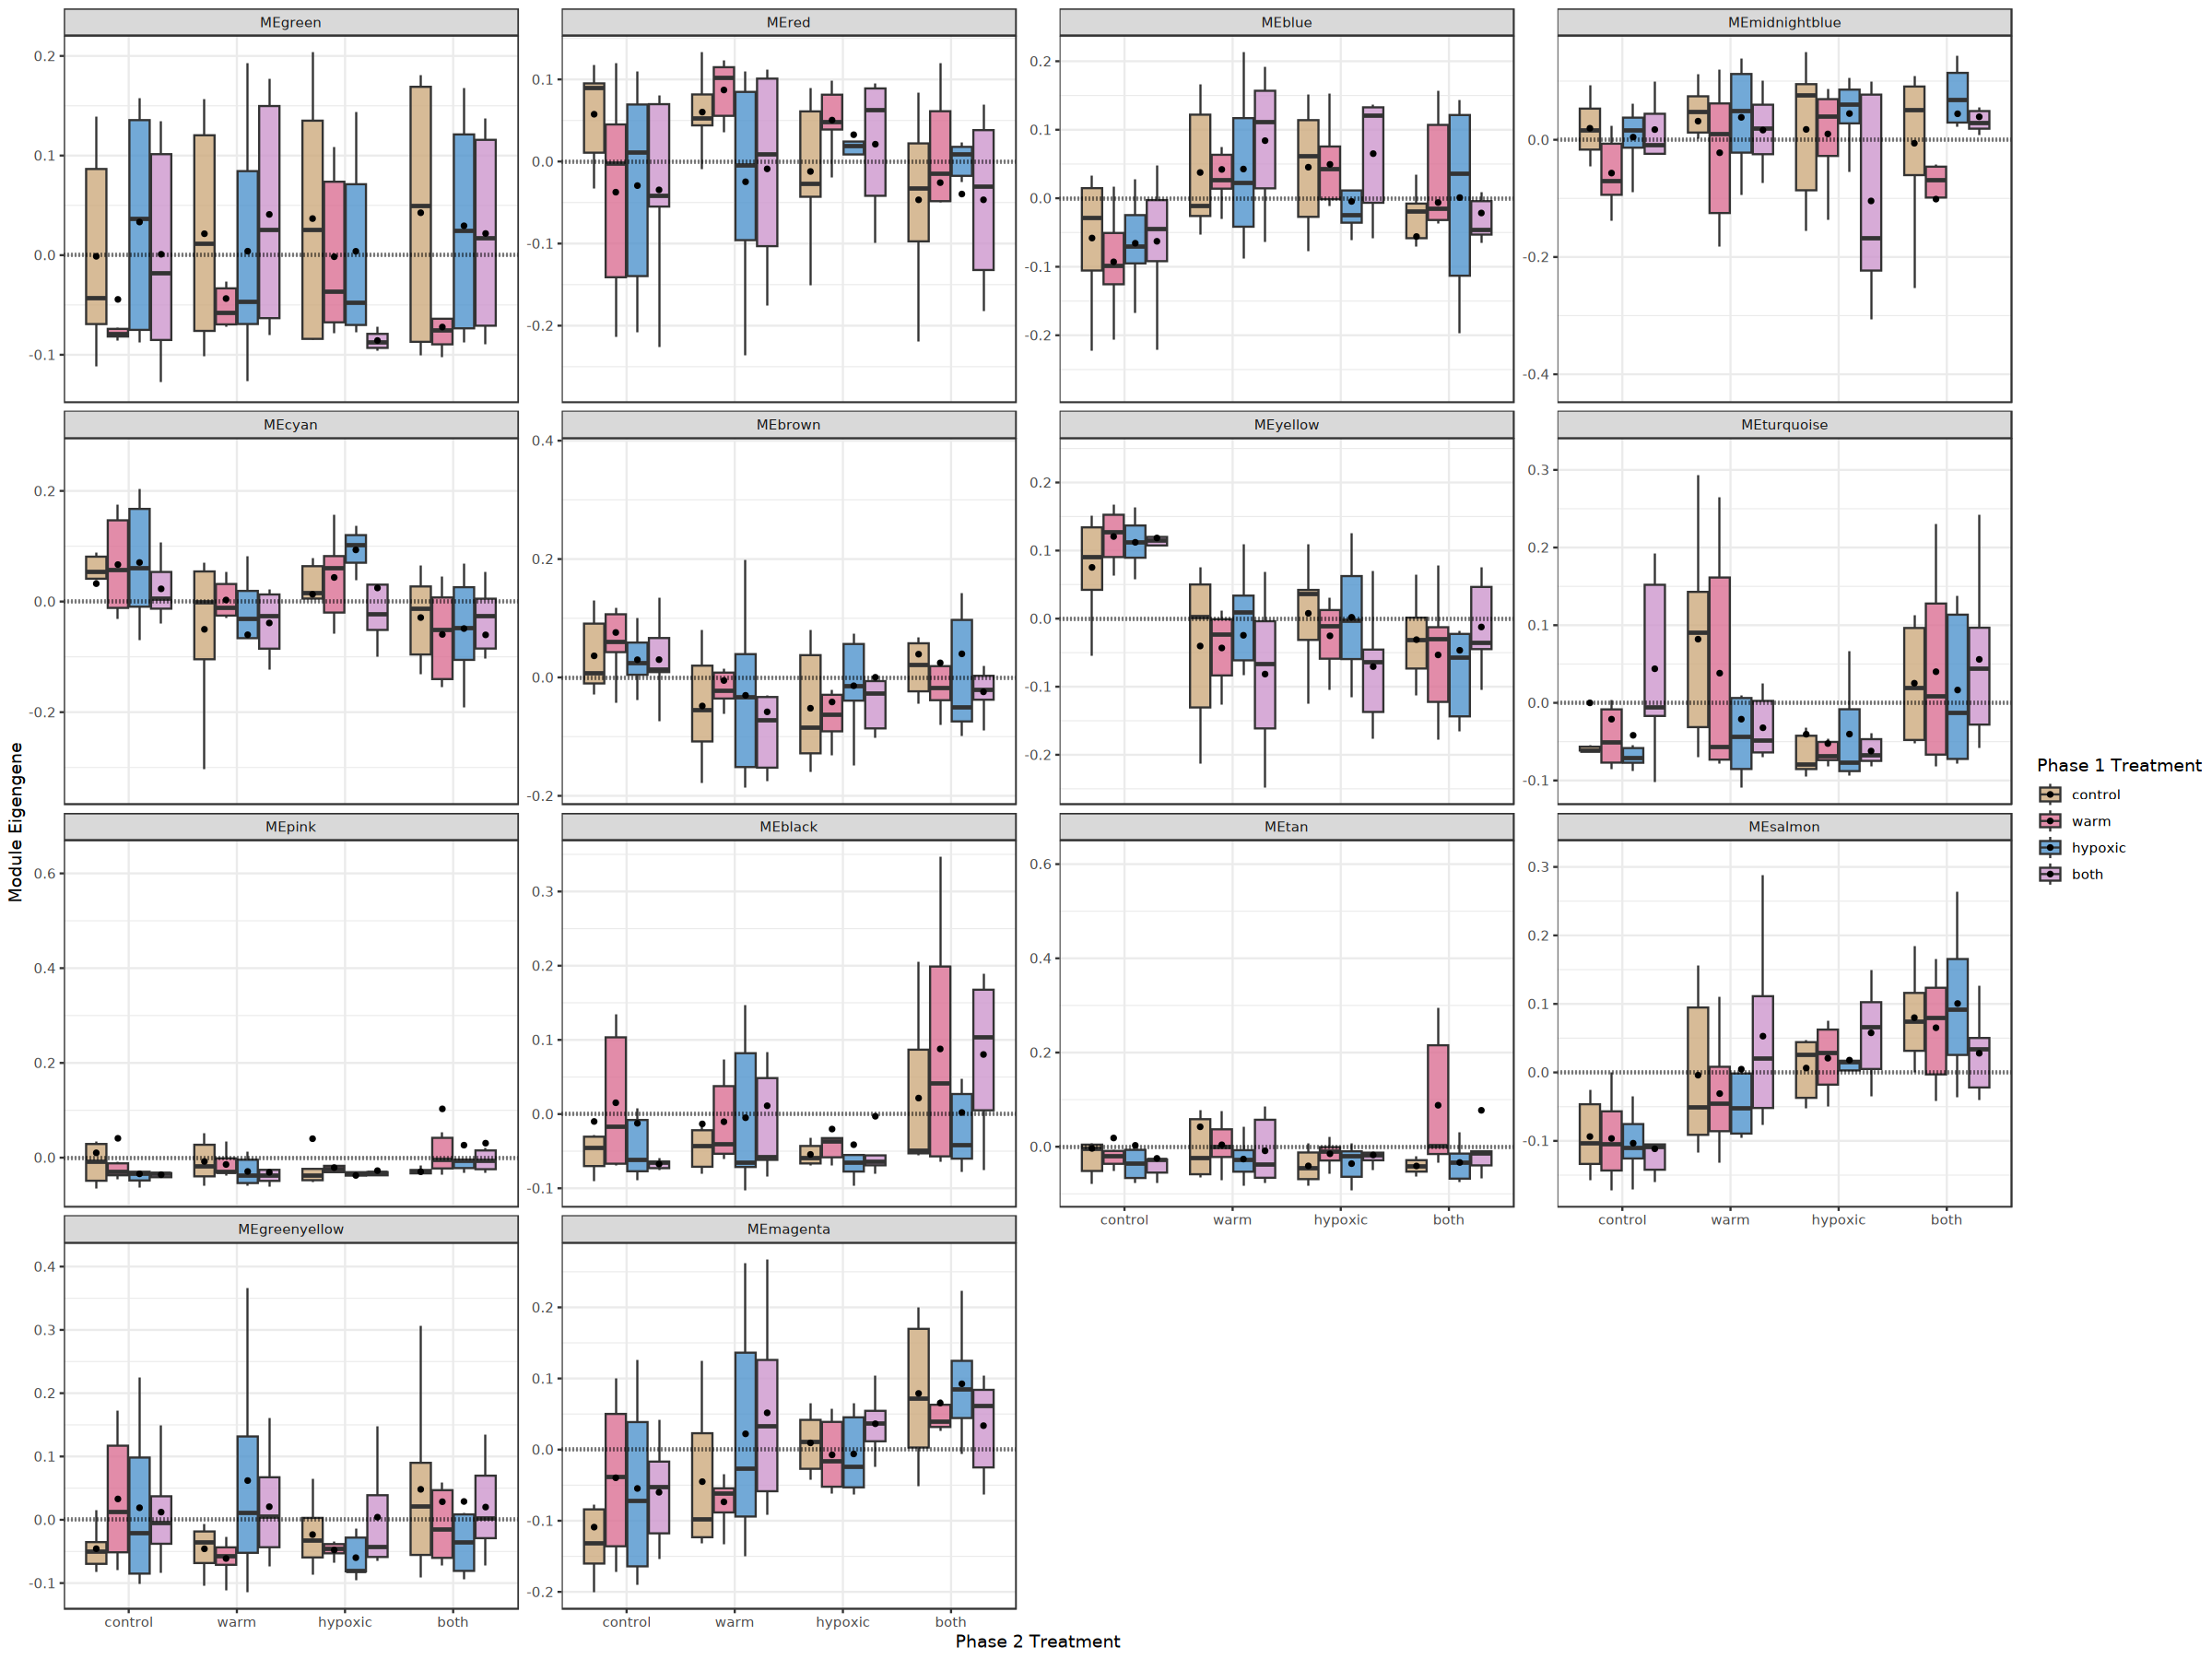

In [126]:
options(repr.plot.width = 20, repr.plot.hieght = 20)

MEs_boxplot <- ggplot(MEsPlotting_melt,
       aes(x = Phase2_treatment,
           y = Eigengene,
           fill = factor(Phase1_treatment))) +
  
  geom_boxplot(position = position_dodge(0.8),
               outlier.shape = NA,
               alpha = 0.8) +

scale_fill_manual(values = c("hypoxic" = "steelblue3", 
                             "warm" = "palevioletred", 
                             "control" = "burlywood3", 
                             "both" = "plum3")) +
  
  stat_summary(fun = mean,
               geom = "point",
               color = "black",
               position = position_dodge(0.8),
               size = 1) +
  
  geom_hline(yintercept = 0,
             linetype = "dotted",
             linewidth = 1) +
  
  ylab("Module Eigengene") +
labs(fill = 'Phase 1 Treatment', x = 'Phase 2 Treatment') +
  theme_bw() +
  facet_wrap(~ Module, scales = "free_y")

MEs_boxplot

x-axis: module eigengene - representative gene expression profile for that module

dotted line denotes no expression, pos = higher expr and neg = lower expr

In [127]:
ggsave(
  filename = '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/wgcna/plots/MEs_boxplots_p2.png', 
  plot = MEs_boxplot, 
  width = 10,       # Half the width
  height = 8.5,     # Roughly half the height
  units = "in", 
  dpi = 300         # High resolution for clarity
)

## ANOVA on MEs

In [58]:
head(meta_merge)

Sample    Phase1_treatment Phase1_temp Phase1_DO Phase1_TankRep
1 B1_B1_O01 both             warm        hypoxic   1             
2 B1_W5_O50 both             warm        hypoxic   1             
3 B2_B5_O51 both             warm        hypoxic   2             
4 B2_C4_O40 both             warm        hypoxic   2             
5 B3_B4_O41 both             warm        hypoxic   3             
6 B3_C3_O30 both             warm        hypoxic   3             
  Phase2_treatment Phase2_temp Phase2_DO Phase2_TankRep combo_trtmt 
1 both             warm        hypoxic   1              both_both   
2 warm             warm        normoxic  5              both_warm   
3 both             warm        hypoxic   5              both_both   
4 control          ambient     normoxic  4              both_control
5 both             warm        hypoxic   4              both_both   
6 control          ambient     normoxic  3              both_control
  Actual_shell_growth_mg Actual_tissue_growth_mg Ratio_tissue_shell_mg
1 210.2755               120.72448               0.574125224          
2 315.8883                85.61170               0.271018901          
3 114.3215                44.47852               0.389065292          
4 164.9903                55.10972               0.33401798           
5 197.9250               116.17500               0.586964759          
6 316.0466               241.35336               0.763663743          
  P1_trtmt_code P2_trtmt_code P1_temp_code P2_temp_code P1_DO_code P2_DO_code
1 4             4             2            2            2          2         
2 4             2             2            2            2          1         
3 4             4             2            2            2          2         
4 4             1             2            1            2          1         
5 4             4             2            2            2          2         
6 4             1             2            1            2          1

In [59]:
# Create a storage list or data frame for results
anova_results <- list()

for(module in colnames(MEs)) {
  # Create a temporary formula: Module_Eigengene ~ Phase1 * Phase2
  # The '*' denotes Interaction (Phase1 + Phase2 + Phase1:Phase2)
  fit <- aov(MEs[[module]] ~ Phase1_temp * Phase1_DO * Phase2_temp * Phase2_DO, data = meta_merge)
  
  # Summarize and save
  anova_results[[module]] <- summary(fit)
}

In [60]:
head(anova_results)

$MEgreen
                                            Df Sum Sq Mean Sq F value Pr(>F)  
Phase1_temp                                  1 0.0446 0.04459   3.978 0.0496 *
Phase1_DO                                    1 0.0056 0.00560   0.499 0.4820  
Phase2_temp                                  1 0.0017 0.00167   0.149 0.7002  
Phase2_DO                                    1 0.0039 0.00393   0.351 0.5555  
Phase1_temp:Phase1_DO                        1 0.0118 0.01175   1.048 0.3091  
Phase1_temp:Phase2_temp                      1 0.0016 0.00162   0.145 0.7046  
Phase1_DO:Phase2_temp                        1 0.0150 0.01501   1.339 0.2508  
Phase1_temp:Phase2_DO                        1 0.0010 0.00101   0.090 0.7645  
Phase1_DO:Phase2_DO                          1 0.0031 0.00314   0.280 0.5981  
Phase2_temp:Phase2_DO                        1 0.0040 0.00402   0.359 0.5509  
Phase1_temp:Phase1_DO:Phase2_temp            1 0.0185 0.01848   1.649 0.2029  
Phase1_temp:Phase1_DO:Phase2_DO            

#### post-hoc Tukey test

In [61]:
# Run Tukey on a specific module of interest
#specific_fit <- aov(MEs[MEblue] ~ Phase1_temp * Phase1_DO * Phase2_temp * Phase2_DO, data = meta_merge)
specific_fit <- aov(MEs$MEsalmon ~ Phase1_temp * Phase1_DO * Phase2_temp * Phase2_DO, data = meta_merge)
tukey_out <- TukeyHSD(specific_fit)

# Look specifically at the interaction comparisons
head(tukey_out)

$Phase1_temp
                     diff         lwr        upr     p adj
warm-ambient -0.001403388 -0.03844946 0.03564269 0.9400657

$Phase1_DO
                       diff         lwr        upr     p adj
hypoxic-normoxic 0.01363117 -0.02343205 0.05069439 0.4661804

$Phase2_temp
                   diff        lwr       upr        p adj
warm-ambient 0.07606058 0.03899736 0.1131238 0.0001065255

$Phase2_DO
                       diff        lwr       upr        p adj
hypoxic-normoxic 0.08561952 0.04857345 0.1226656 1.619227e-05

$`Phase1_temp:Phase1_DO`
                                         diff         lwr        upr     p adj
warm:normoxic-ambient:normoxic   -0.005761962 -0.07376239 0.06223846 0.9960806
ambient:hypoxic-ambient:normoxic  0.009024898 -0.05971069 0.07776048 0.9858035
warm:hypoxic-ambient:normoxic     0.012585794 -0.05694292 0.08211451 0.9642952
ambient:hypoxic-warm:normoxic     0.014786861 -0.05394872 0.08352244 0.9421504
warm:hypoxic-warm:normoxic        0.018347756 -0.05118096 0.08787647 0.8994808
warm:hypoxic-ambient:hypoxic      0.003560895 -0.06668699 0.07380878 0.9991505

$`Phase1_temp:Phase2_temp`
                                    diff          lwr        upr       p adj
warm:ambient-ambient:ambient  0.01231504 -0.057932839 0.08256293 0.967393120
ambient:warm-ambient:ambient  0.09001257  0.021276985 0.15874815 0.005129998
warm:warm-ambient:ambient     0.07411879  0.005383206 0.14285437 0.029505695
ambient:warm-warm:ambient     0.07769753  0.008168812 0.14722624 0.022370983
warm:warm-warm:ambient        0.06180375 -0.007724967 0.13133246 0.099187354
warm:warm-ambient:warm       -0.01589378 -0.083894201 0.05210664 0.927399209

In [62]:
# Extract p-values for different biological questions
anova_summary <- lapply(colnames(MEs), function(mod) {
  fit <- aov(MEs[[mod]] ~ Phase1_temp * Phase1_DO * Phase2_temp * Phase2_DO, data = meta_merge)
  pvals <- summary(fit)[[1]][["Pr(>F)"]]
  names(pvals) <- rownames(summary(fit)[[1]])
  return(pvals)
})

# Convert to a clean data frame
anova_df <- as.data.frame(do.call(rbind, anova_summary))
rownames(anova_df) <- colnames(MEs)

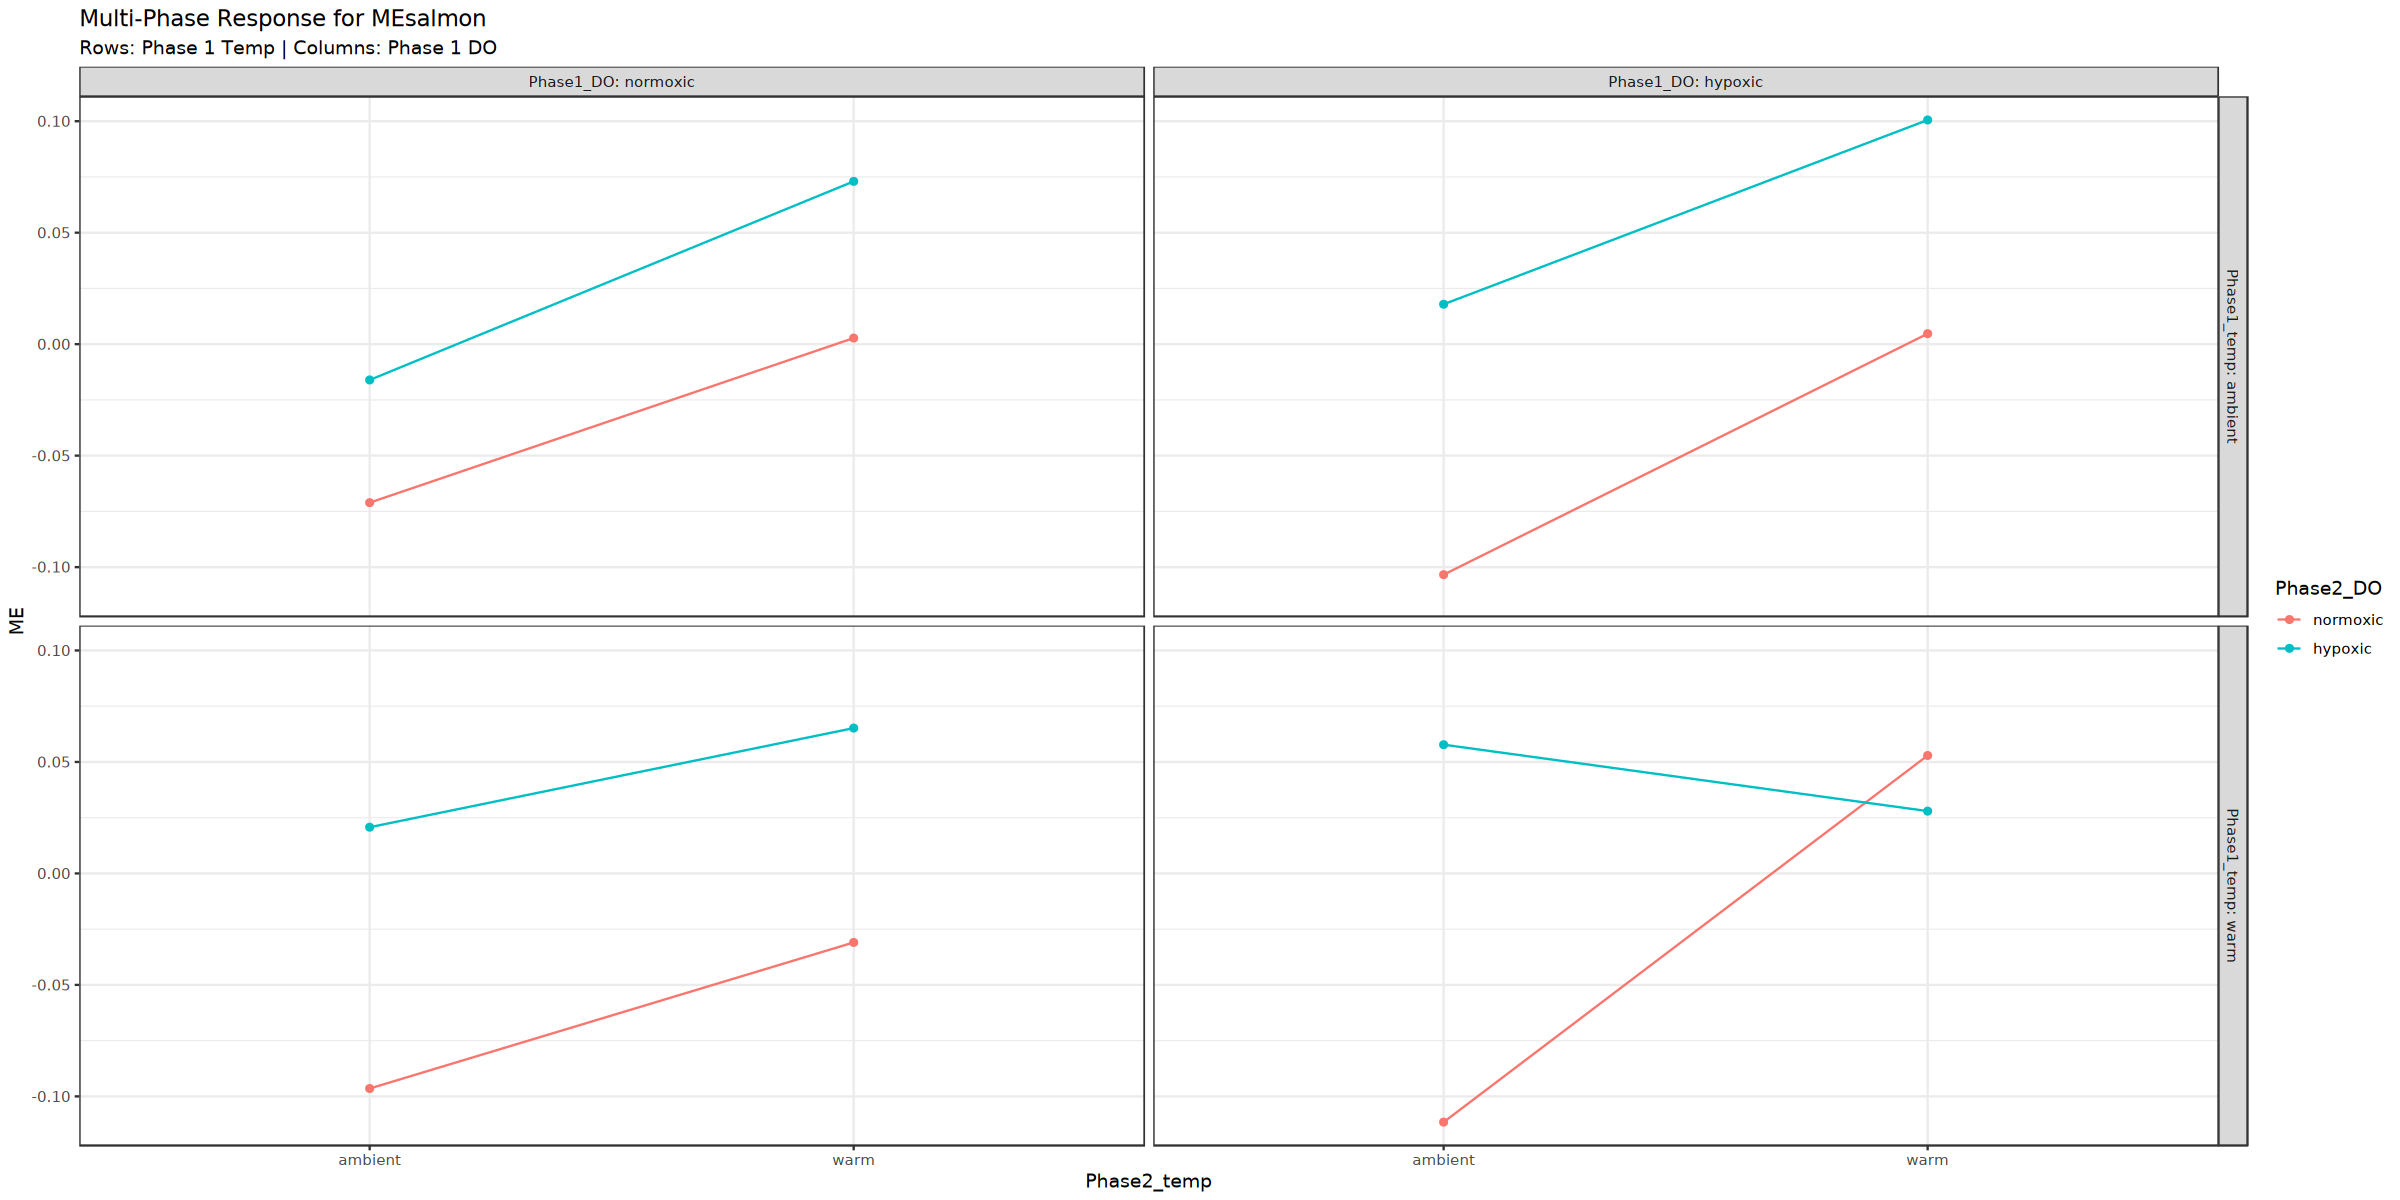

In [63]:
# Choose a module significant for the interaction
mod_to_plot <- "MEsalmon" 

plot_data <- cbind(meta_merge, ME = MEs[[mod_to_plot]])

ggplot(plot_data, aes(x = Phase2_temp, y = ME, color = Phase2_DO, group = Phase2_DO)) +
  stat_summary(fun = mean, geom = "line") +
  stat_summary(fun = mean, geom = "point") +
  # This creates a grid: Phase 1 Temp vs Phase 1 DO
  facet_grid(Phase1_temp ~ Phase1_DO, labeller = label_both) + 
  theme_bw() +
  labs(title = paste("Multi-Phase Response for", mod_to_plot),
       subtitle = "Rows: Phase 1 Temp | Columns: Phase 1 DO")

so this is just showing how module eigengene changes in phase 2 treatments (all of the points within a box have the same phase 1 treatment) - the blue lines are phase 2 hypoxic and red are normoxic - so appears that phase 2 hypoxic conditions, regardless of phase 1, have higher eigengenes (in the salmon module) than normoxic samples - when in phase 2 warm temps, this pattern remains, but slightly increases, *except* for when oysters experience phase 1 both (bottom right panel) - we actually see an interaction, where BW has higher eigengene expression than BB

I think there are better, more logical setups for this type of plot though

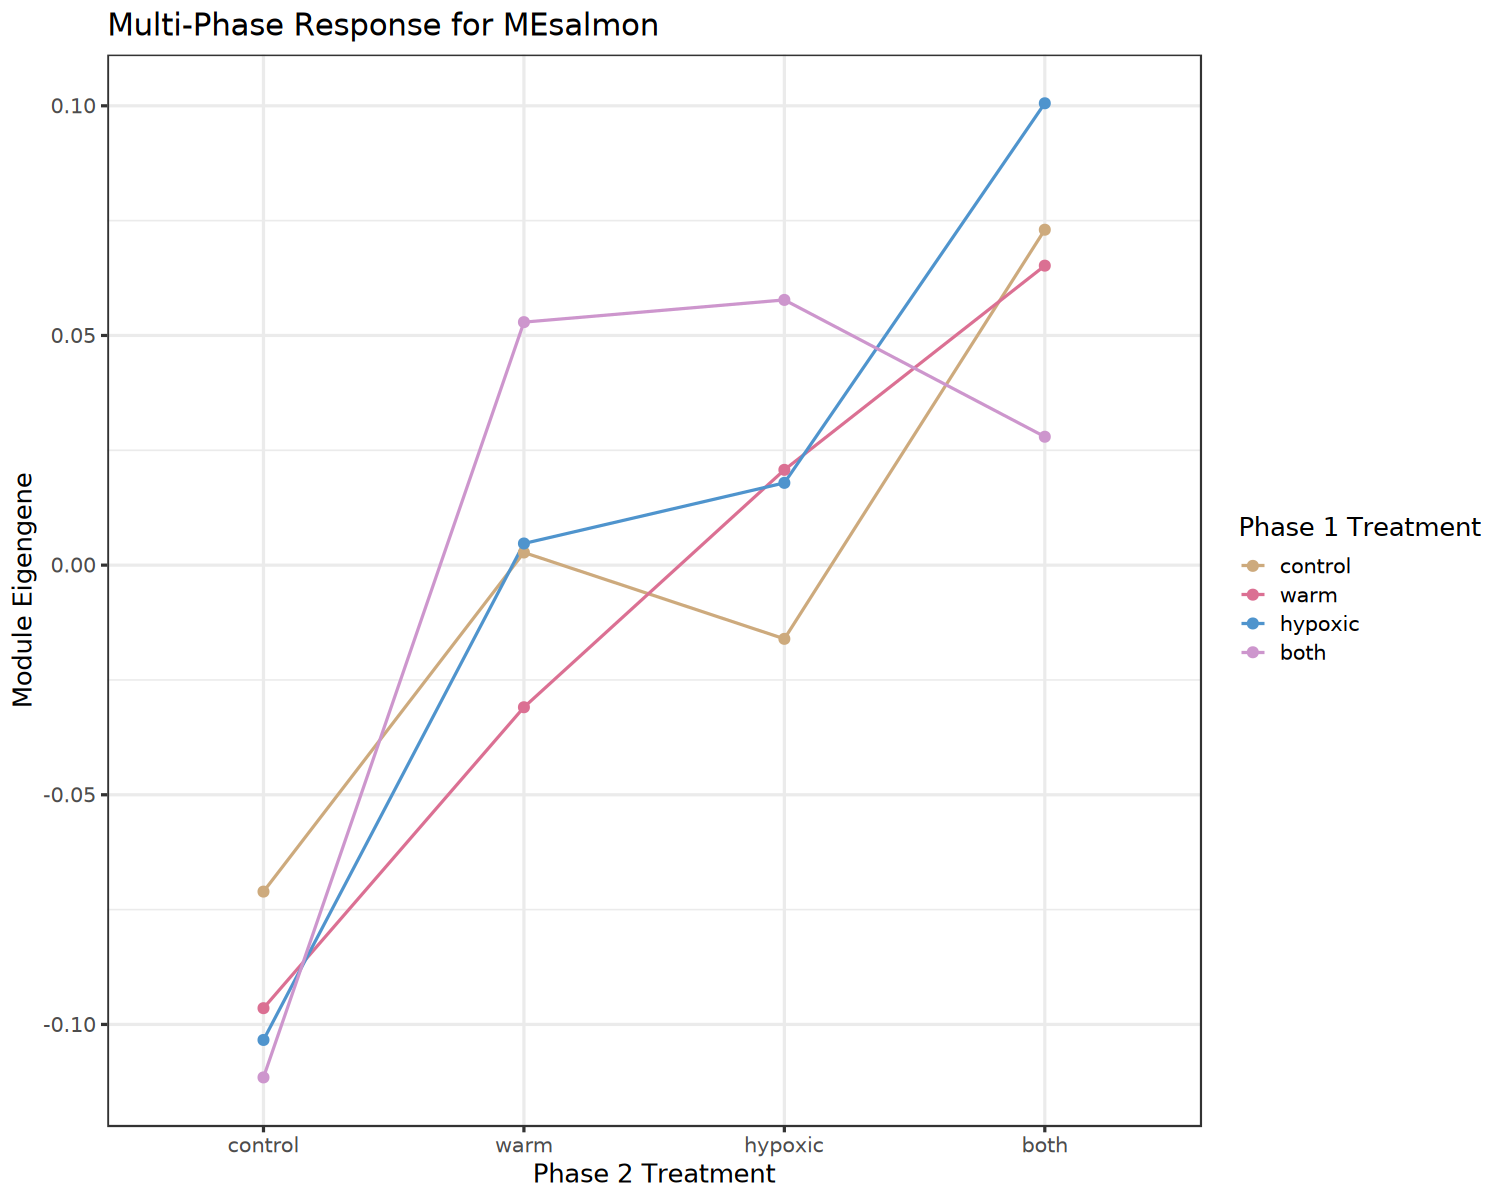

In [64]:
options(repr.plot.width = 12.5, repr.plot.height = 10)
# Choose a module significant for the interaction
mod_to_plot <- "MEsalmon" 

plot_data <- cbind(meta_merge, ME = MEs[[mod_to_plot]])

ggplot(plot_data, aes(x = Phase2_treatment, y = ME, color = Phase1_treatment, group = Phase1_treatment)) +
  stat_summary(fun = mean, geom = "line") +
  stat_summary(fun = mean, geom = "point") +
  # This creates a grid: Phase 1 Temp vs Phase 1 DO
 # facet_grid(Phase1_temp ~ Phase1_DO, labeller = label_both) + 
scale_color_manual(values = c("hypoxic" = "steelblue3", 
                             "warm" = "palevioletred", 
                             "control" = "burlywood3", 
                             "both" = "plum3")) +
  theme_bw(base_size = 15) +
  labs(title = paste("Multi-Phase Response for", mod_to_plot),
      x = 'Phase 2 Treatment',
      y = 'Module Eigengene',
      color = 'Phase 1 Treatment')

this is really just another way to look at the ME boxplots

for MEsalmon:
- all MEs are larger in phase 2 stressors than control
- phase 1 both seems to have higher ME when in phase 2 hypoxia or warm, but not control or both
- from heatmap - WC, HC, and BC had a sig neg. corr and HB has sig. pos. corr - can see that here

## Identify hub genes
hub genes = gene with the most connectivity within its module 

In [65]:
hubGenes <- chooseTopHubInEachModule(dataExpr, # vst expr. matrix
                         mergedColors_sign, # from dendogram above
                         omitColors = "grey", # grey module = genes not assigned to any module
                         power = 5, 
                         type = "signed")

# make into df, assign modules in column
hubGenes.df <- as.data.frame(hubGenes) %>%
mutate(module = rownames(.))
# remove row names
rownames(hubGenes.df) <- NULL

hubGenes.df

hubGenes     module      
1  LOC111121348 black       
2  LOC111108426 blue        
3  LOC111133766 brown       
4  LOC111136057 cyan        
5  LOC111102039 green       
6  LOC111129175 greenyellow 
7  LOC111119101 magenta     
8  LOC111130108 midnightblue
9  LOC111104655 pink        
10 LOC111101170 red         
11 LOC111119855 salmon      
12 LOC111122605 tan         
13 LOC111114430 turquoise   
14 LOC111135316 yellow

from the heatmap and boxplots above, the modules I'm most interested is:
- **green**: p1_temp
    - hub gene: *LOC111102039* - E3 ubiquitin-protein ligase, but withdrawn by NCBI Jan 2026
- **yellow**: p2_trtmt, p2_DO, p2_temp, tissue and shell growth
    - hub gene: *LOC111135316* - enoyl-CoA delta isomerase 2-like
- **salmon**: p2_trtmt, p2_DO, p2_temp, tissue and shell growth
    - hub gene: *LOC111119855* - forkhead box protein K1-like
- **magenta**: p2_trtmt, p2_DO, p2_temp, shell growth
    - hub gene: *LOC111119101* - putative E3 ubiquitin-protein ligase UNKL

## Gene significance (GS) and module membership (MM)
both are critical metrics for identifying hub genes within modules that are associated with specific treatment/traits
- GS = correlates gene expression with treatment/trait
- MM = how well a gene belongs to a module

basically select a module of interest and validate with GS and MM - combine GS and MM to find genes that are highly connected *and* strongly associated with the treatment/trait

In [66]:
modNames <- substring(names(MEs), 3)
modNames

[1] "green"        "red"          "blue"         "midnightblue" "cyan"        
 [6] "brown"        "yellow"       "turquoise"    "pink"         "black"       
[11] "tan"          "salmon"       "greenyellow"  "magenta"

#### module membership
MM is the same across all treatments

In [67]:
geneModuleMembership = as.data.frame(cor(dataExpr, MEs, use = "p"))
MMPvalue = as.data.frame(corPvalueStudent(as.matrix(geneModuleMembership), nSamples))

names(geneModuleMembership) = paste("MM", modNames, sep="")
names(MMPvalue) = paste("p.MM", modNames, sep="")

In [68]:
head(geneModuleMembership)

MMgreen     MMred       MMblue      MMmidnightblue MMcyan     
LOC111126949 -0.29131501 -0.41227355  0.11966094  0.10531261    -0.42733147
LOC111120752 -0.11377871  0.17704776 -0.54304750 -0.37744924     0.41867198
LOC111105691  0.07747739 -0.07983363 -0.03811632 -0.01667698     0.02404631
LOC111113860  0.07821217  0.02207649 -0.12657345  0.08711989     0.09883905
LOC111109550 -0.25482209  0.08180723  0.03327907 -0.06078129    -0.03377160
LOC111109753 -0.16215593 -0.06347819 -0.03184050 -0.17004572    -0.14010436
             MMbrown     MMyellow     MMturquoise MMpink     MMblack    
LOC111126949 -0.12748182 -0.118591219  0.07454674 0.16785589  0.35333236
LOC111120752  0.66129985  0.397522474  0.05965289 0.09464446 -0.04621819
LOC111105691  0.05422716  0.007444635 -0.02336339 0.02232239  0.07532960
LOC111113860  0.03153799  0.282311092 -0.02388304 0.03012267  0.03335159
LOC111109550  0.08119176 -0.075317074 -0.04866860 0.06626850  0.27558623
LOC111109753 -0.07522357 -0.082157545  0.47689288 0.04774739  0.23515441
             MMtan       MMsalmon     MMgreenyellow MMmagenta  
LOC111126949  0.30953368  0.210578762  0.47017151    0.52444279
LOC111120752  0.10549091 -0.289872345 -0.20700554   -0.40432308
LOC111105691  0.10503673  0.038893059  0.05409074    0.05947199
LOC111113860 -0.06064519 -0.257005221 -0.11392521   -0.25493077
LOC111109550  0.25754052 -0.019358840  0.01796356   -0.03180158
LOC111109753  0.43133343  0.009847284  0.03141847    0.01523514

#### gene significance
calculated for each treatment combination

In [69]:
# List all trait sets you want to process
trait_sets <- list(
  Combo_treatments = combo.treatments[-1],  # exclude first column 
  phase1_temp = phase1.temp[-1],
  phase1_DO = phase1.DO[-1],
    phase2_temp = phase2.temp[-1],
    phase2_DO = phase2.DO[-1],
    phase1_treatment = phase1.treatments[-1],
    phase2_treatment = phase2.treatments[-1]
)

# Initialize lists to store results
geneTraitSignificance_all <- list()
GSPvalue_all <- list()

# Loop over each trait set
for(set_name in names(trait_sets)){
  traits_df <- trait_sets[[set_name]]
  
  # Get trait names
  trait_names <- colnames(traits_df)
  
  # Initialize lists for this set
  gs_list <- list()
  gs_p_list <- list()
  
  for(trt in trait_names){
    trt_df <- as.data.frame(traits_df[[trt]])
    names(trt_df) <- trt
    
    # Compute gene-trait significance and p-values
    gs <- as.data.frame(cor(dataExpr, trt_df, use = "p"))
    gs_p <- as.data.frame(corPvalueStudent(as.matrix(gs), nSamples))
    
    # Rename columns
    names(gs) <- paste0("GS.", trt)
    names(gs_p) <- paste0("p.GS.", trt)
    
    # Store in lists
    gs_list[[trt]] <- gs
    gs_p_list[[trt]] <- gs_p
  }
  
  # Combine into data frames for this set
  geneTraitSignificance_all[[set_name]] <- do.call(cbind, gs_list)
  GSPvalue_all[[set_name]] <- do.call(cbind, gs_p_list)
}

# Optional: combine all sets into one big data frame each
geneTraitSignificance_df <- do.call(cbind, geneTraitSignificance_all)
GSPvalue_df <- do.call(cbind, GSPvalue_all)

In [70]:
head(geneTraitSignificance_df) 
head(GSPvalue_df)

Combo_treatments.GS.both_both Combo_treatments.GS.both_warm
LOC111126949  0.134535297                   0.08106639                  
LOC111120752 -0.097786103                  -0.21956669                  
LOC111105691  0.126973620                  -0.06603745                  
LOC111113860  0.003623701                   0.01218615                  
LOC111109550 -0.042907100                  -0.07502565                  
LOC111109753  0.197258378                   0.01029226                  
             Combo_treatments.GS.both_control Combo_treatments.GS.both_hypoxic
LOC111126949 -0.01984269                      -0.125567373                    
LOC111120752  0.03168394                       0.018923029                    
LOC111105691  0.05948199                       0.213544037                    
LOC111113860  0.21263364                      -0.157464093                    
LOC111109550 -0.10499058                      -0.009942346                    
LOC111109753  0.10515980                      -0.099310563                    
             Combo_treatments.GS.control_control
LOC111126949 -0.10214362                        
LOC111120752  0.27477457                        
LOC111105691 -0.02228376                        
LOC111113860  0.05464115                        
LOC111109550  0.03629926                        
LOC111109753 -0.05652168                        
             Combo_treatments.GS.control_hypoxic
LOC111126949  0.05743467                        
LOC111120752 -0.10304631                        
LOC111105691 -0.13581772                        
LOC111113860  0.03189497                        
LOC111109550 -0.13884252                        
LOC111109753 -0.09445992                        
             Combo_treatments.GS.control_both Combo_treatments.GS.control_warm
LOC111126949  0.07744699                      -0.002278528                    
LOC111120752 -0.09459133                      -0.033011911                    
LOC111105691  0.29495394                      -0.128277402                    
LOC111113860 -0.03010524                       0.022315762                    
LOC111109550 -0.05268374                      -0.067752474                    
LOC111109753 -0.04151125                       0.271375884                    
             Combo_treatments.GS.hypoxic_both
LOC111126949  0.12191108                     
LOC111120752  0.06183621                     
LOC111105691 -0.04301547                     
LOC111113860 -0.21582543                     
LOC111109550 -0.11075267                     
LOC111109753 -0.09442279                     
             Combo_treatments.GS.hypoxic_control ⋯ phase2_DO.GS.hypoxic
LOC111126949 -0.07840426                         ⋯  0.05012042         
LOC111120752  0.11424134                         ⋯ -0.16086092         
LOC111105691 -0.07651353                         ⋯  0.16779073         
LOC111113860  0.13700159                         ⋯ -0.25046864         
LOC111109550  0.18718037                         ⋯ -0.12712241         
LOC111109753 -0.05215162                         ⋯ -0.08821365         
             phase2_DO.GS.normoxic phase1_treatment.GS.both
LOC111126949 -0.05012042            0.04746133             
LOC111120752  0.16086092           -0.15659878             
LOC111105691 -0.16779073            0.18013370             
LOC111113860  0.25046864            0.03842045             
LOC111109550  0.12712241           -0.12917569             
LOC111109753  0.08821365            0.12308720             
             phase1_treatment.GS.control phase1_treatment.GS.hypoxic
LOC111126949  0.017101260                -0.008029922               
LOC111120752  0.024773649                 0.092643875               
LOC111105691  0.004814397                -0.245404509               
LOC111113860  0.044211686                -0.084110272               
LOC111109550 -0.125190094                -0.070194980               
LOC111109753  0.044288267                -0.166682

In [71]:
colnames(geneTraitSignificance_df)
colnames(GSPvalue_df)

[1] "Combo_treatments.GS.both_both"       "Combo_treatments.GS.both_warm"      
 [3] "Combo_treatments.GS.both_control"    "Combo_treatments.GS.both_hypoxic"   
 [5] "Combo_treatments.GS.control_control" "Combo_treatments.GS.control_hypoxic"
 [7] "Combo_treatments.GS.control_both"    "Combo_treatments.GS.control_warm"   
 [9] "Combo_treatments.GS.hypoxic_both"    "Combo_treatments.GS.hypoxic_control"
[11] "Combo_treatments.GS.hypoxic_warm"    "Combo_treatments.GS.hypoxic_hypoxic"
[13] "Combo_treatments.GS.warm_control"    "Combo_treatments.GS.warm_hypoxic"   
[15] "Combo_treatments.GS.warm_warm"       "Combo_treatments.GS.warm_both"      
[17] "phase1_temp.GS.warm"                 "phase1_temp.GS.ambient"             
[19] "phase1_DO.GS.hypoxic"                "phase1_DO.GS.normoxic"              
[21] "phase2_temp.GS.warm"                 "phase2_temp.GS.ambient"             
[23] "phase2_DO.GS.hypoxic"                "phase2_DO.GS.normoxic"              
[25] "phase1_treatment.GS.both"            "phase1_treatment.GS.control"        
[27] "phase1_treatment.GS.hypoxic"         "phase1_treatment.GS.warm"           
[29] "phase2_treatment.GS.both"            "phase2_treatment.GS.warm"           
[31] "phase2_treatment.GS.control"         "phase2_treatment.GS.hypoxic"

In [72]:
annot <- read.csv('//work/pi_sarah_gignouxwolfsohn_uml_edu/julia_mcdonough_student_uml_edu/ref_files/annotations/geneGO.txt', sep = '\t')
colnames(annot)[1] <- 'Gene'
colnames(annot)[2] <- 'GO.terms'
head(annot)

Gene        
1 LOC111126949
2 LOC111112434
3 LOC111120752
4 LOC111105685
5 LOC111113860
6 LOC111109550
  GO.terms                                                                                                              
1 GO:0005042; GO:0005737; GO:0008233; GO:0016020; GO:0043123; GO:0046330                                                
2 GO:0000981; GO:0003700; GO:0005634; GO:0016607; GO:0043565; GO:0045944                                                
3 GO:0004750; GO:0005829; GO:0005975; GO:0006098; GO:0009052; GO:0042802; GO:0042803; GO:0046872; GO:0070062            
4 GO:0003682; GO:0004518; GO:0005634; GO:0035098; GO:0035102; GO:0040029; GO:0046872                                    
5 GO:0004062; GO:0005737; GO:0006068; GO:0006805; GO:0008146; GO:0009812; GO:0030855; GO:0042403; GO:0050427; GO:0051923
6 GO:0004062; GO:0005737; GO:0005764; GO:0008146; GO:0051923

In [73]:
# 1. Create a data frame for gene information
# Ensure the names of the vector match your gene names
gene_info <- data.frame(
  Gene = colnames(dataExpr),
  ModuleColor = mergedColors_sign
)

# 2. Bind it with  MM and GS dataframes
# (Assuming these have genes as row names in the same order)
final_results <- cbind(gene_info, geneTraitSignificance_df, geneModuleMembership)

# 3. Add GO terms
final_res <- merge(annot, final_results, by = 'Gene')

# 3. Take a look
head(final_res)

Gene        
1 COX1        
2 COX2        
3 COX3        
4 CYTB        
5 LOC111099029
6 LOC111099033
  GO.terms                                                                                                                                                                                      
1 GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0045277; GO:0046872                                                                                                                        
2 GO:0004129; GO:0005507; GO:0005743; GO:0070469                                                                                                                                                
3 GO:0004129; GO:0005743; GO:0008535; GO:0019646; GO:0045277                                                                                                                                    
4 GO:0005743; GO:0008121; GO:0022904; GO:0045275; GO:0046872                                                                                                                                    
5 GO:0005886; GO:0015280; GO:0035725; GO:0046872; GO:0047631; GO:0070588; GO:0099604                                                                                                            
6 GO:0005737; GO:0005886; GO:0005903; GO:0006814; GO:0007420; GO:0008520; GO:0009636; GO:0009925; GO:0015081; GO:0015229; GO:0015882; GO:0016324; GO:0030324; GO:0033300; GO:0043229; GO:0070837
  ModuleColor Combo_treatments.GS.both_both Combo_treatments.GS.both_warm
1 brown        0.01890862                   -0.0565456949                
2 brown       -0.02712349                   -0.0763355202                
3 brown        0.01199400                   -0.0923327745                
4 brown        0.06678880                   -0.0001181687                
5 blue         0.02251138                    0.0324885000                
6 salmon       0.03262849                   -0.0054834451                
  Combo_treatments.GS.both_control Combo_treatments.GS.both_hypoxic
1 -0.07639120                      -0.15771421                     
2 -0.04636546                      -0.07633242                     
3 -0.02501484                      -0.05114432                     
4 -0.05187666                      -0.32304961                     
5  0.06112436                      -0.04309088                     
6 -0.14770857                       0.24694553                     
  Combo_treatments.GS.control_control Combo_treatments.GS.control_hypoxic
1 -0.07403373                         -0.01311223                        
2  0.01938493                         -0.11795616                        
3  0.02632895                         -0.07263109                        
4  0.08920278                         -0.20809823                        
5  0.03163502                         -0.05860583                        
6 -0.03531460                         -0.10445214                        
  Combo_treatments.GS.control_both ⋯ MMcyan      MMbrown     MMyellow  
1  0.088481991                     ⋯  0.17223558  0.52972753  0.2700327
2  0.177115626                     ⋯  0.20624426  0.60966090  0.1083271
3  0.105828221                     ⋯  0.43047835  0.63169637  0.2772417
4  0.006858974                     ⋯  0.09911882  0.54351840  0.2707225
5 -0.036712566                     ⋯ -0.10486420 -0.17749325 -0.1687577
6  0.128748715                     ⋯ -0.20497309 -0.02989429 -0.4049090
  MMturquoise MMpink      MMblack     MMtan       MMsalmon    MMgreenyellow
1  0.27599905 -0.02328820 -0.04901975  0.03370438 -0.03980008  0.13300933  
2  0.24229607 -0.05538884 -0.03260110 -0.06000427  0.04928647 -0.06837658  
3  0.20909597 -0.08887830 -0.04963871 -0.01473983 -0.18648499 -0.23508693  
4  0.27827386 -0.01382435  0.04921847  0.10926803 -0.08622249  0.05725341  
5 -0.10730071 -0.17455884 -0.12058475  0.03029584  0.08641709 -0.00399179  
6 -0.01626329  0.14476401  0.43674437  0.07854242  0.60551361  0.08920579 

In [74]:
write.csv(final_res, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/wgcna/p2.wgcna_GeneInfo.csv', row.names = FALSE)

## vst expression of modules

In [75]:
# convert vst matrix to df
vst_expr <- as.data.frame(dataExpr)
# add sample column from rowname
vst_expr$Sample <- rownames(vst_expr)

head(vst_expr)

LOC111126949 LOC111120752 LOC111105691 LOC111113860 LOC111109550
B1_B1_O01 10.197580    9.363550     7.692872     10.302224    8.131067    
B1_W5_O50  9.653169    9.355360     7.845404     10.031913    7.805746    
B2_B5_O51  9.900281    9.509373     8.595408      9.556539    8.743886    
B2_C4_O40  9.718856    9.284512     8.101515     10.120153    7.928364    
B3_B4_O41  9.612738    9.198871     8.014009      9.338809    7.708812    
B3_C3_O30  9.545333    9.337765     8.149132     10.341242    7.803846    
          LOC111109753 LOC111109452 LOC111124802 LOC111101273 LOC111101250 ⋯
B1_B1_O01 7.692872     11.31884     11.25794     10.35382     10.544786    ⋯
B1_W5_O50 7.730536     11.32200     11.37617     10.47538     10.170402    ⋯
B2_B5_O51 9.497301     11.18147     11.50604     10.33112      9.856560    ⋯
B2_C4_O40 7.843091     11.37670     10.99368     10.35334     10.335596    ⋯
B3_B4_O41 7.548551     10.88706     11.02026     10.68052     10.109437    ⋯
B3_C3_O30 7.776953     11.66343     11.29785     10.70259      9.960555    ⋯
          COX2     ATP6     ND2      ND4      ND5      ND6      ND3     
B1_B1_O01 17.35567 16.72734 16.55278 17.40296 17.50511 15.27334 14.40950
B1_W5_O50 17.60046 17.05547 16.54477 16.97662 17.30129 15.59674 14.95796
B2_B5_O51 17.94342 17.27196 17.23549 17.79404 18.11808 15.98559 15.64247
B2_C4_O40 17.79882 17.27281 16.61824 17.19524 17.19285 15.14694 14.83363
B3_B4_O41 18.17021 17.54836 17.11674 17.49138 17.97654 15.71235 15.28878
B3_C3_O30 17.87689 17.64807 17.08072 17.29751 17.13546 15.58747 15.14063
          ND1      ND4L     Sample   
B1_B1_O01 17.08613 13.21049 B1_B1_O01
B1_W5_O50 17.21506 13.41728 B1_W5_O50
B2_B5_O51 17.74181 13.77409 B2_B5_O51
B2_C4_O40 17.01083 13.11047 B2_C4_O40
B3_B4_O41 17.71717 13.87237 B3_B4_O41
B3_C3_O30 17.14174 13.28853 B3_C3_O30

#### midnightblue module
significant negative correlation with Phase 1 temp (warm)

In [76]:
midnightblue_genes <- final_res %>%
  filter(ModuleColor == "midnightblue") %>%
  pull(Gene) # This returns just the vector of gene names

head(midnightblue_genes)
length(midnightblue_genes) # 165 genes in the midnightblue module

[1] "LOC111099165" "LOC111100400" "LOC111100546" "LOC111100576" "LOC111100587"
[6] "LOC111100756"

[1] 165

In [77]:
# pull out vst expr for genes in module of interest
midnightblue_vst <- vst_expr[,colnames(vst_expr) %in% midnightblue_genes] %>%
mutate(Sample = row.names(.)) %>%
  pivot_longer(
    cols = c(1:152), # select gene columns
    names_to = "Gene",
    values_to = "vst"
  ) 

midnightblue_vst <- merge(midnightblue_vst, meta_merge, by = 'Sample')
    
head(midnightblue_vst)
dim(midnightblue_vst)

Sample    Gene         vst       Phase1_treatment Phase1_temp Phase1_DO
1 B1_B1_O01 LOC111125882 10.554868 both             warm        hypoxic  
2 B1_B1_O01 LOC111108767  9.715772 both             warm        hypoxic  
3 B1_B1_O01 LOC111125536 11.496794 both             warm        hypoxic  
4 B1_B1_O01 LOC111099165 11.484995 both             warm        hypoxic  
5 B1_B1_O01 LOC111118748 11.454823 both             warm        hypoxic  
6 B1_B1_O01 LOC111134008 10.795946 both             warm        hypoxic  
  Phase1_TankRep Phase2_treatment Phase2_temp Phase2_DO ⋯ combo_trtmt
1 1              both             warm        hypoxic   ⋯ both_both  
2 1              both             warm        hypoxic   ⋯ both_both  
3 1              both             warm        hypoxic   ⋯ both_both  
4 1              both             warm        hypoxic   ⋯ both_both  
5 1              both             warm        hypoxic   ⋯ both_both  
6 1              both             warm        hypoxic   ⋯ both_both  
  Actual_shell_growth_mg Actual_tissue_growth_mg Ratio_tissue_shell_mg
1 210.2755               120.7245                0.574125224          
2 210.2755               120.7245                0.574125224          
3 210.2755               120.7245                0.574125224          
4 210.2755               120.7245                0.574125224          
5 210.2755               120.7245                0.574125224          
6 210.2755               120.7245                0.574125224          
  P1_trtmt_code P2_trtmt_code P1_temp_code P2_temp_code P1_DO_code P2_DO_code
1 4             4             2            2            2          2         
2 4             4             2            2            2          2         
3 4             4             2            2            2          2         
4 4             4             2            2            2          2         
5 4             4             2            2            2          2         
6 4             4             2            2            2          2

[1] 14136    21

In [78]:
mb.sd <- midnightblue_vst %>%
group_by(Phase1_temp) %>%
summarise(meanExp = mean(vst),
         sdExp = sd(vst))

mb.sd

Phase1_temp meanExp  sdExp   
1 ambient     10.51535 1.300855
2 warm        10.42895 1.305967

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


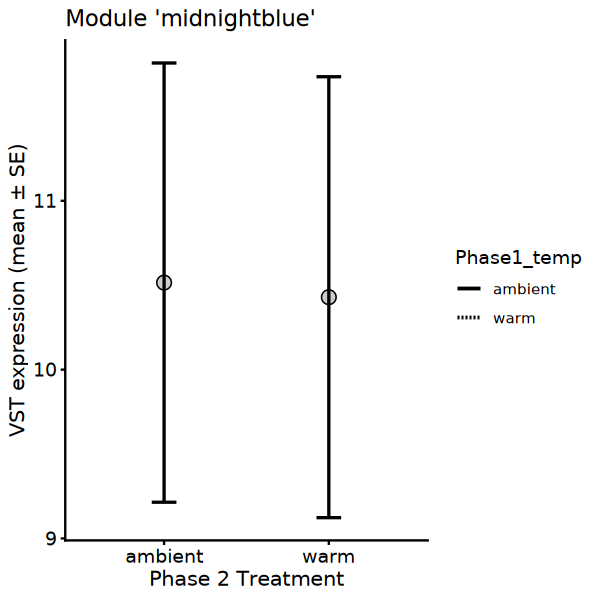

In [79]:
options(repr.plot.width = 5, repr.plot.height = 5)

ggplot(mb.sd, aes(x = Phase1_temp, y = meanExp)) +
  # lines
  geom_line(aes(linetype = Phase1_temp),
            linewidth = 0.8,
            color = "black") +
  # points
  geom_point(shape = 21,
             size = 3.5,
             fill = "grey80",
             color = "black") +
  # error bars
  geom_errorbar(aes(ymin = meanExp - sdExp, ymax = meanExp + sdExp),
                width = 0.15,
                linewidth = 0.7) +
  #scale_linetype_manual(values = c("solid", "dashed")) +
  # labels
  labs(
      title = "Module 'midnightblue'", 
    x = expression("Phase 2 Treatment"),
    y = "VST expression (mean ± SE)"
  ) +
  theme_classic() +
  theme(
    axis.text = element_text(size = 11),
    axis.title = element_text(size = 12)
  )

okay soooo not super different here lol - but this also wasn't a 'super important' module - this was only significant for phase 1 temperature

#### cyan module
significant positive correlation with Phase 2 temp (warm)

In [80]:
cyan_genes <- final_res %>%
  filter(ModuleColor == "cyan") %>%
  pull(Gene) # This returns just the vector of gene names

head(cyan_genes)
length(cyan_genes) # 249 genes in the midnightblue module

[1] "LOC111099093" "LOC111099138" "LOC111099206" "LOC111099209" "LOC111099845"
[6] "LOC111100294"

[1] 249

In [81]:
# pull out vst expr for genes in module of interest
cyan_vst <- vst_expr[,colnames(vst_expr) %in% cyan_genes] %>%
mutate(Sample = row.names(.)) %>%
  pivot_longer(
    cols = c(1:235), # select gene columns
    names_to = "Gene",
    values_to = "vst"
  ) 

cyan_vst <- merge(cyan_vst, meta_merge, by = 'Sample')
    
head(cyan_vst)
dim(cyan_vst)

Sample    Gene         vst       Phase1_treatment Phase1_temp Phase1_DO
1 B1_B1_O01 LOC111101273 10.353823 both             warm        hypoxic  
2 B1_B1_O01 LOC111137068 13.556447 both             warm        hypoxic  
3 B1_B1_O01 LOC111129311  9.526589 both             warm        hypoxic  
4 B1_B1_O01 LOC111134864 13.127496 both             warm        hypoxic  
5 B1_B1_O01 LOC111130318 11.830305 both             warm        hypoxic  
6 B1_B1_O01 LOC111100444 11.000439 both             warm        hypoxic  
  Phase1_TankRep Phase2_treatment Phase2_temp Phase2_DO ⋯ combo_trtmt
1 1              both             warm        hypoxic   ⋯ both_both  
2 1              both             warm        hypoxic   ⋯ both_both  
3 1              both             warm        hypoxic   ⋯ both_both  
4 1              both             warm        hypoxic   ⋯ both_both  
5 1              both             warm        hypoxic   ⋯ both_both  
6 1              both             warm        hypoxic   ⋯ both_both  
  Actual_shell_growth_mg Actual_tissue_growth_mg Ratio_tissue_shell_mg
1 210.2755               120.7245                0.574125224          
2 210.2755               120.7245                0.574125224          
3 210.2755               120.7245                0.574125224          
4 210.2755               120.7245                0.574125224          
5 210.2755               120.7245                0.574125224          
6 210.2755               120.7245                0.574125224          
  P1_trtmt_code P2_trtmt_code P1_temp_code P2_temp_code P1_DO_code P2_DO_code
1 4             4             2            2            2          2         
2 4             4             2            2            2          2         
3 4             4             2            2            2          2         
4 4             4             2            2            2          2         
5 4             4             2            2            2          2         
6 4             4             2            2            2          2

[1] 21855    21

In [82]:
cyan.mean.sd <- cyan_vst %>%
group_by(Phase2_temp) %>%
summarise(meanExp = mean(vst),
         sdExp = sd(vst))

cyan.mean.sd

Phase2_temp meanExp  sdExp   
1 ambient     11.95853 1.411331
2 warm        11.78629 1.403957

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


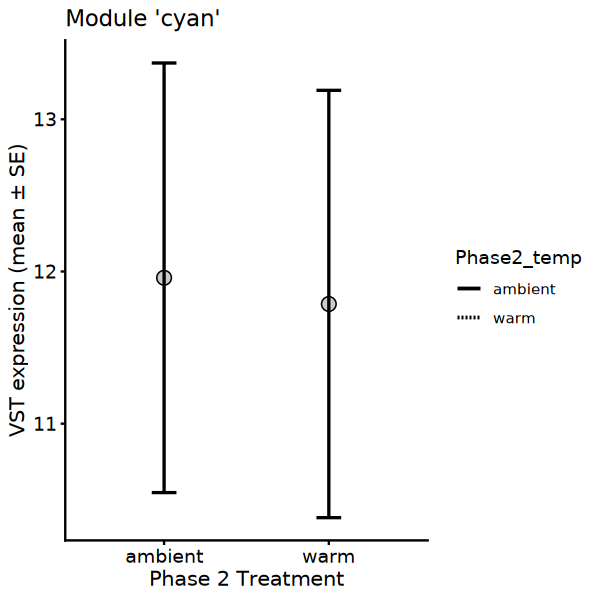

In [83]:
options(repr.plot.width = 5, repr.plot.height = 5)

ggplot(cyan.mean.sd, aes(x = Phase2_temp, y = meanExp)) +
  # lines
  geom_line(aes(linetype = Phase2_temp),
            linewidth = 0.8,
            color = "black") +
  # points
  geom_point(shape = 21,
             size = 3.5,
             fill = "grey80",
             color = "black") +
  # error bars
  geom_errorbar(aes(ymin = meanExp - sdExp, ymax = meanExp + sdExp),
                width = 0.15,
                linewidth = 0.7) +
  #scale_linetype_manual(values = c("solid", "dashed")) +
  # labels
  labs(
      title = "Module 'cyan'", 
    x = expression("Phase 2 Treatment"),
    y = "VST expression (mean ± SE)"
  ) +
  theme_classic() +
  theme(
    axis.text = element_text(size = 11),
    axis.title = element_text(size = 12)
  )